In [1]:
import pandas as pd
import re
from nltk import word_tokenize
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
import nltk
import textattack
from nltk.corpus import wordnet

from textattack.models.wrappers import ModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.transformations.word_swaps import WordSwap
from textattack import AttackArgs
from textattack import Attacker
from textattack import Attack
from textattack.constraints.pre_transformation import (
    RepeatModification,
    StopwordModification,
)
from textattack.goal_functions import UntargetedClassification
from textattack.search_methods import GreedyWordSwapWIR
from textattack.attack_recipes import AttackRecipe
from textattack.loggers import CSVLogger
from textattack.attack_results import SuccessfulAttackResult


In [2]:
def load_data(dataset_split="train"):
    df = pd.read_csv(f'LabelEncoded_{dataset_split}_data.csv')
    # Remove non-alphanumeric characters
    df["text"] = df["text"].apply(lambda x: re.sub("[^a-zA-Z]", " ", str(x)))
    df['text'] = df['text'].apply(lambda x: re.sub('  +', ' ', str(x)))
    df['text'] = df['text'].apply(lambda x: re.sub('\n', ' ', str(x)))
    df['text'] = df['text'].apply(lambda x: re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', str(x)))
    # Tokenize the training and testing data
    df_tokenized = tokenize_review(df)
    return df_tokenized

def tokenize_review(df):
    # Tokenize Reviews in the DataFrame
    tokened_reviews = [word_tokenize(rev) for rev in df["text"]]
    
    # Initialize the Indonesian stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Stem tokens for each review in Indonesian
    stemmed_tokens = []
    for tokens in tokened_reviews:
        # Join the tokens into a single string for stemming, since Sastrawi expects a sentence
        sentence = " ".join(tokens)
        # Perform stemming on the whole sentence
        stemmed_sentence = stemmer.stem(sentence)
        stemmed_tokens.append(stemmed_sentence)

    # Insert the stemmed reviews into the DataFrame
    df.insert(1, column="Stemmed", value=stemmed_tokens)
    
    return df

In [3]:
df_train = load_data("train")
df_test = load_data('test')

In [4]:
df_val = load_data('valid')

In [5]:
df_train

,text,Stemmed,label,source
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini milik oleh usaha pabrik tahu yang s...,2,indonlue/smsa
1,mohon ulama lurus dan k mmbri hujjah partai ap...,mohon ulama lurus dan k mmbri hujjah partai ap...,1,indonlue/smsa
2,lokasi strategis di jalan sumatera bandung tem...,lokasi strategis di jalan sumatera bandung tem...,2,indonlue/smsa
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unboxing pake...,2,indonlue/smsa
4,duh jadi mahasiswa jangan sombong dong kasih k...,duh jadi mahasiswa jangan sombong dong kasih k...,0,indonlue/smsa
...,...,...,...,...
10995,tidak kecewa,tidak kecewa,2,indonlue/smsa
10996,enak rasa masakan nya apalagi kepiting yang me...,enak rasa masakan nya apalagi kepiting yang se...,2,indonlue/smsa
10997,hormati partai partai yang telah berkoalisi,hormat partai partai yang telah koalisi,1,indonlue/smsa
10998,pagi pagi di tol pasteur sudah macet parah bik...,pagi pagi di tol pasteur sudah macet parah bik...,0,indonlue/smsa


In [6]:
X_train = df_train['Stemmed'].astype(str)
X_test = df_test['Stemmed'].astype(str)
y_train = df_train['label']
y_test = df_test['label']

In [7]:
X_val = df_val['Stemmed'].astype(str)
y_val = df_val['label']

In [8]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [9]:
y_val = le.fit_transform(y_val)

In [10]:
max_words = 5000  # Jumlah kata unik yang akan diikutsertakan dalam Tokenizer
max_len = 512     # Panjang maksimum dari sebuah sequence (dapat disesuaikan)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [11]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [12]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_len)

In [30]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [31]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

From C:\Users\Ilham AM\AppData\Roaming\Python\Python310\site-packages\keras\src\optimizers\__init__.py:309: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 512, 128)          640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 691587 (2.64 MB)
Trainable params: 691587 (2.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [79]:
#Train Model
history = model.fit(X_train_padded, y_train, batch_size=256, epochs=10, validation_data=(X_val_padded, y_val), callbacks=early_stopping)

Epoch 1/10
43/43 [==============================] - 100s 2s/step - loss: 1.0680 - accuracy: 0.6980 - val_loss: 0.7883 - val_accuracy: 0.7810
Epoch 2/10
43/43 [==============================] - 97s 2s/step - loss: 0.6445 - accuracy: 0.8319 - val_loss: 0.5754 - val_accuracy: 0.8492
Epoch 3/10
43/43 [==============================] - 97s 2s/step - loss: 0.4465 - accuracy: 0.9032 - val_loss: 0.4719 - val_accuracy: 0.8675
Epoch 4/10
43/43 [==============================] - 97s 2s/step - loss: 0.3237 - accuracy: 0.9283 - val_loss: 0.4378 - val_accuracy: 0.8770
Epoch 5/10
43/43 [==============================] - 98s 2s/step - loss: 0.2565 - accuracy: 0.9386 - val_loss: 0.4112 - val_accuracy: 0.8810
Epoch 6/10
43/43 [==============================] - 97s 2s/step - loss: 0.2026 - accuracy: 0.9529 - val_loss: 0.4236 - val_accuracy: 0.8746
Epoch 7/10
43/43 [==============================] - 98s 2s/step - loss: 0.1696 - accuracy: 0.9583 - val_loss: 0.4420 - val_accuracy: 0.8698
Epoch 8/10
43/43 [=

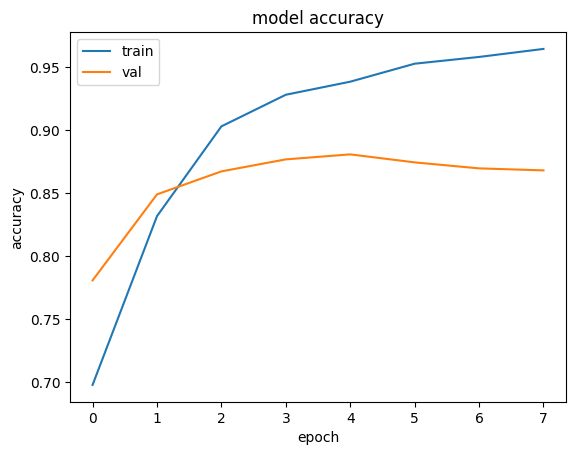

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

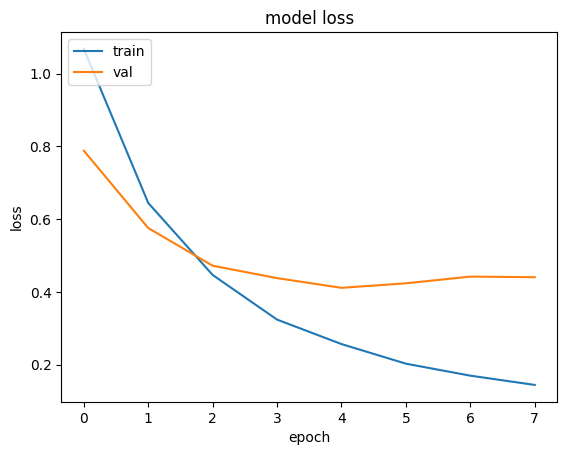

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [82]:
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

16/16 [==============================] - 1s 44ms/step


In [83]:
y_pred_labels = le.inverse_transform(y_pred)

In [84]:
print(classification_report(y_pred_labels, le.inverse_transform(y_test)))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82       256
           1       0.47      0.82      0.59        50
           2       0.79      0.85      0.82       194

    accuracy                           0.79       500
   macro avg       0.73      0.80      0.74       500
weighted avg       0.82      0.79      0.79       500



In [23]:
cm = confusion_matrix(y_pred_labels, le.inverse_transform(y_test))
cm

array([[182,  32,  40],
       [  4,  38,   4],
       [ 18,  18, 164]], dtype=int64)

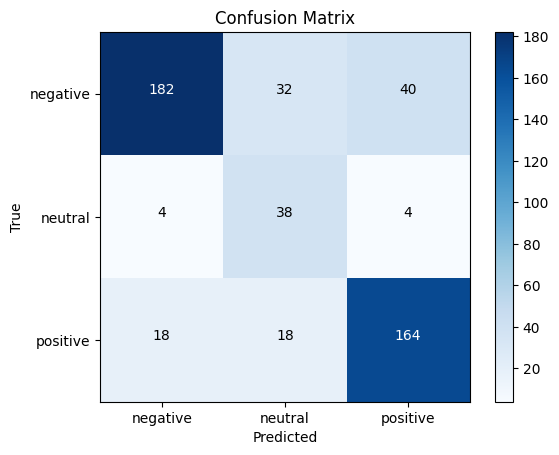

In [24]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['negative', 'neutral', 'positive'])
plt.yticks(tick_marks, ['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

In [101]:
from keras.layers import BatchNormalization, SpatialDropout1D, Dropout, Lambda
import keras.backend as K
from keras.optimizers import Adam

T = 2
model2 = Sequential()
model2.add(Embedding(max_words, 128, input_length=max_len))
model2.add(SpatialDropout1D(0.3))
model2.add(BatchNormalization())
model2.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model2.add(Dense(32, activation='relu', kernel_regularizer=l2(0.02)))
model2.add(Dropout(0.3))
model2.add(Dense(3))
model.add(Lambda(lambda x: K.softmax(x / T)))


In [102]:
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

In [103]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [104]:
model2.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 512, 128)          640000    
                                                                 
 spatial_dropout1d_5 (Spati  (None, 512, 128)          0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_6 (Bat  (None, 512, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)              

In [105]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [106]:
history2 = model2.fit(X_train_padded, y_train, batch_size=256, epochs=10, validation_data=(X_val_padded, y_val), callbacks=early_stopping)

Epoch 1/10
43/43 [==============================] - 112s 3s/step - loss: 2.9092 - accuracy: 0.5645 - val_loss: 1.6507 - val_accuracy: 0.6024
Epoch 2/10
43/43 [==============================] - 107s 2s/step - loss: 1.4832 - accuracy: 0.7028 - val_loss: 1.5619 - val_accuracy: 0.3524
Epoch 3/10
43/43 [==============================] - 108s 3s/step - loss: 1.3606 - accuracy: 0.8033 - val_loss: 1.4374 - val_accuracy: 0.3341
Epoch 4/10
43/43 [==============================] - 108s 3s/step - loss: 1.0886 - accuracy: 0.8412 - val_loss: 1.3520 - val_accuracy: 0.4016
Epoch 5/10
43/43 [==============================] - 107s 2s/step - loss: 0.9143 - accuracy: 0.8650 - val_loss: 1.2096 - val_accuracy: 0.3524
Epoch 6/10
43/43 [==============================] - 107s 2s/step - loss: 0.7905 - accuracy: 0.8843 - val_loss: 1.2046 - val_accuracy: 0.4325
Epoch 7/10
43/43 [==============================] - 107s 2s/step - loss: 0.6548 - accuracy: 0.9034 - val_loss: 0.9992 - val_accuracy: 0.5984
Epoch 8/10
43

In [110]:
y_pred_prob = model2.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

16/16 [==============================] - 1s 58ms/step


In [111]:
y_pred_labels = le.inverse_transform(y_pred)

In [112]:
print(classification_report(y_pred_labels, le.inverse_transform(y_test)))

              precision    recall  f1-score   support

           0       0.98      0.54      0.70       371
           1       0.33      0.78      0.46        37
           2       0.40      0.91      0.56        92

    accuracy                           0.63       500
   macro avg       0.57      0.75      0.57       500
weighted avg       0.83      0.63      0.65       500



In [113]:
class WordSwapWordNetBahasa(WordSwap):
    """Transforms an input by replacing its words with synonyms provided by
    WordNet.

    >>> from textattack.transformations import WordSwapWordNet
    >>> from textattack.augmentation import Augmenter

    >>> transformation = WordSwapWordNet()
    >>> augmenter = Augmenter(transformation=transformation)
    >>> s = 'I am fabulous.'
    >>> augmenter.augment(s)
    """

    def __init__(self, language="ind"):
        nltk.download("omw-1.4")
        # if language not in wordnet.langs():
        #     raise ValueError(f"Language {language} not one of {wordnet.langs()}")
        self.language = language

    def _get_replacement_words(self, word, random=False):
        """Returns a list containing all possible words with 1 character
        replaced by a homoglyph."""
        synonyms = set()
        for syn in wordnet.synsets(word, lang=self.language):
            for syn_word in syn.lemma_names(lang=self.language):
                if (
                    (syn_word != word)
                    and ("_" not in syn_word)
                    and (textattack.shared.utils.is_one_word(syn_word))
                ):
                    # WordNet can suggest phrases that are joined by '_' but we ignore phrases.
                    synonyms.add(syn_word)
        return list(synonyms)


In [114]:
class PWWSham2024INDO(AttackRecipe):
    
    @staticmethod
    def build(model_wrapper):
        transformation = WordSwapWordNetBahasa(language="ind")
        constraint = [RepeatModification(), StopwordModification(language='indonesian')]
        goal_function = UntargetedClassification(model_wrapper)
        search_method = GreedyWordSwapWIR("weighted-saliency")
        return Attack(goal_function, constraint, transformation, search_method)

In [115]:
class KerasModelWrapper(ModelWrapper):
    def __init__(self, model, tokenizer, max_len):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, text_list):
        sequences = self.tokenizer.texts_to_sequences(text_list)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_len)
        return self.model.predict(padded_sequences)


In [116]:
custom_data = list(df_test[['text', 'label']].itertuples(index=False, name=None))

In [118]:
model_wrapper = KerasModelWrapper(model=model2, tokenizer=tokenizer, max_len=max_len)

In [119]:
import logging
from textattack.datasets import Dataset
logging.basicConfig(filename="textattack_output.log", level=logging.INFO)

dataset = Dataset(custom_data) #HuggingFaceDataset("tyqiangz/multilingual-sentiments", "indonesian", "test")
attack = PWWSham2024INDO.build(model_wrapper)

attackargs = AttackArgs(num_examples=500, log_to_csv="attack_results_tf.csv")
attacker = Attacker(attack, dataset, attack_args=attackargs)
attack_results = attacker.attack_dataset()

for result in attack_results:
    logging.info(result)

[nltk_data] Downloading package omw-1.4 to C:\Users\Ilham
[nltk_data]     AM\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
textattack: Unknown if model of class <class 'keras.src.engine.sequential.Sequential'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path attack_results_tf.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNetBahasa
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step


[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:07<1:05:48,  7.91s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

kemarin gue datang ke tempat makan baru yang ada di dago atas gue kira makanan nya enak karena harga nya mahal ternyata boro boro tidak mau lagi deh ke tempat itu sudah mana tempat nya juga tidak nyaman banget terlalu sempit 


1/1 [==============================] - 0s 74ms/step


[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/500 [00:11<47:05,  5.67s/it]  

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

kayak nya sih gue tidak akan mau balik lagi ke tempat itu gila ya gue enggak ngerti kenapa tempat nya dibiarkan panas sudah begitu kotor pula kalau panas kepanasan kalau hujan kehujanan harus nya sih tidak ada restoran yang kayak gitu tidak tahu deh apa yang mereka jual 


1/1 [==============================] - 0s 70ms/step


[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   1%|          | 3/500 [00:12<35:19,  4.27s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (45%)]] --> [[[FAILED]]]

kalau dipikir pikir sebenarnya tidak ada yang bisa dibanggakan dari jokowi pertama dia tidak bisa nepatin janji kedua kerjaan nya selalu pencitraan ketiga dia tidak pro rakyat sudahlah ku sudah terlanjur kecewa 


1/1 [==============================] - 0s 67ms/step


[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 4/500 [00:17<36:20,  4.40s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

ini pertama kalinya gua ke bank buat ngurusin pembuatan rekening baru nama nya juga orang pertama kali ya baru ke bank gua kena semprot kelihatan banget pelayanan pelanggan nya tidak suka gua banyak bertanya amit amit padahal itu kan tugas mereka buat melayangkan gua 


1/1 [==============================] - 0s 92ms/step


[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 5/500 [00:22<37:47,  4.58s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

waktu sampai dengan gue pernah disuruh ibu latihan karate kata nya biar gue bisa melawan penjahat kalau ada laki laki iseng tapi di hari pertama latihan kaki gue langsung cedera jadilah sekarang trauma dan tidak mau sekali sekali buat latihan karate lagi 




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:   1%|          | 5/500 [00:22<37:48,  4.58s/it]

1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:   1%|          | 6/500 [00:26<36:23,  4.42s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

pelayanan di hotel salak bogor tidak sebagus yang gue membayangkan fasilitas nya juga biasa banget padahal kata nya hotel bintang lima hm kecewa kayak nya sih nanti nanti tidak mau ke sana lagi 


1/1 [==============================] - 0s 79ms/step


[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:   1%|▏         | 7/500 [00:29<34:04,  4.15s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (45%)]] --> [[[FAILED]]]

ada apa dengan young lex kenapa dia harus mengirim hal hal tidak berfaedah kayak gitu merusak moral banget sumpah 


1/1 [==============================] - 0s 67ms/step


[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:   2%|▏         | 8/500 [00:33<34:37,  4.22s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

gue pesimis sama manusia terutama dalam ngurusin sampah sudah berapa banyak hewan hewan laut jadi korban gara gara kita buang sampah ke laut tidak tega gue liat nya kadang tidak mengerti juga sebenarnya pemimpin pemimpin yang ada itu pada mikirin enggak sih urusan penting kayak gini he 


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:   2%|▏         | 9/500 [00:36<33:09,  4.05s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

saya kecewa karena pengeditan biodata penumpang dilakukan by sistem tanpa konfirmasi dan solusi permasalahan nya pun dianggap sepele karena dibiarkan begitu saja sedang pelayanan pelanggan yang sudah berkali berkali dihubungi pun hanya seperti mengulur waktu sampai detik ini belum ada solusi untuk masalah saya yang kesalahan nya sendiri bukan dari pihak saya 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10:   2%|▏         | 10/500 [00:39<32:12,  3.94s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

saya hari ini melakukan pemesanan dan tiket saya tidak kunjung saya terima padahal saya sudah menelpon pelayanan pelanggan sudah mengirimkan email dengan bukti transfer tapi respon nya sangat lambat dan tidak jelas 


1/1 [==============================] - 0s 58ms/step


[Succeeded / Failed / Skipped / Total] 0 / 11 / 0 / 11:   2%|▏         | 11/500 [00:44<33:14,  4.08s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

sangat merugikan saya sudah memesan dan membayar tetapi e tiket tidak ada juga padahal bukti pembayaran sudah jelas sudah menelepon pelayanan pelanggan berkali kali dan tidak ada solusi nya pulsa sudah habis ratusan ribu saya meminta kembalikan uang juga sangat lama proses nya sangat merugikan pengguna banyak kerugian uang transport waktu penginapan dll 


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 0 / 12 / 0 / 12:   2%|▏         | 12/500 [00:49<33:52,  4.17s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

saya itu memesan tiket dot com sudah dibayar email belum ada balasan bukti pembayaran sudah saya kirim by email saya masukkan data balasan nya pemesanan kadaluarsa terus akhirnya saya beli lagi langsung ke loket saya minta uang kembali masih menunggu hari ambil saja uang tiket nya tidak apa apa sedih saya download aplikasi ini 


1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 0 / 13 / 0 / 13:   3%|▎         | 13/500 [00:52<32:34,  4.01s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

saya sudah bayar tetapi etiket tidak dikirim malah kadaluwarsa diminta struk pembayaran saya sudah tidak punya hanya sms banking tetapi tetap saja tidak digubris dari pelayanan pelanggan nya sudah email dan telepon berkali berkali tetap tidak ada hasil sangat mengecewakan 


1/1 [==============================] - 0s 57ms/step


[Succeeded / Failed / Skipped / Total] 0 / 14 / 0 / 14:   3%|▎         | 14/500 [00:54<31:41,  3.91s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

saya mesan tiket tapi tidak dikonformasi dan proses pengembalian uang yang tidak jelas dan belum ada sampai sekarang pelayanan nya yang sangat buruk dan saran saya jangan pesan di sini sangat mengecewakan 


1/1 [==============================] - 0s 57ms/step


[Succeeded / Failed / Skipped / Total] 1 / 14 / 0 / 15:   3%|▎         | 15/500 [00:56<30:34,  3.78s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[0 (36%)]] --> [[1 (34%)]]

sangat [[kecewa]] dengan aplikasi ini sudah ditransfer tetapi etiket tidak dikirim saya coba telepon call centre seharian tetapi [[sibuk]] terus call genre nya [[mending]] pakai traveloka adalah untuk pesanan selanjutnya 

sangat [[tewas]] dengan aplikasi ini sudah ditransfer tetapi etiket tidak dikirim saya coba telepon call centre seharian tetapi [[aksi]] terus call genre nya [[lurus]] pakai traveloka adalah untuk pesanan selanjutnya 


1/1 [==============================] - 0s 59ms/step


[Succeeded / Failed / Skipped / Total] 1 / 15 / 0 / 16:   3%|▎         | 16/500 [00:59<30:07,  3.74s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

melihat komen nya negatif jadi pikir pikir buat mencari tiket kereta di sini mending aplikasi yang lain saja yang sudah terbukti bagus bertahun bertahun 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 1 / 16 / 0 / 17:   3%|▎         | 17/500 [01:03<30:15,  3.76s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

aplikasi tukang bohong promo gratis makan tidak terjadi komplain ke pelayanan pelanggan dengan email tidak ditanggapi komplain by phone hanya dicatat saja tidak ada tindak lanjut sangat tidak direkomendasikan untuk siapa pun 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 1 / 17 / 0 / 18:   4%|▎         | 18/500 [01:05<29:20,  3.65s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

kata nya dapat promo ribu tapi setelah di bayar di atm nya ternyata harga normal sudah saya kirim email tapi tidak ada balasan mengecewakan 


1/1 [==============================] - 0s 56ms/step


[Succeeded / Failed / Skipped / Total] 1 / 18 / 0 / 19:   4%|▍         | 19/500 [01:10<29:49,  3.72s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

saya sudah bayar untuk hotel tapi etiket tidak terbit saya sudah kirim email bukti pembayaran nya tapi tetap tidak ada mengikuti naik nya sampai hari h mau cek in ini sudah menghubungi bolak balik pelayanan pelanggan sama saja ngulang ngulang informasi dari awal dijanjikan akan ditelpon tapi tidak dihubungi juga sampai sekarang saya mau laporkan polisi menyebalkan 


1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 1 / 18 / 0 / 19:   4%|▍         | 20/500 [01:12<29:00,  3.63s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (45%)]] --> [[[FAILED]]]

saya kecewa karena saya sudah transfer dan belum dikonfirmasi saya telepon malah pelanggan sibuk terus aduh kecewa nih gue 




[Succeeded / Failed / Skipped / Total] 1 / 19 / 0 / 20:   4%|▍         | 20/500 [01:12<29:00,  3.63s/it]

1/1 [==============================] - 0s 57ms/step


[Succeeded / Failed / Skipped / Total] 2 / 19 / 0 / 21:   4%|▍         | 21/500 [01:14<28:13,  3.54s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[0 (37%)]] --> [[1 (35%)]]

saya sudah transfer ratusan ribu dan [[sesuai]] nominal transfer tapi tiket belum muncul juga harus diwaspadai ini aplikasi ini [[bahaya]] 

saya sudah transfer ratusan ribu dan [[tepat]] nominal transfer tapi tiket belum muncul juga harus diwaspadai ini aplikasi ini [[rawan]] 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 2 / 20 / 0 / 22:   4%|▍         | 22/500 [01:15<27:23,  3.44s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

pelayanan pelanggan tidak respon komentar disuruh email email saya tidak ditanggapi sudah beberapa hari yang lalu sampai sekarang tidak ada respon menyusahkan saja 


1/1 [==============================] - 0s 56ms/step


[Succeeded / Failed / Skipped / Total] 3 / 20 / 0 / 23:   5%|▍         | 23/500 [01:17<26:44,  3.36s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[0 (42%)]] --> [[1 (35%)]]

tolong untuk pelayana nya diperjelas ya sudah pesan tiket sudah dibayar tetapi dengan alasan bank bermasalah dan tidak ada pertanggungjawaban untuk memulangkan uang saja harus sampai ditelpon lagi dikirim by email untuk komponen tidak direspon [[kecewa]] 

tolong untuk pelayana nya diperjelas ya sudah pesan tiket sudah dibayar tetapi dengan alasan bank bermasalah dan tidak ada pertanggungjawaban untuk memulangkan uang saja harus sampai ditelpon lagi dikirim by email untuk komponen tidak direspon [[tewas]] 


1/1 [==============================] - 0s 59ms/step


[Succeeded / Failed / Skipped / Total] 4 / 20 / 0 / 24:   5%|▍         | 24/500 [01:20<26:37,  3.36s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (41%)]] --> [[1 (36%)]]

luar biasa kecewa sangat dengan aplikasi ini saya sudah hubungi pusat panggilan untuk cek pemesanan saya karena saya sudah bayar dan tidak muncul e tiket nya bahkan saya sudah kirim bukti transaksi nya ke e mail hingga saat ini tidak ada pihak pusat panggilan yang [[menghubungi]] [[kecewa]] 

luar biasa kecewa sangat dengan aplikasi ini saya sudah hubungi pusat panggilan untuk cek pemesanan saya karena saya sudah bayar dan tidak muncul e tiket nya bahkan saya sudah kirim bukti transaksi nya ke e mail hingga saat ini tidak ada pihak pusat panggilan yang [[masuk]] [[tewas]] 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 4 / 21 / 0 / 25:   5%|▌         | 25/500 [01:23<26:28,  3.34s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

sangat mengecewakan saya pesan tiket dan sudah saya bayar padahal waktu itu belum kadaluarsa pas saya transfer tapi sampai sekarang belum dikasih kode bokong nya malah dikasih notifikasi sudah kadaluarsa lalu uang nya lari nya ke mana pas saya hubungi lewat email hanya ditanggapi sekali saja 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 4 / 22 / 0 / 26:   5%|▌         | 26/500 [01:26<26:24,  3.34s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (45%)]] --> [[[FAILED]]]

tolong jangan order tiket pakai aplikasi ini kalau tidak mau kecewa benci banget sudah transfer etiket tidak dikirim kirim malah pesanan dibatalkan telpon pelayanan pelanggan juga tidak diangkat di email tidak dibalas 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 4 / 23 / 0 / 27:   5%|▌         | 27/500 [01:31<26:36,  3.37s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

saya pesan tiket pesawat dan sudah melakukan pembayaran sesuai instruksi namun sudah lebih dari jam belum ada terbit e tiket malahan status pesanan saya malah jadi pemesanan kadaluarsa komplain sudah saya lakukan melalui email dan telpon pelayanan pelanggan sampai sekarang belum ada penyelesaian yang berarti ini sangat merugikan 


1/1 [==============================] - 0s 64ms/step


[Succeeded / Failed / Skipped / Total] 4 / 24 / 0 / 28:   6%|▌         | 28/500 [01:34<26:41,  3.39s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

saya pesan ticket sampai sekarang tidak ada konformasi nya uang sudah ditransfer kalau seperti itu kembalikan uang nya tai sekali telepon pusat panggilan habis pulsa hampir tidak ada kembalikan uang saya jangan pernah kalian pesan tiket di sini menyesal


1/1 [==============================] - 0s 63ms/step


[Succeeded / Failed / Skipped / Total] 4 / 25 / 0 / 29:   6%|▌         | 29/500 [01:37<26:22,  3.36s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

pembayaran sudah dilakukan tetapi e tiket tidak dikirim dikirim malah dipesan diblang kadaluarsa titip cs nya berkali berkali jwaban nya tidak ada yang membantu dan tidak sinkron semua sampai sekarang belum jelas pengembalian uang ataupun penggantian tiket disarankan tidak usah memakai aplikasi ini 


1/1 [==============================] - 0s 63ms/step


[Succeeded / Failed / Skipped / Total] 5 / 25 / 0 / 30:   6%|▌         | 30/500 [01:42<26:41,  3.41s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (38%)]] --> [[1 (34%)]]

sangat [[mengecewakan]] di mana kalau [[pesan]] [[tiket]] sudah dibayar sudah dikasih [[bukti]] [[transfer]] itu [[langsung]] dikasih nomor e [[tiket]] nya ini kok tidak ada konfirmasi apa sudah mendekati hari h tiba [[pesanan]] kadaluarsa [[pelayanan]] sangat [[buruk]] [[pelayanan]] [[pelanggan]] nya juga tidak [[sopan]] segera kembalikan [[uang]] [[pengembalian]] dana tiket saya 

sangat [[melayang-layang]] di mana kalau [[mohon]] [[kupon]] sudah dibayar sudah dikasih [[alamat]] [[pemindahan]] itu [[lurus]] dikasih nomor e [[kupon]] nya ini kok tidak ada konfirmasi apa sudah mendekati hari h tiba [[berita]] kadaluarsa [[bakti]] sangat [[bekas]] [[bakti]] [[klien]] nya juga tidak [[hormat]] segera kembalikan [[penukar]] [[renovasi]] dana tiket saya 


1/1 [==============================] - 0s 66ms/step


[Succeeded / Failed / Skipped / Total] 5 / 26 / 0 / 31:   6%|▌         | 31/500 [01:44<26:16,  3.36s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

saya sudah komplain dengan berbagai cara tapi sangat tidak mengenakkan selain lama respon tetapi juga tidak ditanggapi saya sudah transfer uang dan sudah saya kirim tanda bukti nya tapi sampai saat ini tidak ada kejelasan sama sekali saya merasa tertipu 


1/1 [==============================] - 0s 39ms/step


[Succeeded / Failed / Skipped / Total] 6 / 26 / 0 / 32:   6%|▋         | 32/500 [01:48<26:22,  3.38s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[0 (38%)]] --> [[1 (35%)]]

saya [[hilang]] juta dari apa ini karena terjadi eror saat [[melanjutkan]] pembayaran yang terpending [[menyebabkan]] isi isi data penumpang dan terjadi kesalahan flight [[kecewa]] sekali dengan [[fasilitas]] yang ada 

saya [[usai]] juta dari apa ini karena terjadi eror saat [[ikut]] pembayaran yang terpending [[mula]] isi isi data penumpang dan terjadi kesalahan flight [[tewas]] sekali dengan [[kemudahan]] yang ada 


1/1 [==============================] - 0s 63ms/step


[Succeeded / Failed / Skipped / Total] 7 / 26 / 0 / 33:   7%|▋         | 33/500 [01:53<26:44,  3.43s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[0 (42%)]] --> [[1 (34%)]]

sudah melakukan pembayaran tetapi tiket ada bukti transfer sudah dilampirkan ke email dengan alasan uang belum diterima ini [[niat]] jualan apa mau mengambil uang [[orang]] tidak lagi lagi beli tiket di tiket com [[sumpah]] asli [[tipu]] dan produk [[sampah]]

sudah melakukan pembayaran tetapi tiket ada bukti transfer sudah dilampirkan ke email dengan alasan uang belum diterima ini [[motif]] jualan apa mau mengambil uang [[bentuk]] tidak lagi lagi beli tiket di tiket com [[berbakti]] asli [[dusta]] dan produk [[kebodohan]]


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 7 / 27 / 0 / 34:   7%|▋         | 34/500 [01:56<26:39,  3.43s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (37%)]] --> [[[FAILED]]]

saya baru saja mengalami pesan tiket lewat ini aplikasi penipu sudah transfer uang tapi belum ada balasan dan tidak ada respon jangan pernah pakai aplikasi tak nii 


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 8 / 27 / 0 / 35:   7%|▋         | 35/500 [01:58<26:19,  3.40s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (36%)]] --> [[1 (34%)]]

biasanya pesan tiket pesawat lancar lancar saja terakhir beli tiket kereta [[eksekutif]] untuk [[orang]] sudah ditransfer sebelum waktu berakhir tetapi cek [[order]] pemesanan kadaluarsa menyebalkan 

biasanya pesan tiket pesawat lancar lancar saja terakhir beli tiket kereta [[administrator]] untuk [[bentuk]] sudah ditransfer sebelum waktu berakhir tetapi cek [[arahan]] pemesanan kadaluarsa menyebalkan 


1/1 [==============================] - 0s 60ms/step


[Succeeded / Failed / Skipped / Total] 8 / 28 / 0 / 36:   7%|▋         | 36/500 [02:01<26:07,  3.38s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

proses pengembalian dana lama sudah dibayar tapi kode pesan tidak dapat pelayanan kurang telepon ke pelayanan pelanggan pakai pulsa yang banyak tidak mau pesan lagi di sini


1/1 [==============================] - 0s 63ms/step


[Succeeded / Failed / Skipped / Total] 8 / 29 / 0 / 37:   7%|▋         | 37/500 [02:03<25:42,  3.33s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

e tiket belum diterima padahal uang nya sudah ditransfer pas mau konfirmasi ke pelayanan pelanggan tidak pernah direspons e mail juga tidak dijawab mantap bikin kecewa saja bisa nya 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 8 / 30 / 0 / 38:   8%|▊         | 38/500 [02:09<26:13,  3.40s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

saya sudah berhasil transaksi sesuai nominal tagihan dan sampai saat ini belum dapat etiket ini pelayanan yang sangat buruk dan menjengkelkan sudah email beberapa kali tapi tidak ada respon pelayanan pelanggan nya yang super duper lemah otak kalau kode pesan tidak juga dikirim pokokanyak duit saya harus kembali 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 8 / 31 / 0 / 39:   8%|▊         | 39/500 [02:10<25:41,  3.34s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

tidak bisa menggunakan kode promo di aplikasi android telpon ke pelayanan pelanggan bilang nya tidak ada solusi nya oke uninstall dan tidak rekomendasi 


1/1 [==============================] - 0s 62ms/step


[Succeeded / Failed / Skipped / Total] 9 / 31 / 0 / 40:   8%|▊         | 40/500 [02:12<25:18,  3.30s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[0 (37%)]] --> [[1 (37%)]]

menyesal pesan tiket pesawat di tiket com sudah di transfer dibilang transaksi kedaluarsa pulsa [[habis]] banyak untuk telpon pelayanan pelanggan 

menyesal pesan tiket pesawat di tiket com sudah di transfer dibilang transaksi kedaluarsa pulsa [[lalu]] banyak untuk telpon pelayanan pelanggan 


1/1 [==============================] - 0s 63ms/step


[Succeeded / Failed / Skipped / Total] 9 / 32 / 0 / 41:   8%|▊         | 41/500 [02:13<24:55,  3.26s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

di saat saya salah pembelian pengembalian uang cuma itu tidak masalah abang saya tetapi sudah bulan belum ada juga pengembalian nya tiket com tidak bisa dipercaya 


1/1 [==============================] - 0s 62ms/step


[Succeeded / Failed / Skipped / Total] 9 / 33 / 0 / 42:   8%|▊         | 42/500 [02:15<24:34,  3.22s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

sangat kecewa dengan pelayanan nya saya sudah transfer tapi sampai sekarang belum ada konfirmasi padahal sudah kirim bukti transfer dan sudah telpon ke cs nya 


1/1 [==============================] - 0s 63ms/step


[Succeeded / Failed / Skipped / Total] 9 / 34 / 0 / 43:   9%|▊         | 43/500 [02:16<24:12,  3.18s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

saya kecewa sama aplikasi ini padahal cek in nya jam malahan saya ketinggal pesawat kembalikan uang saya 


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 9 / 35 / 0 / 44:   9%|▉         | 44/500 [02:22<24:33,  3.23s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (46%)]] --> [[[FAILED]]]

tiket kadaluarsa padahal sudah bayar kacau mengganggu waktu dan rencana saya sistem nya tidak bagus pelayanan pelanggan nya tidak professional kalau tidak mau kerja suruh jangan kerja 


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 10 / 35 / 0 / 45:   9%|▉         | 45/500 [02:23<24:10,  3.19s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[0 (39%)]] --> [[2 (34%)]]

[[maaf]] [[ya]] saya uninstall saya [[kecewa]] karena sudah melakukan pembayaran tetapi tidak dikonfirmasi saya sudah komplain via email tetapi respon nya sangat [[lambat]] 

[[pemaafan]] [[pasti]] saya uninstall saya [[tewas]] karena sudah melakukan pembayaran tetapi tidak dikonfirmasi saya sudah komplain via email tetapi respon nya sangat [[perlahan-lahan]] 


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 10 / 36 / 0 / 46:   9%|▉         | 46/500 [02:25<23:56,  3.16s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

serem melihat pengalaman yang sudah pesan di sini mending uninstal saja aplikasi abal abal ini mending pakai burung biru saja jelas 


1/1 [==============================] - 0s 84ms/step


[Succeeded / Failed / Skipped / Total] 11 / 36 / 0 / 47:   9%|▉         | 47/500 [02:26<23:30,  3.11s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (36%)]] --> [[2 (35%)]]

minta dikembalikan karena permasalahan bencana alam tapi tidak ada respon baik dari [[pelanggan]] nya sangat mengecewakan 

minta dikembalikan karena permasalahan bencana alam tapi tidak ada respon baik dari [[klien]] nya sangat mengecewakan 


1/1 [==============================] - 0s 59ms/step


[Succeeded / Failed / Skipped / Total] 11 / 37 / 0 / 48:  10%|▉         | 48/500 [02:28<23:17,  3.09s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[0 (48%)]] --> [[[FAILED]]]

aplikasi tipu sialan mengembalikan duit gua gua minta prtnggungjawaban susah sekali sialan menyebalkan 


1/1 [==============================] - 0s 59ms/step


[Succeeded / Failed / Skipped / Total] 11 / 38 / 0 / 49:  10%|▉         | 49/500 [02:31<23:15,  3.09s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

saya kemarin batalkan tiket pesawat karena salah ordrer kami sudah minta dikembalikan dan dapat balasan baru diproses tapi kenapa proses lama tidak seperti traveloka saat itu langsung dikembalikan pelayanan pelanggan pun telepon nya tarif mahal ini sudah lebih tiga hari setelah saya baca ternyata banyak pelanggan yang dibuat kecewa 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 11 / 39 / 0 / 50:  10%|█         | 50/500 [02:33<23:03,  3.07s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

tolong ya dana pengembalian dana saya ini sudah berbulan bulan saya email berkali kali tidak dibalas masalah nya ini bukan ratusan ribu atau satu dua jutaan sama sekali tidak bertanggung jawab dan sangat mengecewakan


1/1 [==============================] - 0s 60ms/step


[Succeeded / Failed / Skipped / Total] 11 / 40 / 0 / 51:  10%|█         | 51/500 [02:35<22:46,  3.04s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

saya melakukan pemesanan dan sudah transfer tapi etiket belum juga masuk dana saya juga belum ditransfer bahkan layanan live obrolan nya tidak ada menyebalkan 


1/1 [==============================] - 0s 58ms/step


[Succeeded / Failed / Skipped / Total] 11 / 41 / 0 / 52:  10%|█         | 52/500 [02:37<22:38,  3.03s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

sebelumnya saya senang sekali menggunakan aplikasi ini tetapi sekarang agak kecewa kenapa diminta update dan karena belum diupdate aplikasi tidak dapat dijalankan pertanyaan saya update terbaru ini kenapa minta izin akses ke kontak dan telpon ini membuat konsumen tidak nyaman 


1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 11 / 42 / 0 / 53:  11%|█         | 53/500 [02:42<22:53,  3.07s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

sudah hampir bulan ini pengembalian dana dana tidak balik kali dapat notifikasi email berisi pengembalian dana dana sudah dikembalikan tapi kenyataan tidak ada dana yang masuk ke rekening saya dua kali juga suruh upload mutasi rekening telpon pelayanan pelanggan cuma bilang mengikuti naik saja sampai sekarang dana tidak balik 


1/1 [==============================] - 0s 57ms/step


[Succeeded / Failed / Skipped / Total] 11 / 43 / 0 / 54:  11%|█         | 54/500 [02:47<23:03,  3.10s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[0 (45%)]] --> [[[FAILED]]]

sangat jelek pelayanan nya saya transfer kelebihan saja tidak dikasih tiket pesan dan proses pengembalian dana nya lama banget sedangkan saya harus beli tiket baru lagi karena orang tua saya sakit tapi tidak ada kebijakan nya malah disuruh tunggu hari jelek sekali 


1/1 [==============================] - 0s 56ms/step


[Succeeded / Failed / Skipped / Total] 11 / 44 / 0 / 55:  11%|█         | 55/500 [02:49<22:54,  3.09s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

terminal nya tidak ditulis tahu dari mana saya kontak tidak ada balasan mending aplikasi sebelah lebih oke baru sekali coba sudah kayak gini kesan nya tidak asik 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 12 / 44 / 0 / 56:  11%|█         | 56/500 [02:52<22:46,  3.08s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (38%)]] --> [[1 (34%)]]

kami meyewa [[kamar]] sangat [[kecewa]] dengan [[fasilitas]] yang didapat mulai dari ac yang tidak [[berfungsi]] dengan baik [[alat]] cukur di [[kamar]] yang tidak [[layak]] pakai sampai dapat apel yang [[busuk]] di evening coctail 

kami meyewa [[kebuk]] sangat [[tewas]] dengan [[kemudahan]] yang didapat mulai dari ac yang tidak [[kerja]] dengan baik [[bahan]] cukur di [[kebuk]] yang tidak [[lulus]] pakai sampai dapat apel yang [[bangsai]] di evening coctail 


1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 12 / 45 / 0 / 57:  11%|█▏        | 57/500 [02:55<22:44,  3.08s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

gue merasa dirugikan banget sih ini harga miyako dispenser yang dp kualitas nya sama kayak profesional meja dispenser sanex ini tidak tahu gue saja yang mengalahkan atau bagaimana tapi yang pasti cold sama hot nya tidak berfungsi 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 13 / 45 / 0 / 58:  12%|█▏        | 58/500 [02:59<22:45,  3.09s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (39%)]] --> [[1 (34%)]]

bicara kemiskinan tetapi hidup dengan kemewahan bicara kesenjangan tetapi harta triliunan bicara cinta nkri tetapi ngemplang pajak bicara [[kelaparan]] tetapi tidak bisa tahan lapar [[aneh]] 

bicara kemiskinan tetapi hidup dengan kemewahan bicara kesenjangan tetapi harta triliunan bicara cinta nkri tetapi ngemplang pajak bicara [[lapar]] tetapi tidak bisa tahan lapar [[aduhai]] 


1/1 [==============================] - 0s 60ms/step


[Succeeded / Failed / Skipped / Total] 13 / 46 / 0 / 59:  12%|█▏        | 59/500 [03:03<22:51,  3.11s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

bicara kedamaian tetapi suka bikin gaduh bicara lawan isu bohong tetapi suka bicara ngawur yang kayak begini tidak pantas dipercaya jadi pemimpin 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 14 / 46 / 0 / 60:  12%|█▏        | 60/500 [03:08<22:58,  3.13s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (41%)]] --> [[2 (35%)]]

buat kamu yang ke wattpad hanya buat mereport author yang bikin ff bxb mending cari kerjaan yang lebih berfaedah daripada menganjurkan karya orang membayangkan semua ide yang dibikin capek capek [[hilang]] gara gara [[orang]] yang gemar mereport karya [[orang]] lain kalau gasuka [[bab]] [[ya]] enggak usah [[lihat]] 

buat kamu yang ke wattpad hanya buat mereport author yang bikin ff bxb mending cari kerjaan yang lebih berfaedah daripada menganjurkan karya orang membayangkan semua ide yang dibikin capek capek [[usai]] gara gara [[muda]] yang gemar mereport karya [[muda]] lain kalau gasuka [[legenda]] [[tetap]] enggak usah [[seolah-olah]] 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 14 / 47 / 0 / 61:  12%|█▏        | 61/500 [03:14<23:18,  3.19s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

betul era sebelum perbedaan politik suatu hal yang biasa media sosial damai sejak jokowi nyapres pendukung pendukung nya suka cari ribut ke yang berbeda contoh di pilgub dki kami ikut ulama dibilang radikal intoleran jangan bawa bawa agama dan ulama sekarang ya dengan jadi cawapres yang tidak pilih dibilang anti ulama hadeuh pusing 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 14 / 48 / 0 / 62:  12%|█▏        | 62/500 [03:18<23:20,  3.20s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

suka kesal dengan kpopers yang mukulin pangsek sumpah saya kesal banget sama kalian saya dukung yanglek karena dia satu satu nya rapper yang muka nya seperti lipatan kulit badak kenapa kalian tidak mengajak saya dan tidak dimatikan sekalian atau direndam pakai rinso biar bening gue kan benci banget sama dia 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 14 / 49 / 0 / 63:  13%|█▎        | 63/500 [03:22<23:26,  3.22s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

entah kenapa saya tidak suka melihat cara politisi mengemis suara dengan mengorbankan kemuliaan ulama kalau alim yang punya track record di partai sih tidak masalah ini kiai dengan ruf sudah setua itu harus lagi menerima caci maki dan tekanan terlalu kejam saya rasa kejam banget malah 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 15 / 49 / 0 / 64:  13%|█▎        | 64/500 [03:25<23:20,  3.21s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[0 (36%)]] --> [[1 (35%)]]

gua enggak suka cara pelatih timnas u yang melarang pemain nya diwawancara sama teman teman media di luar sana justru pemain muda diajari public speaking baik di depan media maupun di depan [[rakyat]] harus nya [[pelatih]] atau manager cukup membatasi apa yang tidak boleh dishare ke [[media]] 

gua enggak suka cara pelatih timnas u yang melarang pemain nya diwawancara sama teman teman media di luar sana justru pemain muda diajari public speaking baik di depan media maupun di depan [[Nation]] harus nya [[sel]] atau manager cukup membatasi apa yang tidak boleh dishare ke [[sarana]] 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 16 / 49 / 0 / 65:  13%|█▎        | 65/500 [03:26<22:58,  3.17s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[0 (37%)]] --> [[1 (42%)]]

takdir politik ahy belum bisa ikut kontestasi pilpres walaupun ahy legowo kami tetap [[kecewa]] 

takdir politik ahy belum bisa ikut kontestasi pilpres walaupun ahy legowo kami tetap [[tewas]] 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 16 / 50 / 0 / 66:  13%|█▎        | 66/500 [03:29<22:59,  3.18s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

yang mengira politik itu cuma soal dukung partai tokoh atau kepentingan nya saja pasti kemarin dan hari ini kecewa ketika ekspektasi nya tidak terpenuhi politik itu sarana mewujudkan amanat pembukaan uud untuk bangsa ini tokoh partai itu cuma alat saja 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 16 / 50 / 0 / 66:  13%|█▎        | 67/500 [03:30<22:41,  3.14s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

saya kecewa sama waktu beliau berhentikan sebagai mendikbud setelah saya tahu bagaimana kinerja nya baru paham mengapa dia diberhentikan sekarang pun begitu keputusan yang diambil jokowi pasti beralasan termasuk pemilihan wapres 




[Succeeded / Failed / Skipped / Total] 16 / 51 / 0 / 67:  13%|█▎        | 67/500 [03:30<22:41,  3.14s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 16 / 52 / 0 / 68:  14%|█▎        | 68/500 [03:31<22:25,  3.12s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

udahlah kecewa jakarta dapet nya anies sandi terus gue harus kecewa dua kali dengan dapat prabowo sandi lagi ogah amat 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 16 / 53 / 0 / 69:  14%|█▍        | 69/500 [03:35<22:24,  3.12s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

kecewa berat kepada pihak stasiun tv yang mengacak siaran nya karena rakyat jelata seperti kami tidak bisa melihat timnas u bermain percuma kita tuan rumah kalau rakyat indonesia sendiri tidak bisa melihat di tv salam buat pihak yang terkait semoga kalian semua puas 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 16 / 54 / 0 / 70:  14%|█▍        | 70/500 [03:39<22:30,  3.14s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

pak kami orang kampung yang khusus orang sumatera pedalaman kami sangat kecewa dengan hal penyiaran asian games sebenarnya regulasi bisa diubah karena ini wilayah indonesia jadi apa pun yang berada diindonesia harus mengikutkan perintah dari saya


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 17 / 54 / 0 / 71:  14%|█▍        | 71/500 [03:40<22:13,  3.11s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[0 (37%)]] --> [[1 (36%)]]

dukungan untuk asian games terbatas ini status satu kampung aku yang merasa [[kecewa]] ri nahrawi

dukungan untuk asian games terbatas ini status satu kampung aku yang merasa [[tewas]] ri nahrawi


1/1 [==============================] - 0s 53ms/step


[Succeeded / Failed / Skipped / Total] 17 / 55 / 0 / 72:  14%|█▍        | 72/500 [03:42<22:02,  3.09s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

tugas tv sctv itu untuk menghibur rakyat indonesia bukan malah membuat rakyat indonesia kecewa jangan selalu uang yang kalian pikirkan pak 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 17 / 56 / 0 / 73:  15%|█▍        | 73/500 [03:45<22:01,  3.10s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

kami warga khusus sumatera kalimantan dan papua sangat kecewa dengan cara penyiaran asian games cabor sepak bola jangan bagikan alasan bahwa itu adalah aturan dari oympic bila bola itu adalah alasan basi memang kami bodoh apa 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 17 / 56 / 0 / 73:  15%|█▍        | 74/500 [03:49<22:02,  3.11s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

sebagai resmi broadcast saya merasa kecewa dengan karena selain siaran yang di acak iklan pop naik yang menutupi layar juga tidak menayangkan pertandingan lainn nya bahkan menjelang asian games masih banyak sinetron reguler daripada tayangan asian games 




[Succeeded / Failed / Skipped / Total] 17 / 57 / 0 / 74:  15%|█▍        | 74/500 [03:49<22:02,  3.11s/it]

1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 17 / 58 / 0 / 75:  15%|█▌        | 75/500 [03:52<21:57,  3.10s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

rakyat indonesia lebih kecewa ini bukan settingan kayak sinetron ini asli rakyat indonesia kecewa tidak bisa nonton asian games ingat sctv bisa menjadi besar sekarang karena rakyat indonesia bukan india atau sinetron tidak jelas 


1/1 [==============================] - 0s 34ms/step
--------------------------------------------- Result 76 ---------------------------------------------
[[2 (38%)]] --> [[[SKIPPED]]]

saya secara pribadi tetap tidak setuju dengan semua jenis ajakan apalagi untuk timnas yang main kalau liga liga top eropa apa yang lain silakan saya tidak menonton juga tidak mengapa tapi ini timnas kita tetap meminta ta pak dan pak nahrawi




[Succeeded / Failed / Skipped / Total] 17 / 58 / 1 / 76:  15%|█▌        | 76/500 [03:52<21:37,  3.06s/it]

1/1 [==============================] - 0s 61ms/step


[Succeeded / Failed / Skipped / Total] 17 / 58 / 1 / 76:  15%|█▌        | 77/500 [03:54<21:28,  3.05s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

saya tidak peduli milo dan kokokrunch duo lebih mahal murah mana anak saya kecewa sarapan tidak sesuai keinginan nya




[Succeeded / Failed / Skipped / Total] 17 / 59 / 1 / 77:  15%|█▌        | 77/500 [03:54<21:29,  3.05s/it]

1/1 [==============================] - 0s 49ms/step
--------------------------------------------- Result 78 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 18 / 59 / 1 / 78:  16%|█▌        | 78/500 [03:55<21:14,  3.02s/it]

[[0 (35%)]] --> [[1 (34%)]]

saya sebagai aktifis pecinta beruang indonesia apbi dengan ini merasa [[kecewa]] kepada pt nestle kenapa iklan nya sangat menipu 

saya sebagai aktifis pecinta beruang indonesia apbi dengan ini merasa [[tewas]] kepada pt nestle kenapa iklan nya sangat menipu 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 18 / 60 / 1 / 79:  16%|█▌        | 79/500 [03:56<21:02,  3.00s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

kecewa sama promo yang diadakan id dan sepertinya setengah setengah sekali kasih promo ivoucher ribu tiap beli box dancow gr huft harus nya tidak usah kasih promo kalau tidak niat 


1/1 [==============================] - 0s 51ms/step
--------------------------------------------- Result 80 ---------------------------------------------
[[0 (39%)]] --> [[1 (34%)]]

aku [[kecewa]] tadi [[pergi]] kfc dapat wedges macam tidak [[niat]] dibuat nya sudah begitu memberi mayones nya [[berantakan]] [[banget]] 

aku [[tewas]] tadi [[mula]] kfc dapat wedges macam tidak [[motif]] dibuat nya sudah begitu memberi mayones nya [[semrawut]] [[metah]] 




[Succeeded / Failed / Skipped / Total] 19 / 60 / 1 / 80:  16%|█▌        | 80/500 [03:59<20:56,  2.99s/it]

1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 19 / 60 / 1 / 80:  16%|█▌        | 81/500 [04:00<20:44,  2.97s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[0 (41%)]] --> [[1 (34%)]]

kfc chizza apa [[banget]] tidak jelas rasanya rasanya ingin buntut kfc buat [[mengembalikan]] [[uang]] gue [[kecewa]] 

kfc chizza apa [[metah]] tidak jelas rasanya rasanya ingin buntut kfc buat [[kembali]] [[penukar]] gue [[tewas]] 




[Succeeded / Failed / Skipped / Total] 20 / 60 / 1 / 81:  16%|█▌        | 81/500 [04:00<20:44,  2.97s/it]

1/1 [==============================] - 0s 49ms/step
--------------------------------------------- Result 82 ---------------------------------------------
[[0 (38%)]] --> [[2 (35%)]]

aku belajar satu perkara tentang pengharapan kalau kita berharap pada tuhan memang tak akan kecewa kalau kita berharap pd kfc barulah [[kecewa]] sangat 

aku belajar satu perkara tentang pengharapan kalau kita berharap pada tuhan memang tak akan kecewa kalau kita berharap pd kfc barulah [[tewas]] sangat 




[Succeeded / Failed / Skipped / Total] 21 / 60 / 1 / 82:  16%|█▋        | 82/500 [04:01<20:33,  2.95s/it]

1/1 [==============================] - 0s 55ms/step


[Succeeded / Failed / Skipped / Total] 21 / 61 / 1 / 83:  17%|█▋        | 83/500 [04:04<20:28,  2.95s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

itu tadi saya cancel soal nya kantor saya juga sudah tutup semoga tidak kejadian seperti ini lagi karena selama saya order di pd baru pertama kali menemukan hal yang seperti ini kecewa sih 


1/1 [==============================] - 0s 49ms/step
--------------------------------------------- Result 84 ---------------------------------------------
[[0 (39%)]] --> [[1 (35%)]]

dari sejujur nya saya sangat [[kecewa]] dengan [[kenyataan]] dari [[menangguhkan]] dengan [[alasan]] masalah kewangan berpunca dari [[kerajaan]] lama cari la solusi baru bukan tangguh dan tanding jari bagaimana nasib kami yang kurang mampu untuk [[memiliki]] [[sarjana]] dan pd [[kena]] [[korek]] [[duit]] [[tabung]] 

dari sejujur nya saya sangat [[tewas]] dengan [[kartu]] dari [[tahan]] dengan [[motif]] masalah kewangan berpunca dari [[kabinet]] lama cari la solusi baru bukan tangguh dan 

[Succeeded / Failed / Skipped / Total] 22 / 61 / 1 / 84:  17%|█▋        | 84/500 [04:09<20:36,  2.97s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 23 / 61 / 1 / 85:  17%|█▋        | 85/500 [04:12<20:33,  2.97s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (40%)]] --> [[1 (34%)]]

gue paling suka cebong pada mengawal ketua kpk wkwkkwk ahok [[mengurus]] laporan keuangan saja amburadul tidak pernah dapat wtp tahun [[bos]] sudahlah saya sudah [[terlanjur]] [[kecewa]] dengan dia 

gue paling suka cebong pada mengawal ketua kpk wkwkkwk ahok [[arah]] laporan keuangan saja amburadul tidak pernah dapat wtp tahun [[ketua]] sudahlah saya sudah [[mengaduk-aduk]] [[tewas]] dengan dia 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 23 / 62 / 1 / 86:  17%|█▋        | 86/500 [04:14<20:27,  2.96s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

saya sih tidak suka tsb tapi dengan diperiksa nya atas laporan lama ini bukti nyata bahwa kpk itu alat politik alat penguasa bubarkan saja 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 23 / 63 / 1 / 87:  17%|█▋        | 87/500 [04:17<20:21,  2.96s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

kenapa saya tidak suka sama elit elit pks yang sekarang karena elit elit yang sekarang adalah yang ngumpet di bawah meja saat elit elit terdahulu zaman am berdarah pertahankan pks dari badai kpk giliran mereka berkuasa elit am malah disingkirkan 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 88 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

ini orang suka banget pidato sama resmikan acara tidak suka kerja si wakil nya cuma cengeh cengehan disamping benar benar badut




[Succeeded / Failed / Skipped / Total] 23 / 64 / 1 / 88:  18%|█▊        | 88/500 [04:20<20:20,  2.96s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 23 / 65 / 1 / 89:  18%|█▊        | 89/500 [04:23<20:17,  2.96s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

charger masih benar buat telepon genggam lain cuma sama xiao mi saya suka tidak cocok yang saya bawa tiap hari lebih cocok padahal charger asus malah charger ori xiaomi nya tidak enak


1/1 [==============================] - 0s 51ms/step
--------------------------------------------- Result 90 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

dulu aku sempat pengin ganti handphone juga pertimbangan ku itu oppo f vivo v sama xiaomi mi a mereka bertiga dari spesifikasi dan harga mirip mirip tapi terus aku eliminasi xiaomi mi a karena dia slot nya hybrid aku tidak suka 




[Succeeded / Failed / Skipped / Total] 23 / 66 / 1 / 90:  18%|█▊        | 90/500 [04:25<20:08,  2.95s/it]

1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 23 / 67 / 1 / 91:  18%|█▊        | 91/500 [04:28<20:08,  2.95s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

menyesal tidak sih ganti handphone dari iphone ke samsung s hmm menyesal kurang enak buat pakai s dari segi camera lebih suka ip dari segi performa juga ip batre juga tidak beda jauh banget lalu s ini juga agak sering melar padahal cuma buka instagram saja ckck


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 23 / 68 / 1 / 92:  18%|█▊        | 92/500 [04:33<20:12,  2.97s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

ada yang pakai samsung a tidak dan suara nya suka mati mati begitu kalau tidak pakai headset misalnya setel musik nanti sura nya kedengaran nya kayak pause detik begitu padahal masih jalan agak sering itu aku sebel deh 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 23 / 69 / 1 / 93:  19%|█▊        | 93/500 [04:35<20:07,  2.97s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

saya sangat kecewa dengan pihak sales promotion toyota saya menang hadiah samsung gear sport tetapi di kasih nya gear s yang jelas jelas harga beda jauh nama nya satria after sales promotion dia bilang sudah bersyukur saja nama nya juga hadiahlah kok begitu 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 24 / 69 / 1 / 94:  19%|█▉        | 94/500 [04:36<19:55,  2.94s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (37%)]] --> [[1 (34%)]]

id my s eror lagi hang atau apapun nama nya selama jam lebih kirain cuma hang biasa selama atau menit but ini adalah crazy [[kecewa]] [[parah]] pokok nya 

id my s eror lagi hang atau apapun nama nya selama jam lebih kirain cuma hang biasa selama atau menit but ini adalah crazy [[tewas]] [[fatal]] pokok nya 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 24 / 69 / 2 / 95:  19%|█▉        | 95/500 [04:36<19:40,  2.91s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (41%)]] --> [[[SKIPPED]]]

kecewa sama iphone kalah politik dengan samsung saat nya hijrah ke samsung iphone iphone x


1/1 [==============================] - 0s 45ms/step
--------------------------------------------- Result 96 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 25 / 69 / 2 / 96:  19%|█▉        | 96/500 [04:37<19:28,  2.89s/it]

[[0 (37%)]] --> [[1 (35%)]]

aku [[kecewa]] dengan iphone aku pakai ip s ini lama [[gila]] 

aku [[tewas]] dengan iphone aku pakai ip s ini lama [[bebas]] 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 25 / 69 / 2 / 96:  19%|█▉        | 97/500 [04:38<19:15,  2.87s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (36%)]] --> [[2 (35%)]]

cukuplah sekali aku pernah [[kecewa]] dengan lenovo 

cukuplah sekali aku pernah [[tewas]] dengan lenovo 




[Succeeded / Failed / Skipped / Total] 26 / 69 / 2 / 97:  19%|█▉        | 97/500 [04:38<19:15,  2.87s/it]

1/1 [==============================] - 0s 45ms/step
--------------------------------------------- Result 98 ---------------------------------------------
[[0 (37%)]] --> [[[FAILED]]]

kemarin banget dengar cerita ini wajar dong kalau saya kecewa dengan samsung saya merasa tertipu saya tidak dapat apa yang dijanjikan di awal 




[Succeeded / Failed / Skipped / Total] 26 / 70 / 2 / 98:  20%|█▉        | 98/500 [04:39<19:06,  2.85s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 26 / 71 / 2 / 99:  20%|█▉        | 99/500 [04:41<18:59,  2.84s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

aku sudah x pakai samsung x kecewa aku menyesal aku tidak ingin pakai handphone merek itu lagi 


1/1 [==============================] - 0s 45ms/step
--------------------------------------------- Result 100 ---------------------------------------------
[[0 (39%)]] --> [[1 (34%)]]

samsung galaxy s standar fon samsung ini bila sampai satu peringkat dia akan lagi dijuragan sendiri nya saya pengguna samsung yang [[kecewa]] 

samsung galaxy s standar fon samsung ini bila sampai satu peringkat dia akan lagi dijuragan sendiri nya saya pengguna samsung yang [[tewas]] 




[Succeeded / Failed / Skipped / Total] 27 / 71 / 2 / 100:  20%|██        | 100/500 [04:42<18:48,  2.82s/it]

1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 27 / 71 / 2 / 100:  20%|██        | 101/500 [04:43<18:39,  2.81s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

kecewa dengan specs desain galaxy s tidak sesuai dengan harapan terlalu biasa saja 




[Succeeded / Failed / Skipped / Total] 27 / 72 / 2 / 101:  20%|██        | 101/500 [04:43<18:39,  2.81s/it]

1/1 [==============================] - 0s 59ms/step
--------------------------------------------- Result 102 ---------------------------------------------
[[0 (36%)]] --> [[[FAILED]]]

kecewa banget sama id pusat servis pi kan kita spent waktu untuk ke sini tidak dikasih solusi masa harus bolak balik 




[Succeeded / Failed / Skipped / Total] 27 / 73 / 2 / 102:  20%|██        | 102/500 [04:44<18:31,  2.79s/it]

1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 27 / 73 / 2 / 102:  21%|██        | 103/500 [04:45<18:20,  2.77s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (36%)]] --> [[1 (35%)]]

baru sadar bahwa selama ini ternyata saya bukan apple penggemar saya adalah umat stevejob yang kecewa karena apple [[kalah]] inovasi oleh samsung 

baru sadar bahwa selama ini ternyata saya bukan apple penggemar saya adalah umat stevejob yang kecewa karena apple [[tewas]] inovasi oleh samsung 




[Succeeded / Failed / Skipped / Total] 28 / 73 / 2 / 103:  21%|██        | 103/500 [04:45<18:20,  2.77s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 28 / 74 / 2 / 104:  21%|██        | 104/500 [04:48<18:19,  2.78s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

kecewa aku dengan desain s samsung ketandusan ide kenapa bisa perusahaan besar itu keilangan akal mungkin isi orang orang nya hanya orang biasa saja 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 28 / 75 / 2 / 105:  21%|██        | 105/500 [04:50<18:11,  2.76s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

samsung galaxy s saya sudah diluncurkan semalam saya kecewa desain nya standar banget ekspektasi saya cuma terwujud percuma terbawa sampai mimpi 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 28 / 76 / 2 / 106:  21%|██        | 106/500 [04:52<18:05,  2.76s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

hotel mau cek in aja ribet bersihkan kamar lama banget kecewa dah ini pertama kalinya gue ke sana terus langsung dikasih first impression yang tidak bagus 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 28 / 77 / 2 / 107:  21%|██▏       | 107/500 [04:55<18:04,  2.76s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

sebagai indomie goreng mania saya merasa kecewa kalau mendapati ternyata bumbu jebol di dalam kemasan kudu bagaimana nek ngene ini gaduh tidak profesional banget 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 28 / 78 / 2 / 108:  22%|██▏       | 108/500 [04:56<17:56,  2.75s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (36%)]] --> [[[FAILED]]]

kecewa dengan kualitas barang dari depan kantor chitato expired masih dijual untung aku masih baik tadinya ingin lapor 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 29 / 78 / 2 / 109:  22%|██▏       | 109/500 [04:57<17:47,  2.73s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (39%)]] --> [[2 (36%)]]

[[kecewa]] berat baru tahu pop mie goreng sudah discontinue [[ya]] why padahal itu enak banget [[terbaik]] 

[[tewas]] berat baru tahu pop mie goreng sudah discontinue [[tetap]] why padahal itu enak banget [[paling]] 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 30 / 78 / 2 / 110:  22%|██▏       | 110/500 [04:58<17:38,  2.71s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (35%)]] --> [[1 (34%)]]

client kita komplain kami pun sangat [[kecewa]] paling tidak bisa [[jujur]] jika tidak bisa tepat waktu untuk antar dari wtc ke indofood tower 

client kita komplain kami pun sangat [[tewas]] paling tidak bisa [[lurus]] jika tidak bisa tepat waktu untuk antar dari wtc ke indofood tower 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 31 / 78 / 2 / 111:  22%|██▏       | 111/500 [05:01<17:34,  2.71s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (39%)]] --> [[1 (36%)]]

selesai juga bikin surat pengunduran diri dah ah tinggal tidur saja besok pagi tinggal pergi ke gudang indofood sangat [[kecewa]] 

selesai juga bikin surat pengunduran diri dah ah tinggal tidur saja besok pagi tinggal pergi ke gudang indofood sangat [[tewas]] 


1/1 [==============================] - 0s 45ms/step
--------------------------------------------- Result 112 ---------------------------------------------
[[0 (48%)]] --> [[1 (35%)]]

indofood tukang bohong dapat pulsa dari mi tetapi tidak di tanggepin [[kecewa]] tidak mau beli produk indofood lagi ah [[kecewa]] [[kecewa]] 

indofood tukang bohong dapat pulsa dari mi tetapi tidak di tanggepin [[tewas]] tidak mau beli produk indofood lagi ah [[tewas]] [[tewas]] 




[Succeeded / Failed / Skipped / Total] 32 / 78 / 2 / 112:  22%|██▏       | 112/500 [05:02<17:28,  2.70s/it]

1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 32 / 79 / 2 / 113:  23%|██▎       | 113/500 [05:06<17:28,  2.71s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

sumpah aku sedih banget dan kagol popmie favorit aku sudah tidak ada lagi kecewa indofood aku itu padahal hampir setiap hari makan itu 


1/1 [==============================] - 0s 42ms/step
--------------------------------------------- Result 114 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 32 / 80 / 2 / 114:  23%|██▎       | 114/500 [05:08<17:23,  2.70s/it]

[[0 (41%)]] --> [[[FAILED]]]

kecewa sama indofood kata nya di sini tulisan nya sambal abc ekstra pedas tapi biro biro pedas manis mah iya ini tidak asik ah


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 32 / 80 / 2 / 114:  23%|██▎       | 115/500 [05:09<17:14,  2.69s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (37%)]] --> [[[FAILED]]]

dengan ini saya nyatakan kecewa dengan indofood masa di indomie soto saya bubuk cabai nya kosong hak saya dihilangkan 




[Succeeded / Failed / Skipped / Total] 32 / 81 / 2 / 115:  23%|██▎       | 115/500 [05:09<17:14,  2.69s/it]

1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 32 / 82 / 2 / 116:  23%|██▎       | 116/500 [05:09<17:05,  2.67s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

kecewa sama supir taxi masa menara indofood dibilang shangrila hotel kalau memang tidak tahu ada baiknya tanya 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 33 / 82 / 2 / 117:  23%|██▎       | 117/500 [05:11<16:58,  2.66s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (35%)]] --> [[1 (34%)]]

gimana ya antara kecewa atau sekadar deh sama r di indofood karena [[pas]] rendang keluar itu heboh [[mampus]] [[enak]] nya enggak ketolongan new varian noods din triliun capture dat magic 

gimana ya antara kecewa atau sekadar deh sama r di indofood karena [[lulus]] rendang keluar itu heboh [[pergi]] [[cantik]] nya enggak ketolongan new varian noods din triliun capture dat magic 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 33 / 82 / 3 / 118:  24%|██▎       | 118/500 [05:11<16:47,  2.64s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[2 (35%)]] --> [[[SKIPPED]]]

kecewa sama sales teh kahuripan tawarkan produk maksa harus beli sampai ngancem enggak bakal dikasih tiket kupon mudik 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 33 / 82 / 3 / 118:  24%|██▍       | 119/500 [05:13<16:43,  2.63s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

saya sangat kecewa dengan klaim mobil saya an karpito serena b toz mohon penjelasan dari pihak bca karena hak dalam polis saya tidak dipenuh jangan merugikan orang lain 




[Succeeded / Failed / Skipped / Total] 33 / 83 / 3 / 119:  24%|██▍       | 119/500 [05:13<16:43,  2.63s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 33 / 84 / 3 / 120:  24%|██▍       | 120/500 [05:16<16:41,  2.64s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (37%)]] --> [[[FAILED]]]

kecewa dengan xl sudah bulan berturut berturut gagal debet ke kartu kredit bca status kartu normal padahal bulan bulan sebelumnya lancar malah suruh datang ke gerai xl buat apa ada pusat panggilan 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 33 / 85 / 3 / 121:  24%|██▍       | 121/500 [05:18<16:37,  2.63s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

sampai saat ini benar benar enjoy deh pakai tapi tadi kita coba cash kembali sunday ya nonton bioskop di xxi epicentrum cuma bisa pkk debit bca saja tidak bisa pakai kartu lain penonton kecewa deh sad 


1/1 [==============================] - 0s 33ms/step
--------------------------------------------- Result 122 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

sungguh kecewa dengan pelayanan bca khusus nya baca finance wtc mg pelayanan ovet kredit yang sungguh mengecewakan sudah hampir bulan lebih belum ada kabar juga bahkan saya sudah membayar x tagihan cicilan masih belum ada kabar juga tanya ke marketing juga respon nya tidak ada 




[Succeeded / Failed / Skipped / Total] 33 / 86 / 3 / 122:  24%|██▍       | 122/500 [05:22<16:38,  2.64s/it]

1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 33 / 87 / 3 / 123:  25%|██▍       | 123/500 [05:24<16:35,  2.64s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

sedang proses penukaran produk karena awam pertama kali urusan dengan blibli maka pt bca tbk menyampaikan catatan ini serius sangat kecewa keberatan karena tidak ada itikad baik 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 33 / 88 / 3 / 124:  25%|██▍       | 124/500 [05:26<16:30,  2.63s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (45%)]] --> [[[FAILED]]]

seperti yang sudah saya mention sebelumnya pak romi data saya diketahui semuanya oh iya jikalau tutup akun bagaimana ya dan meminta semua data saya yang di bca tidak tersimpan lagi saya kecewa ingin tutup akun bca saja biar tidak terjadi seperti ini lagi 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 33 / 88 / 3 / 124:  25%|██▌       | 125/500 [05:28<16:25,  2.63s/it]

--------------------------------------------- Result 125 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 34 / 88 / 3 / 125:  25%|██▌       | 125/500 [05:28<16:25,  2.63s/it]

[[0 (36%)]] --> [[1 (35%)]]

sebagai nasabah bank bca yang sudah lebih dari th saya merasa [[kecewa]] bca tidak dapat memberikan keamanan kepada nasabah nya bagaimana bisa uang di rekening saya [[habis]] terjadi transaksi berkali kali di [[tanggal]] [[mei]] kemarin yang bukan dilakukan oleh saya 

sebagai nasabah bank bca yang sudah lebih dari th saya merasa [[tewas]] bca tidak dapat memberikan keamanan kepada nasabah nya bagaimana bisa uang di rekening saya [[lalu]] terjadi transaksi berkali kali di [[ikut]] [[Ume]] kemarin yang bukan dilakukan oleh saya 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 34 / 88 / 4 / 126:  25%|██▌       | 126/500 [05:28<16:15,  2.61s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

apl ini sangat membantu sekali dengan memberikan kemudahan dalam pesan tiket to bepergian ke mana pun sehingga saya tidak harus keluar lagi to mmbli tiket semoga aplikasi ini selalu lncar ya setiap x melakukan pemesanan 


1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 35 / 88 / 4 / 127:  25%|██▌       | 127/500 [05:29<16:09,  2.60s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[2 (36%)]] --> [[0 (36%)]]

dua kali sudah teman saya bookingkan tiket lewat aplikasi ini bagus bagus saja tidak sampai mnit kode booking nya langsung dikirimkan [[mantap]] 

dua kali sudah teman saya bookingkan tiket lewat aplikasi ini bagus bagus saja tidak sampai mnit kode booking nya langsung dikirimkan [[utuh]] 


1/1 [==============================] - 0s 42ms/step
--------------------------------------------- Result 128 ---------------------------------------------
[[2 (37%)]] --> [[0 (35%)]]

alhamdulillahirrabil allamin menggunakan aplikasi ini mudah paling suka adalah penukaran poin sebagai pembayaran tiket bisa dilakukan dengan [[mudah]] simpel dan terpercaya 

alhamdulillahirrabil allamin menggunakan aplikasi ini mudah paling suka adalah penukaran poin sebagai pembayaran tiket bisa dilakukan dengan [[jujur]] simpel dan terpercaya 

[Succeeded / Failed / Skipped / Total] 36 / 88 / 4 / 128:  26%|██▌       | 128/500 [05:31<16:02,  2.59s/it]




1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 37 / 88 / 4 / 129:  26%|██▌       | 129/500 [05:33<15:59,  2.59s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[2 (38%)]] --> [[0 (36%)]]

sempat agak takut pesan tiket pesawat di sini karena ulasan yang lain tapi ingat teman pernah beli di sini lancar saja akhirnya memesan pas banget di tfansfer cuma hitungan detik e tiket dikirim terima kasih lo terima kasih promo nya lumayan jadi [[lumayan]] untung 

sempat agak takut pesan tiket pesawat di sini karena ulasan yang lain tapi ingat teman pernah beli di sini lancar saja akhirnya memesan pas banget di tfansfer cuma hitungan detik e tiket dikirim terima kasih lo terima kasih promo nya lumayan jadi [[pantas]] untung 


1/1 [==============================] - 0s 53ms/step


[Succeeded / Failed / Skipped / Total] 38 / 88 / 4 / 130:  26%|██▌       | 130/500 [05:35<15:53,  2.58s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[2 (36%)]] --> [[0 (35%)]]

aplikasi yang sangat membantu dalam setiap perjalan saya memuaskan pokok nya segera [[coba]] 

aplikasi yang sangat membantu dalam setiap perjalan saya memuaskan pokok nya segera [[usaha]] 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 39 / 88 / 4 / 131:  26%|██▌       | 131/500 [05:36<15:47,  2.57s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[2 (36%)]] --> [[0 (35%)]]

menyenangkan menggunakan aplikasi ini selain sangat [[lengkap]] aplikasi ini juga sangat rinci yang paling [[menyenangkan]] adalah banyak promo nya 

menyenangkan menggunakan aplikasi ini selain sangat [[kamil]] aplikasi ini juga sangat rinci yang paling [[gembira]] adalah banyak promo nya 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 40 / 88 / 4 / 132:  26%|██▋       | 132/500 [05:39<15:46,  2.57s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[2 (36%)]] --> [[0 (34%)]]

dari dulu pas liburan saya selalu memesan hotel pakai tiket com untuk gaji yang saat saat an seperti saya dan bisa dapat hotel bintang cup wow banget enggak iniihh apalagi ada tonight deals kita bisa dapatkan diskon sampai kalau pesan hotel di atas jam malam sudah pasti makin nikmat pas liburan ditambah lagi bisa istirahat di hotel bintang yang nyaman dengan harga yang [[murah]] terima kasih tiket com 

dari dulu pas liburan saya selalu memesan hotel pakai tiket com untuk gaji yang saat saat an seperti saya dan bisa dapat hotel bintang cup wow banget enggak iniihh apalagi ada tonight deals kita bisa dapatkan diskon sampai kalau pesan hotel di atas jam malam sudah pasti makin nikmat pas liburan ditambah lagi bisa istirahat di hotel bintang yang nyaman dengan harga yang [[buruk]] terima kasih tiket com 


1/1 [==============================] - 0s 55ms/step


[Succeeded / Failed / Skipped / Total] 40 / 88 / 5 / 133:  27%|██▋       | 133/500 [05:39<15:37,  2.55s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[1 (35%)]] --> [[[SKIPPED]]]

sumpah suka banget sudah limit nya lama bonus tixpoint nya luar binasaah tiket ke jakarta bisa dapat diskon ribu 


1/1 [==============================] - 0s 39ms/step


[Succeeded / Failed / Skipped / Total] 40 / 88 / 6 / 134:  27%|██▋       | 134/500 [05:39<15:27,  2.54s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

mantap paling murah dan banyak bonus nya apa ini bagus banget proses nya cepat saya kasi bintang aku makin suka kamu 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 41 / 88 / 6 / 135:  27%|██▋       | 135/500 [05:40<15:20,  2.52s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[2 (36%)]] --> [[0 (34%)]]

bisa memilih penerbangan selain itu cukup [[mudah]] dalam bertransaksi lengkap aplikasi nya 

bisa memilih penerbangan selain itu cukup [[jujur]] dalam bertransaksi lengkap aplikasi nya 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 42 / 88 / 6 / 136:  27%|██▋       | 136/500 [05:42<15:15,  2.51s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[2 (36%)]] --> [[0 (37%)]]

banyak promo dan aplikasi mudah digunakan proses sangat cepat dan juga aplikasi nya [[bagus]] dan tidak rumit 

banyak promo dan aplikasi mudah digunakan proses sangat cepat dan juga aplikasi nya [[pintar]] dan tidak rumit 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 43 / 88 / 6 / 137:  27%|██▋       | 137/500 [05:43<15:10,  2.51s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[2 (37%)]] --> [[0 (36%)]]

saya suka beli tiket di tiket com oke banget sangat membantu respon nya cepat yang pasti sangat [[memudahkan]] traveling saya 

saya suka beli tiket di tiket com oke banget sangat membantu respon nya cepat yang pasti sangat [[tolong]] traveling saya 


1/1 [==============================] - 0s 54ms/step


[Succeeded / Failed / Skipped / Total] 44 / 88 / 6 / 138:  28%|██▊       | 138/500 [05:44<15:03,  2.50s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[2 (38%)]] --> [[0 (36%)]]

tiket com sangat terpercaya harga [[murah]] [[lancar]] praktis efektif dan efisien 

tiket com sangat terpercaya harga [[buruk]] [[jelas]] praktis efektif dan efisien 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 44 / 88 / 7 / 139:  28%|██▊       | 139/500 [05:44<14:55,  2.48s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

sangat puas dengan pelayanan nya tiket com selalu bokong tiket pesawat dari sini dan yang bikin nyaman nya kalau ada kslhan nm atau data lain bisa cepat diperbaiki dan tidak bikin ribet terima kasih 


1/1 [==============================] - 0s 50ms/step
--------------------------------------------- Result 140 ---------------------------------------------
[[2 (36%)]] --> [[0 (37%)]]

saya selalu pesan tiket pesawat maupun kereta di sini harga lebih [[murah]] berbeda dengan aplikasi lain 

saya selalu pesan tiket pesawat maupun kereta di sini harga lebih [[buruk]] berbeda dengan aplikasi lain 

[Succeeded / Failed / Skipped / Total] 45 / 88 / 7 / 140:  28%|██▊       | 140/500 [05:45<14:48,  2.47s/it]




1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 46 / 88 / 7 / 141:  28%|██▊       | 141/500 [05:49<14:48,  2.48s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[2 (43%)]] --> [[0 (37%)]]

hotel ini adalah salah satu hotel yang wajib dikunjungi kalau buka puasa bareng tempat nya menarik mewah staf nya ramah makanan nya banyaakk jenis nya menu nya komplet dan [[suasana]] nya sangat menyenangkan tempat yang sangat [[indah]] 

hotel ini adalah salah satu hotel yang wajib dikunjungi kalau buka puasa bareng tempat nya menarik mewah staf nya ramah makanan nya banyaakk jenis nya menu nya komplet dan [[posisi]] nya sangat menyenangkan tempat yang sangat [[sedap]] 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 47 / 88 / 7 / 142:  28%|██▊       | 142/500 [05:51<14:46,  2.48s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[2 (42%)]] --> [[0 (37%)]]

saya menginap dua malam bersama keluarga secara keseluruhan hotel nya sangat bagus bersih fasilitas hotel lengkap breakfast nya pun enak enak dan tentunya suasana hotel yang sejuk dan nyaman cocok untuk pilihan menginap bersama [[keluarga]] 

saya menginap dua malam bersama keluarga secara keseluruhan hotel nya sangat bagus bersih fasilitas hotel lengkap breakfast nya pun enak enak dan tentunya suasana hotel yang sejuk dan nyaman cocok untuk pilihan menginap bersama [[kelompok]] 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 48 / 88 / 7 / 143:  29%|██▊       | 143/500 [05:54<14:45,  2.48s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[2 (35%)]] --> [[0 (34%)]]

proses cek in cepat staf nya ramah dan helpfully lingkungan hotel sangat asri sejuk dan tenang amenities di kamar lengkap terdapat [[kampung]] ramadhan untuk berbuka dengan begitu banyak pilihan [[makanan]] yang siap memanjakan [[lidah]] terbaik tempat untuk staf when kamu visi bandung 

proses cek in cepat staf nya ramah dan helpfully lingkungan hotel sangat asri sejuk dan tenang amenities di kamar lengkap terdapat [[negara]] ramadhan untuk berbuka dengan begitu banyak pilihan [[bekal]] yang siap memanjakan [[pesisir]] terbaik tempat untuk staf when kamu visi bandung 


1/1 [==============================] - 0s 35ms/step
--------------------------------------------- Result 144 ---------------------------------------------
[[2 (38%)]] --> [[0 (37%)]]

kami memakai berenam dan memakai kamar kamar besar dan bersih breakfast nya enak banyak varian nya dan ane

[Succeeded / Failed / Skipped / Total] 49 / 88 / 7 / 144:  29%|██▉       | 144/500 [05:56<14:41,  2.48s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 49 / 88 / 8 / 145:  29%|██▉       | 145/500 [05:56<14:33,  2.46s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

melahirkan di rs hermina jatinegara sangat direkomendasikan fasilitas lengkap seperti fetotermal perina nicu klinik tumbuh kembang senam hamil dan pmo selain itu hermina juga sangat pro asi dan imd ditambah lagi semua kamar itu rooming in dengan bayi nya 


1/1 [==============================] - 0s 53ms/step


[Succeeded / Failed / Skipped / Total] 50 / 88 / 8 / 146:  29%|██▉       | 146/500 [05:58<14:29,  2.46s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[2 (37%)]] --> [[0 (37%)]]

kalau regis di rs hermina banyak keuntungan yang didapat pasien keuntungan nya antara lain kemudahan saat hari h melahirkan selain itu banyak juga gratisan nya seperti gratis senam hamil gratis kursus prenatal gratis senam nifas gratis kursus pijat bayi dan masih banyak lagi asik deh [[pokok]] nya 

kalau regis di rs hermina banyak keuntungan yang didapat pasien keuntungan nya antara lain kemudahan saat hari h melahirkan selain itu banyak juga gratisan nya seperti gratis senam hamil gratis kursus prenatal gratis senam nifas gratis kursus pijat bayi dan masih banyak lagi asik deh [[inti]] nya 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 50 / 88 / 9 / 147:  29%|██▉       | 147/500 [05:58<14:21,  2.44s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

menurut ku rumah sakit harapan kita itu rekomendasi selain bisa rooming suster nya juga membantu soal biaya tidak usah khawatir karena pasti terjangkau 


1/1 [==============================] - 0s 37ms/step
--------------------------------------------- Result 148 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

asik banget pakai traveloka diskon hotel sampai satu jutaan kita bisa langsung cek promo kemerdekaan banyak harga spesial hotel untuk berbagai hotel di dalam negeri seneng deh 




[Succeeded / Failed / Skipped / Total] 50 / 88 / 10 / 148:  30%|██▉       | 148/500 [05:58<14:13,  2.42s/it]

1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 50 / 88 / 11 / 149:  30%|██▉       | 149/500 [05:58<14:05,  2.41s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

kalau belanja di blibli com tidak usah ragu pertama kita bisa leluasa memilih produk tanpa takut privasi kita terganggu selain itu kita juga dapat fasilitas pengiriman yang cepat dan gratis bisa sambil sadar emat uang dan tenaga 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 50 / 88 / 12 / 150:  30%|███       | 150/500 [05:59<13:57,  2.39s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

saya dukung ahok itu tidak ada hubungan nya dengan etnis dia atau agama ahok bahkan saya tak tahu agama dia apa saya dukung ahok karena saya suka fenomena baru dalam pemerintahan yang inovatif bersih dan banyak terobosan terobosan yang ia kerjakan dalam membangun pemerintahan 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 50 / 89 / 12 / 151:  30%|███       | 151/500 [06:03<13:59,  2.41s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[0 (47%)]] --> [[[FAILED]]]

spasi bambang jangan suka mengkafirkan sesama muslim lu bukan malaikat tanpa dosa beda pilihan beda pemahaman oke itu hak lu tetapi tidak harus mejelek mejelekin orang lain juga tidak suka cara lo yang kayak gini 


1/1 [==============================] - 0s 51ms/step
--------------------------------------------- Result 152 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

suka banget sama siti nurhaliza suara nya wajah nya attitude nya sempurna kayak nya cuma dia penyanyi yang tidak ada haters nya paling suka dulu pas dia rilis album transkripsi lupa tahun berapa lagu lagu nya semua jadi favorit ku semoga bisa duet sama di dalam album 




[Succeeded / Failed / Skipped / Total] 50 / 89 / 13 / 152:  30%|███       | 152/500 [06:03<13:51,  2.39s/it]

1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 50 / 89 / 14 / 153:  31%|███       | 153/500 [06:03<13:44,  2.38s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (43%)]] --> [[[SKIPPED]]]

kata dosen ku budaya korea itu kalau ada orang yang sudah baik sama mereka walaupun cuma sekali mereka bakal balas kebaikan itu lebih banyak maka dari itu mereka kalau memberi itu suka tidak muluk muluk seneng deh sama mereka 


1/1 [==============================] - 0s 49ms/step
--------------------------------------------- Result 154 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 51 / 89 / 14 / 154:  31%|███       | 154/500 [06:04<13:38,  2.36s/it]

[[2 (36%)]] --> [[0 (38%)]]

foto aku cuma modal kamera xiaomi tetapi tetap [[suka]] 

foto aku cuma modal kamera xiaomi tetapi tetap [[harap]] 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 51 / 89 / 15 / 155:  31%|███       | 155/500 [06:04<13:30,  2.35s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

xiaomi ram nya mantap baterai awet juga kamera depan nya juga lumayan tidak menyesal beli ini 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 156 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

xiaomi karena gue pakai xiaomi sekarang sebelumnya oppo f lebih suka xiaomi saja baterai nya kuat gue puas banget sih dengan xiaomi 




[Succeeded / Failed / Skipped / Total] 51 / 89 / 16 / 156:  31%|███       | 156/500 [06:04<13:23,  2.34s/it]

1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 51 / 89 / 17 / 157:  31%|███▏      | 157/500 [06:04<13:16,  2.32s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

temen gue telepon genggam nya xiaomi yang juta saja masih kembali pas gue tanya kenapa dia beli itu padahal bisa saja di beli iphone dia jawab karena dia suka karena spek nya melebih iphone yang lo pandang ricuh itu 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 51 / 89 / 18 / 158:  32%|███▏      | 158/500 [06:04<13:09,  2.31s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

yang paling saya suka dari adalah trully open source sampai disediakan forum khusus itu bikin nyaman banget sih 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 51 / 89 / 18 / 158:  32%|███▏      | 159/500 [06:05<13:04,  2.30s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[2 (38%)]] --> [[0 (37%)]]

agak nya xiaomi tidak main main mau masuk pasar ponsel global mantap saya selalu [[suka]] miui mereka d

agak nya xiaomi tidak main main mau masuk pasar ponsel global mantap saya selalu [[harap]] miui mereka d




[Succeeded / Failed / Skipped / Total] 52 / 89 / 18 / 159:  32%|███▏      | 159/500 [06:05<13:04,  2.30s/it]

1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 52 / 89 / 19 / 160:  32%|███▏      | 160/500 [06:05<12:57,  2.29s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

tidak dapat apple aku tidak kecewa kok yang penting samsung galaxy grand sudah di tangan ku sekarang aku senang 


1/1 [==============================] - 0s 39ms/step


[Succeeded / Failed / Skipped / Total] 52 / 89 / 20 / 161:  32%|███▏      | 161/500 [06:06<12:50,  2.27s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

terima kasih bapak presiden jokowi sudah hadir dan menginap di tengah tengah kami warga lombok utara kehadiran bapak menambah semangat kami untuk bangkit lagi


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 53 / 89 / 20 / 162:  32%|███▏      | 162/500 [06:07<12:47,  2.27s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[2 (35%)]] --> [[0 (34%)]]

ketersediaan air adalah kunci ketahanan pangan kita karena itulah pemerintah telah membangun bendungan yang akan menjamin produksi pangan kita di masa depan [[terima]] [[kasih]] pak 

ketersediaan air adalah kunci ketahanan pangan kita karena itulah pemerintah telah membangun bendungan yang akan menjamin produksi pangan kita di masa depan [[ada]] [[afeksi]] pak 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 53 / 89 / 21 / 163:  33%|███▎      | 163/500 [06:07<12:40,  2.26s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

terima kasih bang atas apresiasi nya semoga pak cepat menemui wakil kami korban phk sepihak freeport bila perlu pak presiden agar masalah kami terselesaikan 


1/1 [==============================] - 0s 52ms/step
--------------------------------------------- Result 164 ---------------------------------------------
[[2 (35%)]] --> [[0 (34%)]]

masyarakat papua dipastikan akan mendukung memilih jokowi saat pilpres karena masyarakat papua merasakan hasil pembangunan yang dicapai di [[era]] terima kasih pak

masyarakat papua dipastikan akan mendukung memilih jokowi saat pilpres karena masyarakat papua merasakan hasil pembangunan yang dicapai di [[pukul]] terima kasih pak




[Succeeded / Failed / Skipped / Total] 54 / 89 / 21 / 164:  33%|███▎      | 164/500 [06:10<12:38,  2.26s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 55 / 89 / 21 / 165:  33%|███▎      | 165/500 [06:11<12:33,  2.25s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[2 (38%)]] --> [[1 (35%)]]

beliau [[cinta]] rakyat di [[cinta]] [[rakyat]] merakyat terima kasih pak

beliau [[abang]] rakyat di [[abang]] [[negara]] merakyat terima kasih pak


1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 55 / 89 / 22 / 166:  33%|███▎      | 166/500 [06:11<12:27,  2.24s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (35%)]] --> [[[SKIPPED]]]

semoga bapak selalu sehat semoga bapak bisa melanjutkan dua periode amin saya mendukung bapak 


1/1 [==============================] - 0s 56ms/step


[Succeeded / Failed / Skipped / Total] 55 / 89 / 23 / 167:  33%|███▎      | 167/500 [06:11<12:20,  2.22s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

terima kasih kepada anies baswedan dan diego uno atas komitmen nya untuk tidak meninggalkan jabatan gubernur dan wakil gubernur selama tahun saya bangga memilih kalian 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 55 / 89 / 24 / 168:  34%|███▎      | 168/500 [06:11<12:14,  2.21s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

karya karya seperti itu layak menempati lokasi yang premium indah dan klasik saya suka terima kasih pak anies


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 55 / 90 / 24 / 169:  34%|███▍      | 169/500 [06:13<12:11,  2.21s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[2 (39%)]] --> [[[FAILED]]]

bagus dong pak terima kasih sudah bergabung alhamdulillah sukses selalu


1/1 [==============================] - 0s 47ms/step
--------------------------------------------- Result 170 ---------------------------------------------
[[2 (38%)]] --> [[0 (35%)]]

terima kasih pak anies sukses untuk anda baru kali ini lihat trotoar jakarta yang lebar nya melebihi lapangan badminton [[keren]] pak 

terima kasih pak anies sukses untuk anda baru kali ini lihat trotoar jakarta yang lebar nya melebihi lapangan badminton [[gembira]] pak 




[Succeeded / Failed / Skipped / Total] 56 / 90 / 24 / 170:  34%|███▍      | 170/500 [06:14<12:07,  2.20s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 56 / 90 / 25 / 171:  34%|███▍      | 171/500 [06:14<12:00,  2.19s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

doa kami untuk mu bapak anies semoga allah ridho engkau sukses bersama pak prabowo ri ri


1/1 [==============================] - 0s 55ms/step


[Succeeded / Failed / Skipped / Total] 56 / 90 / 26 / 172:  34%|███▍      | 172/500 [06:14<11:54,  2.18s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

terima kasih untuk buah karya mu di jakarta yang jadi sejuk santun bersama pak sandi juga pak anies


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 56 / 90 / 27 / 173:  35%|███▍      | 173/500 [06:14<11:48,  2.17s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

gue paling suka pakai susu ultra yang lowfat sumpah sih enak banget banget malah gue cuma bisa menghabiskan indomie rebus kalau kuah nya diganti susu


1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 57 / 90 / 27 / 174:  35%|███▍      | 174/500 [06:16<11:45,  2.16s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[2 (37%)]] --> [[0 (37%)]]

kenapa aku kok suka banget sama yang nama nya mi apalagi mi indomie goreng dikasih kuah telur berh rasanya mantap tjoy pangsit di depan rumah gue aja kalah [[enak]] sama mi buatan aku sendiri 

kenapa aku kok suka banget sama yang nama nya mi apalagi mi indomie goreng dikasih kuah telur berh rasanya mantap tjoy pangsit di depan rumah gue aja kalah [[waras]] sama mi buatan aku sendiri 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 57 / 90 / 28 / 175:  35%|███▌      | 175/500 [06:16<11:39,  2.15s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

sebenarnya lebih suka kari ayam sih kak hehehe tapi kalau label nya sudah indomie apa saja masuk kok ke perut ku karena aku penggemar berat indomie 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 57 / 90 / 29 / 176:  35%|███▌      | 176/500 [06:16<11:33,  2.14s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (42%)]] --> [[[SKIPPED]]]

iya enak banget soal nya iya dong indomie mah teh terbaik iya lalu aku juga tidak suka orang yang padahal jelas jelas dia salah dan harus nya minta maaf tapi adem ayem saja sedangkan aku nya sudah menderita 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 57 / 90 / 30 / 177:  35%|███▌      | 177/500 [06:16<11:27,  2.13s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

yang terhormat saya suka banget sama indomie mau minta boleh tidak inovasiin bungkus minyak nya biar gampang dibuka pakai tangan dong supaya tidak bleweran ketika tidak ada gunting terima kasih 


1/1 [==============================] - 0s 67ms/step


[Succeeded / Failed / Skipped / Total] 57 / 90 / 31 / 178:  36%|███▌      | 178/500 [06:16<11:21,  2.12s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

yang saya suka dari chitato indomie konsistensi mereka meng eksplore rasa lokal kesan nya indonesia banget 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 57 / 90 / 32 / 179:  36%|███▌      | 179/500 [06:17<11:16,  2.11s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

asus bagus speaker nya kencang kalau buat presentasi mayan maka dari itu aku lebih milih asus dibanding yang lain 


1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 57 / 90 / 33 / 180:  36%|███▌      | 180/500 [06:17<11:10,  2.10s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

xiaomi redmi note atau asus zenfone max pro m saja jutaan sudah pakai snapdragon batre gede update os terjamin kamera bagus 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 58 / 90 / 33 / 181:  36%|███▌      | 181/500 [06:18<11:06,  2.09s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[2 (37%)]] --> [[0 (38%)]]

kalau mau minum kopi datangkan journey kopi records ini kedai kopi anak musik banget jualan kaset tape cd sampai vinyl yang punya juga paham sekali musik kopi nya [[enak]] pol teh terbaik 

kalau mau minum kopi datangkan journey kopi records ini kedai kopi anak musik banget jualan kaset tape cd sampai vinyl yang punya juga paham sekali musik kopi nya [[waras]] pol teh terbaik 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 58 / 90 / 34 / 182:  36%|███▋      | 182/500 [06:18<11:01,  2.08s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

aku lagi makan mangga potong aku suka banget buah mangga besok kalau kepasar mau beli banyak banyak lagi ah 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 58 / 90 / 35 / 183:  37%|███▋      | 183/500 [06:18<10:55,  2.07s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

jaemin itu soft banget hati nya mudah tersentuh begitu sayang banget sama nctzen juga inti nya dia itu suka sama yang nama nya kasih sayang itu kenapa aku suka banget sama dia 


1/1 [==============================] - 0s 58ms/step


[Succeeded / Failed / Skipped / Total] 58 / 90 / 36 / 184:  37%|███▋      | 184/500 [06:18<10:50,  2.06s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

ingin rekomendasi saja buat yang tertarik kuliner bandung bacang yang ada di jalan naripan sebelah hotel ibis styles ibis yang warna hijau sungguh seenak itu buka dari jam sore sampai jam dinihari kalau belum sekali harga ribu cocok buat ajak orang tersayang nya 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 59 / 90 / 36 / 185:  37%|███▋      | 185/500 [06:20<10:47,  2.06s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[2 (39%)]] --> [[0 (38%)]]

kuliner pertama yang harus dicoba itu ketan jompo rasa jangan ditanya lagi gurih manis dan hangat nya ketan yang ditaburi bubuk koyah bisa banget menemani malam kalian di kota jember harga nya juga murah cuma tiga ribu [[suka]] banget 

kuliner pertama yang harus dicoba itu ketan jompo rasa jangan ditanya lagi gurih manis dan hangat nya ketan yang ditaburi bubuk koyah bisa banget menemani malam kalian di kota jember harga nya juga murah cuma tiga ribu [[harap]] banget 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 59 / 90 / 37 / 186:  37%|███▋      | 186/500 [06:20<10:42,  2.05s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

di jember itu ada tempat makan enak nama nya warung bakaran mbak vivi makanan nya enak enak bakaran nya itu pas banget matang nya dan yang paling penting nya harga nya murah sekali untuk makanan seenak itu 


1/1 [==============================] - 0s 73ms/step


[Succeeded / Failed / Skipped / Total] 59 / 90 / 38 / 187:  37%|███▋      | 187/500 [06:20<10:36,  2.04s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

gue baru pertama kali ke tempat makan nama nya ayam rempah jember rasanya bisa diadu sama makanan makanan enak kelas atas paduan nasi hangat sama ayam rempah terus disanding sama dua macam sambal dan minum nya jeruk panas parah sih itu rasanya ketagihan bikin ingin lagi dan lagi dan lagi 


1/1 [==============================] - 0s 35ms/step
--------------------------------------------- Result 188 ---------------------------------------------
[[2 (38%)]] --> [[0 (35%)]]

di jember ada juga makanan nama nya tahu telur bangka waktu itu belum pernah nyobain makanan yang begituan eh sekali nya mencoba gue langsung jatuh [[cinta]] top 

di jember ada juga makanan nama nya tahu telur bangka waktu itu belum pernah nyobain makanan yang begituan eh sekali nya mencoba gue langsung jatuh [[abang]] top 




[Succeeded / Failed / Skipped / Total] 60 / 90 / 38 / 188:  38%|███▊      | 188/500 [06:22<10:34,  2.03s/it]

1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 60 / 90 / 39 / 189:  38%|███▊      | 189/500 [06:22<10:29,  2.02s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

pujasera okm semanggi itu salah satu tempat makan yang lagi populer di jember asik banget buat nongkrong wifi nya juga kencang kayak nya sih bakal sering sering ke sana 


1/1 [==============================] - 0s 62ms/step


[Succeeded / Failed / Skipped / Total] 60 / 90 / 40 / 190:  38%|███▊      | 190/500 [06:22<10:24,  2.01s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

haha yang baru baru sih sudah tidak begitu terlihat absurd nya yang rog baru malah logo mata doang keren jadi nya lenovo legion yang baru malah lebih lebih lagi elegan nya kalau saya pribadi sih suka 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 40 / 191:  38%|███▊      | 191/500 [06:23<10:20,  2.01s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[2 (37%)]] --> [[0 (36%)]]

buat gue kece banget lenovo itu saking kece nya layar laptop lenovo yoga bisa ditekuk derajat [[keren]] [[banget]] memang benar sih kadang different adalah lebih baik 

buat gue kece banget lenovo itu saking kece nya layar laptop lenovo yoga bisa ditekuk derajat [[gembira]] [[begitu]] memang benar sih kadang different adalah lebih baik 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 41 / 192:  38%|███▊      | 192/500 [06:23<10:15,  2.00s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

ultra milk ini luv banget ya sekali nya ngeluarin flavor baru dua dua nya favorit ku tapi ku lebih sayang sama yang karamel sih 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 42 / 193:  39%|███▊      | 193/500 [06:23<10:10,  1.99s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

big cola itu enak banget aku suka dia tidak jauh beda enak nya dengan minuman cola lain ditambah dia itu harga nya lebih murah luv banget buat orang yang suka cola kayak aku 


1/1 [==============================] - 0s 37ms/step
--------------------------------------------- Result 194 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

dulu saya haus setelah ke indomaret dan membeli big cola haus saya hilang gila rasanya enak banget sejak saat itu jadi keterusan suka minumkan big cola 




[Succeeded / Failed / Skipped / Total] 61 / 90 / 43 / 194:  39%|███▉      | 194/500 [06:23<10:05,  1.98s/it]

1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 44 / 195:  39%|███▉      | 195/500 [06:23<10:00,  1.97s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

bca keren banget sih pelayanan nya selain itu dia mikirin karyawan nya banget setiap hari saja karyawan nya dapat cemilan popcorn salut sama pemimpinan nya bukan cuma mikirin kenyamanan pelanggan tapi juga karyawan 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 45 / 196:  39%|███▉      | 196/500 [06:23<09:55,  1.96s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

sumpah big cola jauh banget lebih enak daripada coca cola tidak terlalu manis dan tidak menyisakan pait di mulut seperti coke zero wkwk norak ya gue baru mencoba tapi asli enak banget 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 46 / 197:  39%|███▉      | 197/500 [06:23<09:50,  1.95s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

aku sayang banget sama susu ultramilk rasanya tiap ke indomaret tidak pernah tidak beli susu itu enak ketagihan 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 47 / 198:  40%|███▉      | 198/500 [06:24<09:45,  1.94s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

oppo f menurut gue mantap banget sih mulai dari kamera depan nya yang bersih terus layar nya penuh display pakai gorilla glass lalu kamera belakang nya naik tingkat banget dari yang sebelumnya tidak menyesal gue beli ini hp 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 61 / 90 / 48 / 199:  40%|███▉      | 199/500 [06:24<09:41,  1.93s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

sarapan nya enak dan pilihan nya lumayan banyak kamar baik ac nya juga dingin hotel aston gue rekomendasikan sih buat kalian kalian yang mau menginap di hotel 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 62 / 90 / 48 / 200:  40%|████      | 200/500 [06:26<09:39,  1.93s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[2 (37%)]] --> [[0 (37%)]]

ini ya menurut gue tentang hotel aston itu pertama staf hotel tanggap cepat dan ramah kedua untuk sarapan lumayan enak dan untuk anak anak suka sekali dengan kolam renang anak termasuk saya dan istri ketiga yang pasti [[bersih]] 

ini ya menurut gue tentang hotel aston itu pertama staf hotel tanggap cepat dan ramah kedua untuk sarapan lumayan enak dan untuk anak anak suka sekali dengan kolam renang anak termasuk saya dan istri ketiga yang pasti [[polos]] 


1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 63 / 90 / 48 / 201:  40%|████      | 201/500 [06:27<09:36,  1.93s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[2 (37%)]] --> [[0 (37%)]]

kolam renang di hotel aston bikin tidak mau berenti berenang nyaman banget air nya [[bersih]] tempat bilas nya nyaman 

kolam renang di hotel aston bikin tidak mau berenti berenang nyaman banget air nya [[polos]] tempat bilas nya nyaman 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 64 / 90 / 48 / 202:  40%|████      | 202/500 [06:29<09:35,  1.93s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[2 (37%)]] --> [[0 (35%)]]

wah keren ya persiapan bni saya juga mendukung semoga bisa berjalan [[lancar]] 

wah keren ya persiapan bni saya juga mendukung semoga bisa berjalan [[jelas]] 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 64 / 90 / 49 / 203:  41%|████      | 203/500 [06:29<09:30,  1.92s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

lebih enak lagi kalau nasi padang oreo momogi chocolatos terus semua itu di campur di aduk pakai tangan baru dimakan enak banget 


1/1 [==============================] - 0s 39ms/step


[Succeeded / Failed / Skipped / Total] 64 / 90 / 50 / 204:  41%|████      | 204/500 [06:30<09:26,  1.91s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

sudah lama tidak minum ultra milk rasa stroberi pas sekarang minum merasa enak sekali tidak tahu kenapa ketagihan rasanya ingin beli sekardus gede buat diminum sendiri 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 65 / 90 / 50 / 205:  41%|████      | 205/500 [06:30<09:22,  1.91s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[2 (35%)]] --> [[0 (34%)]]

go jek makin sini makin [[keren]] deh [[semoga]] makin baik ya dalam [[pelayanan]] dan aplikasi nya ya go car go jek dan go go lainnya chiiiiirrs 

go jek makin sini makin [[gembira]] deh [[sungguh]] makin baik ya dalam [[bakti]] dan aplikasi nya ya go car go jek dan go go lainnya chiiiiirrs 


1/1 [==============================] - 0s 55ms/step


[Succeeded / Failed / Skipped / Total] 65 / 90 / 51 / 206:  41%|████      | 206/500 [06:31<09:18,  1.90s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

go jek kalian harus tetap ada karena kami bukan sekadar butuh angkutan kami juga butuh pelayanan yang prima seperti biasanya saya sangat mendukung kalian 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 65 / 90 / 52 / 207:  41%|████▏     | 207/500 [06:31<09:13,  1.89s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

saya senang di bali bagus pelayanan go jek nya sangat terbantu dengan keberadaan nya memang harus ada terus supaya pelayanan nya semakin memuaskan 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 65 / 90 / 53 / 208:  42%|████▏     | 208/500 [06:31<09:09,  1.88s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

kalau driver go jek tidak pelayanan prima meminta bungkus acar untuk mengambil saos tambahan hilang nafsu makan saya bravo driver go jek 


1/1 [==============================] - 0s 39ms/step


[Succeeded / Failed / Skipped / Total] 65 / 90 / 54 / 209:  42%|████▏     | 209/500 [06:31<09:04,  1.87s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

banyak alasan saya bisa merasa puas dengan pelayanan go jek go jek tidak pernah lepas dari tanggung jawab itu adalah nilai plus yang belum tentu dimiliki oleh perusahaan yang lain 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 66 / 90 / 54 / 210:  42%|████▏     | 210/500 [06:32<09:02,  1.87s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[2 (38%)]] --> [[0 (36%)]]

go jek selalu jadi inspirasi untuk perusahaan perusahaan di indonesia pelayanan nya bravo selalu berkembang setiap waktu dan memberi [[kemudahan]] bagi [[pelanggan]] 

go jek selalu jadi inspirasi untuk perusahaan perusahaan di indonesia pelayanan nya bravo selalu berkembang setiap waktu dan memberi [[mewah]] bagi [[nasabah]] 


1/1 [==============================] - 0s 39ms/step


[Succeeded / Failed / Skipped / Total] 66 / 90 / 55 / 211:  42%|████▏     | 211/500 [06:33<08:58,  1.86s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

suka sama hotel ibis dia selalu bikin inovasi buat menjaga kenyamanan pelanggan selalu konsisten juga memberi pelayanan yang terbaik untuk tamu 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 66 / 90 / 56 / 212:  42%|████▏     | 212/500 [06:33<08:54,  1.85s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

kepada yang terhormat ibu dari ayi djembarsari selamat menunaikan tugas bu sebagai dirut rshs semoga pelayanan rshs semakin baik saya bangga kepada ibu 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 66 / 90 / 57 / 213:  43%|████▎     | 213/500 [06:33<08:49,  1.85s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (34%)]] --> [[[SKIPPED]]]

terima kasih atas saran yang kamu berikan kak kami akan selalu berusaha untuk meningkatkan pelayanan kami untuk pengalaman belanja yang lebih menyenangkan ya 


1/1 [==============================] - 0s 37ms/step
--------------------------------------------- Result 214 ---------------------------------------------
[[1 (34%)]] --> [[[SKIPPED]]]

hai kak terima kasih atas masukan kamu ya saran kamu sangat berharga bagi kami kami akan berupaya meningkatkan performa aplikasi dan pelayanan kami untuk pengalaman jual beli yang selalu menyenangkan untuk kamu dan semua sobat shopee ya kak 




[Succeeded / Failed / Skipped / Total] 66 / 90 / 58 / 214:  43%|████▎     | 214/500 [06:33<08:45,  1.84s/it]

1/1 [==============================] - 0s 64ms/step


[Succeeded / Failed / Skipped / Total] 66 / 90 / 59 / 215:  43%|████▎     | 215/500 [06:33<08:41,  1.83s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

keleveru terbaik memang dari kualitas kuantitas pelayanan pun terbaik tidak salah pilih aku 


1/1 [==============================] - 0s 48ms/step
--------------------------------------------- Result 216 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 67 / 90 / 59 / 216:  43%|████▎     | 216/500 [06:34<08:38,  1.83s/it]

[[2 (37%)]] --> [[0 (38%)]]

cocok banget gue pakai shope sudah mana ongkos kirim gratis pengiriman juga aman dan [[lancar]] 

cocok banget gue pakai shope sudah mana ongkos kirim gratis pengiriman juga aman dan [[jelas]] 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 67 / 90 / 60 / 217:  43%|████▎     | 217/500 [06:34<08:34,  1.82s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

alhamdulillah selama beli di lazada tidak pernah bermasalah barang barang nya lebih lucu lucu pelayanan juga lebih baik dari yang lain sudah deh kalau beli apa apa aku mau beli di lazada saja 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 67 / 90 / 61 / 218:  44%|████▎     | 218/500 [06:34<08:30,  1.81s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

karena shopee bukan barang shope dia itu tempat belanjaan aku yang paling luar biasa pelayanan nya oke punya disko nya banjir 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 67 / 90 / 62 / 219:  44%|████▍     | 219/500 [06:34<08:26,  1.80s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (42%)]] --> [[[SKIPPED]]]

harus belanja di shopee karena shopee itu memberikan bukti pelayanan yang baik bukan sekadar janji doang seperti mantan itu


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 67 / 90 / 63 / 220:  44%|████▍     | 220/500 [06:35<08:22,  1.80s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

harus belanja di shopee karena pelayanan dari shope itu benar benar memuaskan pelanggan dan takkan mengecewakan 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 68 / 90 / 63 / 221:  44%|████▍     | 221/500 [06:35<08:19,  1.79s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[2 (44%)]] --> [[0 (35%)]]

karena hanya shope yang pelayanan nya memuaskan diskon besar besaran [[barang]] nya juga pasti nya bermerek [[mantap]] 

karena hanya shope yang pelayanan nya memuaskan diskon besar besaran [[bobot]] nya juga pasti nya bermerek [[utuh]] 


1/1 [==============================] - 0s 50ms/step
--------------------------------------------- Result 222 ---------------------------------------------
[[2 (39%)]] --> [[0 (35%)]]

shopee tidak pernah [[mengecewakan]] pelanggan selalu memberikan yang terbaik dalam pelayanan [[pokok]] nya shopee selalu memberikan [[pelayanan]] dengan baik 

shopee tidak pernah [[hambar]] pelanggan selalu memberikan yang terbaik dalam pelayanan [[inti]] nya shopee selalu memberikan [[bakti]] dengan baik 




[Succeeded / Failed / Skipped / Total] 69 / 90 / 63 / 222:  44%|████▍     | 222/500 [06:37<08:17,  1.79s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 70 / 90 / 63 / 223:  45%|████▍     | 223/500 [06:39<08:16,  1.79s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[2 (39%)]] --> [[0 (38%)]]

shopee itu pusat pembelanjaan online terpercaya dengan pelayanan yang memuaskan yang paling menarik adalah pemberian diskon yang besar besaran aku suka aku [[suka]] 

shopee itu pusat pembelanjaan online terpercaya dengan pelayanan yang memuaskan yang paling menarik adalah pemberian diskon yang besar besaran aku suka aku [[harap]] 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 70 / 90 / 64 / 224:  45%|████▍     | 224/500 [06:39<08:12,  1.78s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

kalau ada permasalahan di toko pedia bisa langsung terselesaikan dengan mudah dan cepat pelayanan nya juga jelas pusat panggilan yang harus dihubungi juga selalu aktif memuaskan 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 71 / 90 / 64 / 225:  45%|████▌     | 225/500 [06:41<08:10,  1.78s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[2 (37%)]] --> [[0 (37%)]]

marketplace pilihan gue ya tokopedia lah toko pedia itu selalu [[berusaha]] memberi pelayanan terbaik buat semua pengguna nya kalau ada keluhan juga pasti [[langsung]] ditanggapi salut 

marketplace pilihan gue ya tokopedia lah toko pedia itu selalu [[tiba]] memberi pelayanan terbaik buat semua pengguna nya kalau ada keluhan juga pasti [[betul-betul]] ditanggapi salut 


1/1 [==============================] - 0s 65ms/step


[Succeeded / Failed / Skipped / Total] 71 / 90 / 65 / 226:  45%|████▌     | 226/500 [06:41<08:06,  1.77s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

senang sekali gue dengan pelayanan komplain di di saat penjual tidak menggubris tokopedia memberikan solusi dengan cepat pasti nya dengan investigasi yang tidak berlarut larut ya walau harus berakhir dengan pengembalian dana dana jadi gue tidak pernah bosan buat belanja di tokopedia 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 71 / 90 / 66 / 227:  45%|████▌     | 227/500 [06:41<08:02,  1.77s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

terima kasih atas tanggapan dari keluhan yang saya alami mengenai hilang nya kuota data saya terima kasih xl karena sudah betul betul menanggapi dan memberikan solusi yang sangat memuaskan atas keluhan keluhan saya saya jadi merasa sangat terbantu


1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 71 / 90 / 67 / 228:  46%|████▌     | 228/500 [06:41<07:58,  1.76s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

kemarin itu pertama kalinya mencoba fatmilo yang white milo demi apa pun itu enak banget sih ampun aku itu tidak bisa berkata berkata lagi enak banget selera gue bangetlah 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 72 / 90 / 67 / 229:  46%|████▌     | 229/500 [06:43<07:58,  1.76s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[2 (36%)]] --> [[0 (34%)]]

satu hal yang gue [[suka]] banget dari masjid agung sunda [[kelapa]] adalah surga jajanan kaki lima di luar masjid [[nasi]] [[gila]] sate [[ayam]] soto mi tempe mendoan es buah thai tea sampai es [[kepal]] milo ada di sini 

satu hal yang gue [[harap]] banget dari masjid agung sunda [[nyiur]] adalah surga jajanan kaki lima di luar masjid [[padi]] [[bodoh]] sate [[burung]] soto mi tempe mendoan es buah thai tea sampai es [[genggam]] milo ada di sini 


1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 72 / 90 / 68 / 230:  46%|████▌     | 230/500 [06:44<07:54,  1.76s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

ada yang suka makanin milo bubuk langsung dari saset nya tidak iya sama memang enak banget gimana gitu sih rasanya gue bisa setelah lima bungkus sendiri 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 72 / 90 / 68 / 230:  46%|████▌     | 231/500 [06:45<07:51,  1.75s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[2 (42%)]] --> [[0 (34%)]]

terima kasih kembali oh iya garuda dan traveloka cepat respons mantap dan [[keren]] 

terima kasih kembali oh iya garuda dan traveloka cepat respons mantap dan [[gembira]] 




[Succeeded / Failed / Skipped / Total] 73 / 90 / 68 / 231:  46%|████▌     | 231/500 [06:45<07:51,  1.75s/it]

1/1 [==============================] - 0s 49ms/step
--------------------------------------------- Result 232 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 74 / 90 / 68 / 232:  46%|████▋     | 232/500 [06:46<07:49,  1.75s/it]

[[2 (35%)]] --> [[0 (37%)]]

mantap banget ikut kontribusi di google local guides kemarin dapat voucher diskon traveloka terus ini dapat tokocash tokopedia lagi aku [[senang]] 

mantap banget ikut kontribusi di google local guides kemarin dapat voucher diskon traveloka terus ini dapat tokocash tokopedia lagi aku [[kaya]] 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 74 / 90 / 68 / 232:  47%|████▋     | 233/500 [06:46<07:46,  1.75s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[2 (38%)]] --> [[1 (35%)]]

wuih ada yang baru di aplikasi nih sekarang bisa pesan tiket bus [[mantap]] 

wuih ada yang baru di aplikasi nih sekarang bisa pesan tiket bus [[stabil]] 




[Succeeded / Failed / Skipped / Total] 75 / 90 / 68 / 233:  47%|████▋     | 233/500 [06:46<07:46,  1.75s/it]

1/1 [==============================] - 0s 57ms/step


[Succeeded / Failed / Skipped / Total] 76 / 90 / 68 / 234:  47%|████▋     | 234/500 [06:49<07:45,  1.75s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[2 (38%)]] --> [[0 (35%)]]

barusan memesan pesawat via traveloka seperti biasanya kadang pakai kadang booking com kadang agoda mana yang paling asyik aja hidup jadi lebih mudah [[mantap]] traveloka 

barusan memesan pesawat via traveloka seperti biasanya kadang pakai kadang booking com kadang agoda mana yang paling asyik aja hidup jadi lebih mudah [[stabil]] traveloka 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 76 / 90 / 69 / 235:  47%|████▋     | 235/500 [06:49<07:41,  1.74s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

terima kasih pelayanan mantap nih pengembalian dana cair kurang dari jam rekomendasi banget traveloka 


1/1 [==============================] - 0s 34ms/step
--------------------------------------------- Result 236 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

mantap terima kasih atas proses pengembalian dana yang cepat waktu maksimal hari tapi baru satu hari sudah ditransfer thumbsup




[Succeeded / Failed / Skipped / Total] 76 / 90 / 70 / 236:  47%|████▋     | 236/500 [06:49<07:37,  1.73s/it]

1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 77 / 90 / 70 / 237:  47%|████▋     | 237/500 [06:50<07:35,  1.73s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[2 (40%)]] --> [[0 (37%)]]

saya tambah setia ini sama traveloka sekarang pilihan maskapai nya makin banyak payment nya mudah selaint itu harga nya murah dari yang lain [[mantap]]

saya tambah setia ini sama traveloka sekarang pilihan maskapai nya makin banyak payment nya mudah selaint itu harga nya murah dari yang lain [[utuh]]


1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 77 / 90 / 71 / 238:  48%|████▊     | 238/500 [06:50<07:31,  1.72s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

makin mantap sekarang sudah ada menu pesan hotel lengkap dengan rating nya semoga makin sering ada promo ya pasti saya pantengin terus


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 78 / 90 / 71 / 239:  48%|████▊     | 239/500 [06:51<07:29,  1.72s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[2 (35%)]] --> [[1 (35%)]]

e tiket sudah saya terima mantap reservasi cepat harga [[murah]] nomor tiketing online indonesia 

e tiket sudah saya terima mantap reservasi cepat harga [[kaya]] nomor tiketing online indonesia 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 78 / 90 / 72 / 240:  48%|████▊     | 240/500 [06:51<07:25,  1.71s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

hari ini iseng mencoba versi beta nya mantap search engine nya tidak pusing lagi kalau mau cari tiket murah dan waktu penerbangan memudahkan aku 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 78 / 90 / 73 / 241:  48%|████▊     | 241/500 [06:51<07:22,  1.71s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[1 (35%)]] --> [[[SKIPPED]]]

keren air asia setelah malaysia indonesia thailand filipina jepang dan india bakal ada air asia vietnam dan air asia china 


1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 79 / 90 / 73 / 242:  48%|████▊     | 242/500 [06:53<07:21,  1.71s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[2 (35%)]] --> [[1 (34%)]]

air asia ini keren banget kasih tiket gratis seumur hidup buat atlit asia [[pemenang]] medali di olimpiade rio 

air asia ini keren banget kasih tiket gratis seumur hidup buat atlit asia [[kepala]] medali di olimpiade rio 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 79 / 90 / 73 / 242:  49%|████▊     | 243/500 [06:53<07:17,  1.70s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

top deh hari ini lion air cengkareng balikpapan on time sekali mantap harus nya sepeti ini terus sangat memuaskan 




[Succeeded / Failed / Skipped / Total] 79 / 90 / 74 / 243:  49%|████▊     | 243/500 [06:53<07:17,  1.70s/it]

1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 80 / 90 / 74 / 244:  49%|████▉     | 244/500 [06:54<07:15,  1.70s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[2 (41%)]] --> [[0 (34%)]]

[[bu]] memang [[mantap]] semoga siapapun presiden nya menteri kelautan perikanan tetap [[bu]] susi amin 

[[wanita]] memang [[stabil]] semoga siapapun presiden nya menteri kelautan perikanan tetap [[wanita]] susi amin 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 80 / 90 / 75 / 245:  49%|████▉     | 245/500 [06:54<07:11,  1.69s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

mantap bu saya juga akan ikut ke pantai bu biar laut kita bersih kalau kotor nanti malah ditenggelamkan dengan bu susi hehehe 


1/1 [==============================] - 0s 44ms/step
--------------------------------------------- Result 246 ---------------------------------------------
[[2 (37%)]] --> [[1 (38%)]]

antusias para pemilik agen sangat luar biasa dan terima kasih untuk para petinggi jne yang berkenan hadir dalam acara kami dan terima kasih untuk para agen mitra jne yang juga turut hadir dalam acara ini semoga di tahun depan akan semakin [[mantap]]

antusias para pemilik agen sangat luar biasa dan terima kasih untuk para petinggi jne yang berkenan hadir dalam acara kami dan terima kasih untuk para agen mitra jne yang juga turut hadir dalam acara ini semoga di tahun depan akan semakin [[stabil]]




[Succeeded / Failed / Skipped / Total] 81 / 90 / 75 / 246:  49%|████▉     | 246/500 [06:56<07:10,  1.69s/it]

1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 81 / 90 / 76 / 247:  49%|████▉     | 247/500 [06:56<07:06,  1.69s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

kebiasaan paling keren dari tiki jne adalah langsung memberi laporan kalau yang menerima paket tidak ada di tempat tanpa telepon dulu ke si penerima mantap 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 82 / 90 / 76 / 248:  50%|████▉     | 248/500 [06:57<07:04,  1.69s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[2 (37%)]] --> [[0 (35%)]]

selamat ulang tahun bdo petugas nya pada ramah ramah umur sudah matang dan [[mantap]] sukses selalu karyawan nya pada [[sehat]] 

selamat ulang tahun bdo petugas nya pada ramah ramah umur sudah matang dan [[stabil]] sukses selalu karyawan nya pada [[kebajikan]] 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 83 / 90 / 76 / 249:  50%|████▉     | 249/500 [06:58<07:02,  1.68s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[2 (34%)]] --> [[0 (34%)]]

mantap sekali di hari libur tetap mengantarkan paket ke tujuan benar benar terapkan semangat kemerdekaan [[id]] bdo 

mantap sekali di hari libur tetap mengantarkan paket ke tujuan benar benar terapkan semangat kemerdekaan [[Idaho]] bdo 


1/1 [==============================] - 0s 32ms/step
--------------------------------------------- Result 250 ---------------------------------------------
[[2 (37%)]] --> [[0 (36%)]]

pengiriman barang menggunakan jne sangat memuaskan tanggal sampai pengiriman barang sesuai pelayanan sangat ramah harga juga sangat masuk [[akal]] dan terjangkau 

pengiriman barang menggunakan jne sangat memuaskan tanggal sampai pengiriman barang sesuai pelayanan sangat ramah harga juga sangat masuk [[kepala]] dan terjangkau 

[Succeeded / Failed / Skipped / Total] 84 / 90 / 76 / 250:  50%|█████     | 250/500 [07:00<07:00,  1.68s/it]




1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 85 / 90 / 76 / 251:  50%|█████     | 251/500 [07:03<06:59,  1.69s/it]

--------------------------------------------- Result 251 ---------------------------------------------
[[1 (39%)]] --> [[0 (34%)]]

saya suwandi sudah pesan tiket pak cengkareng tuk penerbangan tanggal jam via pesawat nam air namun sampai dengan hari ini tanggal juli saya belum terima info apa pun transfer dari bri syariah ke bank mandiri [[mohon]] bantuan nya untuk diinformasi kembali [[terima]] kasih 

saya suwandi sudah pesan tiket pak cengkareng tuk penerbangan tanggal jam via pesawat nam air namun sampai dengan hari ini tanggal juli saya belum terima info apa pun transfer dari bri syariah ke bank mandiri [[pohon]] bantuan nya untuk diinformasi kembali [[makan]] kasih 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 85 / 90 / 77 / 252:  50%|█████     | 252/500 [07:03<06:56,  1.68s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

daftar harga dispenser terbaik yang ada di blibli com memuat banyak produk salah satu nya adalah miyako wdp dispenser produk ini merupakan dispenser dengan penempatan galon di bawah sehingga anda tidak perlu mengangkat galon saat akan mengisi air 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 85 / 90 / 78 / 253:  51%|█████     | 253/500 [07:03<06:53,  1.67s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

samsung panasonic sharp dan berbagai produsen lainnya telah memasarkan berbagai macam jenis mesin cuci dengan fungsi yang beragam 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 86 / 90 / 78 / 254:  51%|█████     | 254/500 [07:03<06:50,  1.67s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[1 (37%)]] --> [[0 (35%)]]

kami segenap direksi dan karyawan pt smartplus consulting indonesia mengucapkan [[selamat]] hari raya idul fitri h 

kami segenap direksi dan karyawan pt smartplus consulting indonesia mengucapkan [[jangan]] hari raya idul fitri h 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 86 / 91 / 78 / 255:  51%|█████     | 255/500 [07:05<06:48,  1.67s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

sudahlah ini negara demokrasi jangan saling membual masing masing punya pilihan pilih prabowo minggu tidak mau pilih jokowi juga tidak apa apa bebas 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 86 / 91 / 79 / 256:  51%|█████     | 256/500 [07:05<06:45,  1.66s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

kami bukan dalam kapasitas menentukan jangan nyapres mbk 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 86 / 91 / 80 / 257:  51%|█████▏    | 257/500 [07:05<06:42,  1.66s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

adab di media sosial itu jelas kok suka silakan like mengikuti tidak suka unfoll block simpel dan kita memiliki hak yang sama untuk melakukan nya 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 86 / 91 / 81 / 258:  52%|█████▏    | 258/500 [07:05<06:39,  1.65s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[0 (41%)]] --> [[[SKIPPED]]]

kalau tidak suka gaperlu didukung mas dukung saja yang menurut mas daus itu bisa bawa indonesia jauh lebih baik yang penting kita harus menomorsatukan asas etika 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 86 / 91 / 82 / 259:  52%|█████▏    | 259/500 [07:05<06:36,  1.64s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

kamu bisa punya koleksi bts dengan membeli smartphone lagi k selain tersedia wallpaper dan tema di dalam nya kamu juga dapat poster dan postcard bts 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 87 / 91 / 82 / 260:  52%|█████▏    | 260/500 [07:07<06:34,  1.64s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[0 (39%)]] --> [[1 (34%)]]

siarin bola asian games lewat parabola dong puluhan juta pasang mata di luar jawa yang pakai parabola pasti [[kecewa]] kalau tidak bisa [[menonton]] 

siarin bola asian games lewat parabola dong puluhan juta pasang mata di luar jawa yang pakai parabola pasti [[tewas]] kalau tidak bisa [[jaga]] 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 87 / 91 / 82 / 260:  52%|█████▏    | 261/500 [07:07<06:31,  1.64s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

ada tiga tahap pertama harus unlock bootloader terus pasang twrp terus robot deh xiaomi kamu tipe berapa ya soal nya suka beda gitu loh




[Succeeded / Failed / Skipped / Total] 87 / 91 / 83 / 261:  52%|█████▏    | 261/500 [07:07<06:31,  1.64s/it]

1/1 [==============================] - 0s 34ms/step
--------------------------------------------- Result 262 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

maaf ini oot yang hape nya xiaomi bisa bantu aku tidak ini kalau aku lagi buka twit atau saya begitu suka menang nah yang aku lingkarkan merah itu aplikasi yang menghilang begitu ada yang tahu kenapa dan bagaimana cara menyembuhkan nya 




[Succeeded / Failed / Skipped / Total] 87 / 91 / 84 / 262:  52%|█████▏    | 262/500 [07:07<06:28,  1.63s/it]

1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 87 / 91 / 85 / 263:  53%|█████▎    | 263/500 [07:07<06:25,  1.63s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

di indonesia pilihan brand smartphone kan melimpah kalau tidak suka cara xiaomi menjalankan bisnis nya ya tinggal pilih brand lain dibawa santai saja 


1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 87 / 92 / 85 / 264:  53%|█████▎    | 264/500 [07:08<06:22,  1.62s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (34%)]] --> [[[FAILED]]]

pendaftar towel towel lagi g thinq membludak hingga x kapasitas tempat ke depan nya bakal segera ada towel towel huawei nova i dan mungkin samsung galaxy note 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 88 / 92 / 85 / 265:  53%|█████▎    | 265/500 [07:08<06:20,  1.62s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[1 (37%)]] --> [[0 (36%)]]

di depan sana masih ada kompetisi [[foto]] dengan tema morning feel 

di depan sana masih ada kompetisi [[bayang-bayang]] dengan tema morning feel 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 88 / 93 / 85 / 266:  53%|█████▎    | 266/500 [07:09<06:17,  1.61s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[1 (39%)]] --> [[[FAILED]]]

oke saya akan segera menuju ke cabang bca terdekat 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 89 / 93 / 85 / 267:  53%|█████▎    | 267/500 [07:10<06:15,  1.61s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[1 (42%)]] --> [[0 (35%)]]

isi pulsa via atm bca tadi jam sampai sekarang belum masuk boleh [[tolong]] dicek [[terima]] kasih

isi pulsa via atm bca tadi jam sampai sekarang belum masuk boleh [[servis]] dicek [[makan]] kasih


1/1 [==============================] - 0s 34ms/step
--------------------------------------------- Result 268 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

mau tanya apa nomer ini benar nomer kantor bca jakarta yang menangani kartu kredit saya tunggu jawaban nya ya




[Succeeded / Failed / Skipped / Total] 89 / 93 / 86 / 268:  54%|█████▎    | 268/500 [07:10<06:12,  1.61s/it]

1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 90 / 93 / 86 / 269:  54%|█████▍    | 269/500 [07:11<06:10,  1.60s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (41%)]] --> [[0 (36%)]]

hai mas cepy saya sudah ke bank bca terdekat untuk langsung diproses pergantian kartu [[ya]]

hai mas cepy saya sudah ke bank bca terdekat untuk langsung diproses pergantian kartu [[sekarang]]


1/1 [==============================] - 0s 43ms/step
--------------------------------------------- Result 270 ---------------------------------------------
[[1 (40%)]] --> [[0 (35%)]]

hai ken saat ini isi e money flazz dari bca belum bisa di jenius ya kamu bisa menyampaikan saran kamu melalui bagian dari kami di jenius co create info [[lengkap]] bisa ku njungi [[terima]] kasih 

hai ken saat ini isi e money flazz dari bca belum bisa di jenius ya kamu bisa menyampaikan saran kamu melalui bagian dari kami di jenius co create info [[benar-benar]] bisa ku njungi [[makan]] kasih 

[Succeeded / Failed / Skipped / Total] 91 / 93 / 86 / 270:  54%|█████▍    | 270/500 [07:12<06:08,  1.60s/it]




1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 91 / 93 / 86 / 270:  54%|█████▍    | 271/500 [07:12<06:05,  1.60s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

selamat siang kamu bisa menggunakan tarif ramai ramai untuk rombongan serta memanfat promo cashback dari rekanan bank seperti bank bri dan bca 




[Succeeded / Failed / Skipped / Total] 91 / 93 / 87 / 271:  54%|█████▍    | 271/500 [07:12<06:05,  1.60s/it]

1/1 [==============================] - 0s 45ms/step
--------------------------------------------- Result 272 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 91 / 93 / 88 / 272:  54%|█████▍    | 272/500 [07:12<06:02,  1.59s/it]

[[0 (37%)]] --> [[[SKIPPED]]]

di pesona festival pasar terapung ada juga permainan tradisional balogo festival kain tradisional sasirangan kompetisi chef hotel dan restoran terbaik festival kuliner desa banjar lomba hias perahu jukung lomba fotografi dan masih banyak lagi yang lainnya 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 92 / 93 / 88 / 273:  55%|█████▍    | 273/500 [07:14<06:00,  1.59s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[2 (34%)]] --> [[1 (35%)]]

asisten pelatih pskc cimahi nurjati merasa tim nya sangat bangga bertemu dengan tim sebesar persib bandung di babak besar [[piala]] indonesia 

asisten pelatih pskc cimahi nurjati merasa tim nya sangat bangga bertemu dengan tim sebesar persib bandung di babak besar [[hadiah]] indonesia 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 93 / 93 / 88 / 274:  55%|█████▍    | 274/500 [07:15<05:59,  1.59s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (37%)]] --> [[0 (34%)]]

selamat siang jika selama bulan tidak terdapat saldo rp tidak ada [[transaksi]] maka sudah otomatis closed namun untuk pengecekan [[status]] rekening anda dapat [[menghubungi]] bni call 

selamat siang jika selama bulan tidak terdapat saldo rp tidak ada [[industri]] maka sudah otomatis closed namun untuk pengecekan [[kaliber]] rekening anda dapat [[sentuh]] bni call 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 94 / 93 / 88 / 275:  55%|█████▌    | 275/500 [07:17<05:58,  1.59s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[1 (34%)]] --> [[0 (34%)]]

selamat pagi untuk melihat tagihan dapat menghubungi bni call kemudian tekan untuk berbicara dengan bni call officer lalu tekan untuk berbicara dengan bni call officer layanan [[kartu]] kredit nanti petugas kami akan membantu anda 

selamat pagi untuk melihat tagihan dapat menghubungi bni call kemudian tekan untuk berbicara dengan bni call officer lalu tekan untuk berbicara dengan bni call officer layanan [[pemberitahuan]] kredit nanti petugas kami akan membantu anda 


1/1 [==============================] - 0s 43ms/step
--------------------------------------------- Result 276 ---------------------------------------------
[[1 (35%)]] --> [[0 (37%)]]

selamat pagi silakan hubungi bni call untuk melakukan pemblokiran setelah itu silakan datang ke kantor cabang bni terdekat dengan membawa ktp surat keterangan hilang dari kepolisian dan buku tabungan untuk pen

[Succeeded / Failed / Skipped / Total] 95 / 93 / 88 / 276:  55%|█████▌    | 276/500 [07:21<05:57,  1.60s/it]

1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 95 / 94 / 88 / 277:  55%|█████▌    | 277/500 [07:22<05:56,  1.60s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (41%)]] --> [[[FAILED]]]

tadi sore saya baru cek email dan sudah transfer kekurangan tapi belum ada balasan lagi apakah transferan nya sudah masuk atas nama ellena saufika no cust tf via mbanking bni 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 95 / 94 / 89 / 278:  56%|█████▌    | 278/500 [07:22<05:53,  1.59s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

jakarta november di hotel ibis kramat jakarta pusat balai ksda jakarta mengadakan bimtek web based integrated system peredaran tsl secara online e permit untuk mengenalkan sebuah aplikasi pelayanan pemanfaatan tsl yang dinamai si pinter sistem perijinan terpadu 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 95 / 94 / 90 / 279:  56%|█████▌    | 279/500 [07:23<05:50,  1.59s/it]

--------------------------------------------- Result 279 ---------------------------------------------
[[2 (34%)]] --> [[[SKIPPED]]]

dalam kunjungan kerja nya ke provinsi jawa barat presiden meninjau pelayanan bpjs dan kartu indonesia sehat kis di rumah sakit umum pendidikan rsup dari hasan sadikin rshs kota bandung kamis siang februari 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 95 / 94 / 91 / 280:  56%|█████▌    | 280/500 [07:23<05:48,  1.58s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

hari ini rshs berusia tahun 


1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 96 / 94 / 91 / 281:  56%|█████▌    | 281/500 [07:24<05:46,  1.58s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[1 (38%)]] --> [[0 (35%)]]

pada tanggal februari esok poliklinik rawat jalan rshs tidak melakukan pelayanan dikarenakan hari libur nasional poli kembali buka hari [[senin]] februari 

pada tanggal februari esok poliklinik rawat jalan rshs tidak melakukan pelayanan dikarenakan hari libur nasional poli kembali buka hari [[Sen]] februari 


1/1 [==============================] - 0s 41ms/step
--------------------------------------------- Result 282 ---------------------------------------------
[[1 (35%)]] --> [[0 (34%)]]

kami ingin [[mengumumkan]] bahwa mal bom kini hadir di shopee mal 

kami ingin [[bubar]] bahwa mal bom kini hadir di shopee mal 




[Succeeded / Failed / Skipped / Total] 97 / 94 / 91 / 282:  56%|█████▋    | 282/500 [07:25<05:44,  1.58s/it]

1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 98 / 94 / 91 / 283:  57%|█████▋    | 283/500 [07:26<05:42,  1.58s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (36%)]] --> [[0 (35%)]]

hari ini periode submission xpresound telah ditutup ya dan para juri akan memilih finalis yang akan diumumkan tanggal [[agustus]] nanti 

hari ini periode submission xpresound telah ditutup ya dan para juri akan memilih finalis yang akan diumumkan tanggal [[Agt]] nanti 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 98 / 95 / 91 / 284:  57%|█████▋    | 284/500 [07:32<05:43,  1.59s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[1 (46%)]] --> [[[FAILED]]]

informasi tambahan bahwa untuk pembayaran rp juta yang bapak lakukan tidak menjadikan limit menjadi rp juta melainkan pembayaran tersebut akan mengurangi tagihan yang sedang berjalan jika kartu kredit dalam keadaan berlebihan limit maka akan dikenakan biaya rp ribu 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 98 / 95 / 92 / 285:  57%|█████▋    | 285/500 [07:32<05:41,  1.59s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

sebentar lagi asian games dimulai nih coba tebak ada berapa cabang olahraga yang dipertandingkan di asian games nanti lalu menangkan hadiah kompor spesial dari rinnai untuk orang lazadians yang beruntung 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 98 / 95 / 93 / 286:  57%|█████▋    | 286/500 [07:32<05:38,  1.58s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (36%)]] --> [[[SKIPPED]]]

saat kunjungan ke hotel menag banyak menerima apresiasi atas layanan haji tahun ini 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 99 / 95 / 93 / 287:  57%|█████▋    | 287/500 [07:33<05:36,  1.58s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (36%)]] --> [[0 (35%)]]

pagi ini pemkab pemalang melalui menyelenggarakan kegiatan launching sistem layanan informasi [[publik]] secara online dan rakor ppid di [[salah]] satu hotel di pemalang 

pagi ini pemkab pemalang melalui menyelenggarakan kegiatan launching sistem layanan informasi [[negeri]] secara online dan rakor ppid di [[bohong]] satu hotel di pemalang 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 100 / 95 / 93 / 288:  58%|█████▊    | 288/500 [07:36<05:35,  1.58s/it]

--------------------------------------------- Result 288 ---------------------------------------------
[[1 (36%)]] --> [[0 (36%)]]

kemnaker ri menyelenggarakan pameran kesempatan kerja job fair nasional tahun di balairung hotel bumiwiyata depok jawa barat tanggal juli job fair ini tidak dipungut [[biaya]] gratis 

kemnaker ri menyelenggarakan pameran kesempatan kerja job fair nasional tahun di balairung hotel bumiwiyata depok jawa barat tanggal juli job fair ini tidak dipungut [[harga]] gratis 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 100 / 95 / 94 / 289:  58%|█████▊    | 289/500 [07:36<05:33,  1.58s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

gelaran jateng wow telah usai pada maret lalu dari pelaksanaan selama dua bulan penuh kegiatan ini telah meningkatkan hunian hotel mendatangkan ribuan kunjungan wisatawan mancanegara ke jawa tengah 


1/1 [==============================] - 0s 36ms/step
--------------------------------------------- Result 290 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

presiden harapkan menpar ri dan menko untuk mengajak pelaku pariwisata baik hotel maupun maskapai penerbangan untuk juga diajak memberikan informasi mempromosikan wisata di indonesia khusus nya bali 




[Succeeded / Failed / Skipped / Total] 100 / 95 / 95 / 290:  58%|█████▊    | 290/500 [07:36<05:30,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 101 / 95 / 95 / 291:  58%|█████▊    | 291/500 [07:41<05:31,  1.59s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (35%)]] --> [[0 (37%)]]

gubernur dki jakarta anies baswedan membentuk tim evaluasi tata kelola air minum pembentukan tim ini tertuang dalam keputusan gubernur nomor tahun yang ditandatangani agustus tim ini diketuai sekretaris daerah saefullah dengan wakil [[ketua]] asisten pembangunan dan lingkungan hidup yusmada faizal 

gubernur dki jakarta anies baswedan membentuk tim evaluasi tata kelola air minum pembentukan tim ini tertuang dalam keputusan gubernur nomor tahun yang ditandatangani agustus tim ini diketuai sekretaris daerah saefullah dengan wakil [[kepala]] asisten pembangunan dan lingkungan hidup yusmada faizal 


1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 101 / 95 / 96 / 292:  58%|█████▊    | 292/500 [07:41<05:28,  1.58s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[2 (34%)]] --> [[[SKIPPED]]]

tujuh pemain real madrid akan menyamai rekor paolo maldini dan dani alves yang sampai saat ini masih menyandang predikat raja di piala super eropa ketujuh pemain yang dimaksud adalah dani carvajal sergio ramos marcelo luka modric karim benzema isco dan toni kroos di antara tujuh pemain itu sudah ada enam pemain yang meraih tiga gelar piala super eropa bersama real madrid yakni carvajal ramos marcelo modric benzema dan isco 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 102 / 95 / 96 / 293:  59%|█████▊    | 293/500 [07:44<05:28,  1.59s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (36%)]] --> [[0 (36%)]]

keberadaan peraturan presiden nomor tahun tentang strategi nasional pencegahan korupsi yang telah diteken oleh presiden joko widodo pada juli silam diharapkan mampu menghasilkan perubahan mendasar khusus nya terkait tiga aspek ketiga aspek itu menyangkut perizinan dan tata niaga keuangan negara dan penegakan hukum serta [[reformasi]] birokrasi 

keberadaan peraturan presiden nomor tahun tentang strategi nasional pencegahan korupsi yang telah diteken oleh presiden joko widodo pada juli silam diharapkan mampu menghasilkan perubahan mendasar khusus nya terkait tiga aspek ketiga aspek itu menyangkut perizinan dan tata niaga keuangan negara dan penegakan hukum serta [[pembaruan]] birokrasi 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 102 / 95 / 97 / 294:  59%|█████▉    | 294/500 [07:45<05:26,  1.58s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[2 (35%)]] --> [[[SKIPPED]]]

beberapa fungsi layanan kami membutuhkan pendaftaran akun dengan memilih identifikasi pengguna id pengguna dan kata sandi unik serta memberikan informasi pribadi tertentu apabila anda memilih id pengguna yang dianggap tidak sopan atau tidak pantas oleh shopee atas kebijakan nya sendiri shopee berhak untuk menangguhkan atau mengakhiri akun anda 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 102 / 95 / 98 / 295:  59%|█████▉    | 295/500 [07:45<05:23,  1.58s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

sebuah musibah baru saja menimpa kampung adat megalitikum gurusina di bajawa flores kebakaran hebat yang terjadi pada senin sore hampir menghanguskan seluruh kampung total dari rumah adat yang ada habis dilalap api bersama semua cerita dan sejarah nya 


1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 102 / 95 / 99 / 296:  59%|█████▉    | 296/500 [07:45<05:20,  1.57s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

di usia tahun saat nya gerakan pramuka di tanah air menjawab tantangan zaman baru anggota pramuka harus dididik bukan hanya bahasa morse tetapi juga pengetahuan digital seperti coding artificial intelligence advance robotic dan internet of things 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 102 / 95 / 99 / 296:  59%|█████▉    | 297/500 [07:45<05:18,  1.57s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

dalam paparan nya menkeu smi menekankan penting nya menjaga integritas taxmin sebagai penyalur utama informasi perpajakan agar menyampaikan informasi yang baik dan benar kepada masyarakat melalui media sosial yang dimiliki nya 




[Succeeded / Failed / Skipped / Total] 102 / 95 / 100 / 297:  59%|█████▉    | 297/500 [07:45<05:18,  1.57s/it]

1/1 [==============================] - 0s 47ms/step
--------------------------------------------- Result 298 ---------------------------------------------
[[1 (37%)]] --> [[0 (35%)]]

sahabat mido untuk kenyamanan pemohon paspor dan menghindari praktik percaloan direktorat jenderal imigrasi bekerjasama dengan kementerian keuangan melalui bank bank yang tergabung dalam sistim informasi penerimaan [[negara]] bukan pajak online simponi 

sahabat mido untuk kenyamanan pemohon paspor dan menghindari praktik percaloan direktorat jenderal imigrasi bekerjasama dengan kementerian keuangan melalui bank bank yang tergabung dalam sistim informasi penerimaan [[negeri]] bukan pajak online simponi 




[Succeeded / Failed / Skipped / Total] 103 / 95 / 100 / 298:  60%|█████▉    | 298/500 [07:46<05:16,  1.57s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 104 / 95 / 100 / 299:  60%|█████▉    | 299/500 [07:48<05:14,  1.57s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (34%)]] --> [[2 (34%)]]

hai kak saat ini jam opertional restoran pizza hut belum sampai jam ya sekadar informasi restoran ph dan phd berbeda menu dengan konsep nya informasi mengenai phd kk dapat menghubungi atau tanyakan ke akun official nya id [[kak]] 

hai kak saat ini jam opertional restoran pizza hut belum sampai jam ya sekadar informasi restoran ph dan phd berbeda menu dengan konsep nya informasi mengenai phd kk dapat menghubungi atau tanyakan ke akun official nya id [[puan]] 


1/1 [==============================] - 0s 47ms/step
--------------------------------------------- Result 300 ---------------------------------------------
[[1 (40%)]] --> [[0 (35%)]]

juru bicara komisi pemberantasan korupsi kpk febri diansyah mengungkapkan laporan harta kekayaan calon presiden joko widodo telah terverifikasi lengkap kpk dalam waktu dekat akan mengumumkan laporan harta kekayaan joko

[Succeeded / Failed / Skipped / Total] 105 / 95 / 100 / 300:  60%|██████    | 300/500 [07:50<05:13,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 105 / 96 / 100 / 301:  60%|██████    | 301/500 [07:50<05:11,  1.56s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

dia tidak pantas jadi pemimpin negara ini 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 302 ---------------------------------------------
[[0 (38%)]] --> [[2 (36%)]]

tidak perlu diragukan lagi semua [[orang]] memang membenci dia aku pun sama 

tidak perlu diragukan lagi semua [[muda]] memang membenci dia aku pun sama 




[Succeeded / Failed / Skipped / Total] 106 / 96 / 100 / 302:  60%|██████    | 302/500 [07:51<05:09,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 106 / 97 / 100 / 303:  61%|██████    | 303/500 [07:52<05:07,  1.56s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

selalu tidak suka sama cara dia ngomong belepotan dan sok paling mengerti sama masalah di negara ini 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 107 / 97 / 100 / 304:  61%|██████    | 304/500 [07:53<05:05,  1.56s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (39%)]] --> [[1 (34%)]]

pelayanan di supermarket itu [[payah]] 

pelayanan di supermarket itu [[kompleks]] 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 107 / 97 / 100 / 304:  61%|██████    | 305/500 [07:54<05:03,  1.56s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (44%)]] --> [[2 (36%)]]

aku [[kecewa]] dengan pelayanan hotel yang semalam aku tempati [[kamar]] [[mandi]] [[kotor]] pelayan tidak ramah 

aku [[tewas]] dengan pelayanan hotel yang semalam aku tempati [[tempat]] [[bersiram]] [[pudar]] pelayan tidak ramah 




[Succeeded / Failed / Skipped / Total] 108 / 97 / 100 / 305:  61%|██████    | 305/500 [07:54<05:03,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 108 / 98 / 100 / 306:  61%|██████    | 306/500 [07:55<05:01,  1.55s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

parah sih bikin emosi naik ngobrol sama pelayanan pelanggan bank itu songong setelah 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 108 / 99 / 100 / 307:  61%|██████▏   | 307/500 [07:57<05:00,  1.56s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

dia tidak cocok pakai baju mahal karena dari sana nya memang sudah kelihatan kayak orang miskin 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 308 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 108 / 100 / 100 / 308:  62%|██████▏   | 308/500 [07:59<04:58,  1.56s/it]

[[0 (40%)]] --> [[[FAILED]]]

harga makanan di restoran tadi mahal banget sudah begitu tidak enak lagi makanan nya 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 109 / 100 / 100 / 309:  62%|██████▏   | 309/500 [08:00<04:56,  1.55s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (36%)]] --> [[1 (35%)]]

nyesel deh beli [[baju]] di toko tadi kualitas nya murahan [[banget]] 

nyesel deh beli [[angka]] di toko tadi kualitas nya murahan [[metah]] 


1/1 [==============================] - 0s 45ms/step
--------------------------------------------- Result 310 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

ipuh pantesan tidak pernah didatangkan banyak orang ternyata tempat makan di sana dalem nya kotor banget sampah saja dibiarkan berserakan 




[Succeeded / Failed / Skipped / Total] 109 / 101 / 100 / 310:  62%|██████▏   | 310/500 [08:03<04:56,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 109 / 102 / 100 / 311:  62%|██████▏   | 311/500 [08:07<04:56,  1.57s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

tidak ada enak nya makan di sana bakso tidak enak teh manis nya rasanya aneh mi ayam nya mie nya kelembekan tidak mau lagi deh ke sana 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 109 / 103 / 100 / 312:  62%|██████▏   | 312/500 [08:08<04:54,  1.57s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

benci banget sama pelayanan di rumah sakit itu tidak ada adab nya 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 109 / 104 / 100 / 313:  63%|██████▎   | 313/500 [08:10<04:53,  1.57s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[0 (46%)]] --> [[[FAILED]]]

saya tidak mau bicara lagi sama orang bodoh kayak dia 


1/1 [==============================] - 0s 49ms/step
--------------------------------------------- Result 314 ---------------------------------------------
[[0 (37%)]] --> [[2 (36%)]]

sampai kapan pun saya tidak sudi berbagi sama [[orang]] yang tidak tahu [[terima]] [[kasih]] biarpun dia [[keluarga]] saya sendiri 

sampai kapan pun saya tidak sudi berbagi sama [[muda]] yang tidak tahu [[muat]] [[cinta]] biarpun dia [[kategori]] saya sendiri 




[Succeeded / Failed / Skipped / Total] 110 / 104 / 100 / 314:  63%|██████▎   | 314/500 [08:11<04:51,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 110 / 104 / 100 / 314:  63%|██████▎   | 315/500 [08:12<04:49,  1.56s/it]

--------------------------------------------- Result 315 ---------------------------------------------
[[0 (38%)]] --> [[2 (36%)]]

gue tidak puas sama pelayanan kerja di tempat kemarin [[hak]] [[hak]] karyawan dibatesin banget 

gue tidak puas sama pelayanan kerja di tempat kemarin [[peluang]] [[peluang]] karyawan dibatesin banget 

[Succeeded / Failed / Skipped / Total] 111 / 104 / 100 / 315:  63%|██████▎   | 315/500 [08:12<04:49,  1.56s/it]




1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 111 / 105 / 100 / 316:  63%|██████▎   | 316/500 [08:14<04:47,  1.56s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

gue sudah mengecap dia jelek sih jadi mau sebaik apa pun sikap nya gue tetap tidak suka dia 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 111 / 106 / 100 / 317:  63%|██████▎   | 317/500 [08:15<04:45,  1.56s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

setelah diperhatikan iklan di indonesia paling tidak kreatif dibanding negara lain terutama thailand 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 111 / 107 / 100 / 318:  64%|██████▎   | 318/500 [08:16<04:44,  1.56s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

tidak mengerti lagi sama perfilman di indonesia tidak berkualitas banget 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 112 / 107 / 100 / 319:  64%|██████▍   | 319/500 [08:18<04:42,  1.56s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (39%)]] --> [[1 (34%)]]

gue enggak [[suka]] sama [[pelatih]] timnas yang sekarang [[strategi]] yang dibikin nya tidak bisa dipakai buat [[mengalahkan]] [[lawan]] 

gue enggak [[minat]] sama [[sel]] timnas yang sekarang [[rencana]] yang dibikin nya tidak bisa dipakai buat [[tewas]] [[musuh]] 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 112 / 108 / 100 / 320:  64%|██████▍   | 320/500 [08:20<04:41,  1.56s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

orang orang di indonesia itu memang begitu kerjaan nya nethink terus sama pemimpin tidak suka gue 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 112 / 109 / 100 / 321:  64%|██████▍   | 321/500 [08:21<04:39,  1.56s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

kadang bingung sih kenapa mulut netijen pada tidak bisa dijaga bisa nya behina terus aneh 


1/1 [==============================] - 0s 63ms/step
--------------------------------------------- Result 322 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

ah persija mah cupu 




[Succeeded / Failed / Skipped / Total] 112 / 110 / 100 / 322:  64%|██████▍   | 322/500 [08:21<04:37,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 112 / 111 / 100 / 323:  65%|██████▍   | 323/500 [08:23<04:35,  1.56s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

persija cuma bisa mencari ribut saja kalau lagi main di lapangan main nya tidak jago sama sekali 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 112 / 112 / 100 / 324:  65%|██████▍   | 324/500 [08:25<04:34,  1.56s/it]

--------------------------------------------- Result 324 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

memang masih zaman ya ngomong pakai kode kodean tidak suka banget gue sama orang yang kayak gitu 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 113 / 112 / 100 / 325:  65%|██████▌   | 325/500 [08:26<04:32,  1.56s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[0 (37%)]] --> [[2 (35%)]]

harus nya pop ditenggelamkan di indonesia karena cuma bikin [[anak]] muda lupa [[agama]] 

harus nya pop ditenggelamkan di indonesia karena cuma bikin [[muda]] muda lupa [[keagamaan]] 


1/1 [==============================] - 0s 47ms/step
--------------------------------------------- Result 326 ---------------------------------------------
[[0 (39%)]] --> [[2 (37%)]]

kagak ada faedah nya kenal kpop yang ada mata kita dibutakan terus bikin kita muja muja [[manusia]] 

kagak ada faedah nya kenal kpop yang ada mata kita dibutakan terus bikin kita muja muja [[unik]] 




[Succeeded / Failed / Skipped / Total] 114 / 112 / 100 / 326:  65%|██████▌   | 326/500 [08:27<04:30,  1.56s/it]

1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 114 / 113 / 100 / 327:  65%|██████▌   | 327/500 [08:28<04:29,  1.56s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

entah kenapa gue enggak suka banget sama politisi yang bisa ngemis ngemis suara rakyat dengan manfaatkan harga diri ulama 


1/1 [==============================] - 0s 59ms/step


[Succeeded / Failed / Skipped / Total] 114 / 114 / 100 / 328:  66%|██████▌   | 328/500 [08:29<04:27,  1.55s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

menyesal gue beli vivo kamera nya tidak bagus 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 115 / 114 / 100 / 329:  66%|██████▌   | 329/500 [08:30<04:25,  1.55s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[0 (38%)]] --> [[1 (34%)]]

sudah berkali kali [[mencoba]] produk apple tetap tidak [[suka]] 

sudah berkali kali [[periksa]] produk apple tetap tidak [[bagai]] 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 116 / 114 / 100 / 330:  66%|██████▌   | 330/500 [08:30<04:23,  1.55s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (34%)]] --> [[1 (36%)]]

produk lokal memang [[cetek]] 

produk lokal memang [[dangkal]] 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 116 / 115 / 100 / 331:  66%|██████▌   | 331/500 [08:31<04:20,  1.54s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

band di indonesia tidak berkualitas dah 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 116 / 116 / 100 / 332:  66%|██████▋   | 332/500 [08:31<04:18,  1.54s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

kalau dibandingkan sama jepang indonesia itu tidak ada apa apa nya 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 116 / 117 / 100 / 333:  67%|██████▋   | 333/500 [08:32<04:16,  1.54s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[0 (45%)]] --> [[[FAILED]]]

netijen mulut nya sampah semua tidak berfaedah 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 334 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

menurut gue sih indonesia bakal susah bangkit kalau isi otak penduduk nya gitu gitu aja 




[Succeeded / Failed / Skipped / Total] 116 / 118 / 100 / 334:  67%|██████▋   | 334/500 [08:33<04:15,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 116 / 118 / 100 / 334:  67%|██████▋   | 335/500 [08:36<04:14,  1.54s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (38%)]] --> [[1 (34%)]]

percuma ganti presiden [[kayak]] [[makan]] [[buah]] simalakama tidak ada [[untung]] nya 

percuma ganti presiden [[bagai]] [[serap]] [[beri]] simalakama tidak ada [[nasib]] nya 

[Succeeded / Failed / Skipped / Total] 117 / 118 / 100 / 335:  67%|██████▋   | 335/500 [08:36<04:14,  1.54s/it]




1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 117 / 119 / 100 / 336:  67%|██████▋   | 336/500 [08:38<04:12,  1.54s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

kepemimpinan di indonesia mah cuma kayak panggung komedi rakyat nya juga sama saja cuma bisa nontonin saja tidak ada yang baik


1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 117 / 120 / 100 / 337:  67%|██████▋   | 337/500 [08:38<04:10,  1.54s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (36%)]] --> [[[FAILED]]]

sandi uno tidak bertanggung jawab banget deh sama jakarta 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 118 / 120 / 100 / 338:  68%|██████▊   | 338/500 [08:39<04:08,  1.54s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (41%)]] --> [[1 (35%)]]

sebenarnya yang dicari sama para pejabat di indonesia hanyalah kekuasaan bukan mensejahterakan [[rakyat]] [[payah]] 

sebenarnya yang dicari sama para pejabat di indonesia hanyalah kekuasaan bukan mensejahterakan [[warga]] [[kompleks]] 


1/1 [==============================] - 0s 54ms/step


[Succeeded / Failed / Skipped / Total] 118 / 121 / 100 / 339:  68%|██████▊   | 339/500 [08:41<04:07,  1.54s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

sumpah ya gue terganggu banget sama suara nya komentator bola di indonesia malah bikin esmosi jiwa 


1/1 [==============================] - 0s 57ms/step


[Succeeded / Failed / Skipped / Total] 119 / 121 / 100 / 340:  68%|██████▊   | 340/500 [08:41<04:05,  1.54s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (38%)]] --> [[2 (35%)]]

pemain persib main nya [[jelek]] 

pemain persib main nya [[dahsyat]] 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 120 / 121 / 100 / 341:  68%|██████▊   | 341/500 [08:42<04:03,  1.53s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (37%)]] --> [[2 (34%)]]

[[artis]] cowok pop [[banci]] semua 

[[artisan]] cowok pop [[cacah]] semua 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 121 / 121 / 100 / 342:  68%|██████▊   | 342/500 [08:43<04:01,  1.53s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (37%)]] --> [[1 (34%)]]

harga [[baju]] di ramayana tidak sebanding sama kualitas [[baju]] nya 

harga [[angka]] di ramayana tidak sebanding sama kualitas [[angka]] nya 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 121 / 121 / 101 / 343:  69%|██████▊   | 343/500 [08:43<03:59,  1.53s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[1 (36%)]] --> [[[SKIPPED]]]

model baju yang ada di matahari tidak sebagus model baju di ramayana 


1/1 [==============================] - 0s 62ms/step


[Succeeded / Failed / Skipped / Total] 121 / 122 / 101 / 344:  69%|██████▉   | 344/500 [08:44<03:57,  1.53s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

sudah harga mahal tidak enak pula makanan nya tidak mau lagi deh ke restoran itu 


1/1 [==============================] - 0s 57ms/step


[Succeeded / Failed / Skipped / Total] 121 / 123 / 101 / 345:  69%|██████▉   | 345/500 [08:45<03:56,  1.52s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[0 (37%)]] --> [[[FAILED]]]

anak muda zaman sekarang cuma mikirin tenar enggak mikir buat masa depan 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 121 / 124 / 101 / 346:  69%|██████▉   | 346/500 [08:47<03:54,  1.52s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[0 (42%)]] --> [[[FAILED]]]

bodoh banget itu bocah tidak punya otak mengajak jokowi berantem 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 122 / 124 / 101 / 347:  69%|██████▉   | 347/500 [08:47<03:52,  1.52s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[0 (37%)]] --> [[2 (36%)]]

sinyal xl [[jelek]] banget di sini 

sinyal xl [[dahsyat]] banget di sini 


1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 122 / 125 / 101 / 348:  70%|██████▉   | 348/500 [08:49<03:51,  1.52s/it]

--------------------------------------------- Result 348 ---------------------------------------------
[[0 (37%)]] --> [[[FAILED]]]

indosat bagus iklan nya doang tapi kualitas nya nol 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 123 / 125 / 101 / 349:  70%|██████▉   | 349/500 [08:50<03:49,  1.52s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (41%)]] --> [[1 (35%)]]

[[sumpah]] ya kesel banget melihat [[orang]] yang [[sok]] tahu [[kayak]] anies 

[[berbakti]] ya kesel banget melihat [[bentuk]] yang [[terenyuh]] tahu [[bagai]] anies 


1/1 [==============================] - 0s 60ms/step


[Succeeded / Failed / Skipped / Total] 123 / 126 / 101 / 350:  70%|███████   | 350/500 [08:52<03:48,  1.52s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

barang barang di informa biasa saja tapi harga mahal banget 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 123 / 126 / 101 / 350:  70%|███████   | 351/500 [08:52<03:46,  1.52s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (41%)]] --> [[1 (36%)]]

handphone samsung [[jelek]] gampang [[rusak]] 

handphone samsung [[dahsyat]] gampang [[kupak]] 




[Succeeded / Failed / Skipped / Total] 124 / 126 / 101 / 351:  70%|███████   | 351/500 [08:52<03:46,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 125 / 126 / 101 / 352:  70%|███████   | 352/500 [08:53<03:44,  1.52s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (36%)]] --> [[1 (35%)]]

hai prabowo daripada [[malu]] [[mending]] tidak usah naik jadi [[presiden]] tahun ini 

hai prabowo daripada [[canggung]] [[lurus]] tidak usah naik jadi [[ketua]] tahun ini 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 125 / 127 / 101 / 353:  71%|███████   | 353/500 [08:53<03:42,  1.51s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

pengecut dia itu cuma bisa nantangin dari belakang saja 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 354 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

aku tidak suka sama cowok yang bisa dance tidak maco 




[Succeeded / Failed / Skipped / Total] 125 / 128 / 101 / 354:  71%|███████   | 354/500 [08:54<03:40,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 125 / 128 / 101 / 354:  71%|███████   | 355/500 [08:56<03:39,  1.51s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (44%)]] --> [[[FAILED]]]

sebenarnya gue benci banget sih sama orang yang kalau lagi diajak ngobrol dia tidak mau lihat muka kita tidak sopan 




[Succeeded / Failed / Skipped / Total] 125 / 129 / 101 / 355:  71%|███████   | 355/500 [08:56<03:39,  1.51s/it]

1/1 [==============================] - 0s 45ms/step
--------------------------------------------- Result 356 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

di antara mata kuliah yang ada gue paling tidak suka sama statistika 




[Succeeded / Failed / Skipped / Total] 125 / 130 / 101 / 356:  71%|███████   | 356/500 [08:57<03:37,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 125 / 131 / 101 / 357:  71%|███████▏  | 357/500 [08:58<03:35,  1.51s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

orang yang pakai kacamata itu terlihat cupu 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 126 / 131 / 101 / 358:  72%|███████▏  | 358/500 [08:59<03:33,  1.51s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (39%)]] --> [[2 (35%)]]

apa bagus nya [[ya]] itu acara l men [[jijik]] gue sih [[liat]] nya 

apa bagus nya [[yakin]] itu acara l men [[berlumar]] gue sih [[kenyal]] nya 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 127 / 131 / 101 / 359:  72%|███████▏  | 359/500 [09:00<03:32,  1.50s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (35%)]] --> [[1 (34%)]]

sinetron di [[indonesia]] mana ada yang [[bagus]] 

sinetron di [[Hindia-Belanda]] mana ada yang [[cantik]] 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 127 / 132 / 101 / 360:  72%|███████▏  | 360/500 [09:00<03:30,  1.50s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

odol pepsodent menurut gue terlalu pedas gue enggak suka 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 128 / 132 / 101 / 361:  72%|███████▏  | 361/500 [09:01<03:28,  1.50s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (36%)]] --> [[1 (35%)]]

gue enggak [[suka]] anggun jadi duta shampoo 

gue enggak [[minat]] anggun jadi duta shampoo 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 128 / 133 / 101 / 362:  72%|███████▏  | 362/500 [09:01<03:26,  1.50s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

kesian sheila on tenggelem sekarang 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 128 / 134 / 101 / 363:  73%|███████▎  | 363/500 [09:02<03:24,  1.49s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

andhika kangen band apa kabar ya sepertinya makin miskin saja sekarang 


1/1 [==============================] - 0s 50ms/step


[Succeeded / Failed / Skipped / Total] 129 / 134 / 101 / 364:  73%|███████▎  | 364/500 [09:02<03:22,  1.49s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[0 (38%)]] --> [[2 (37%)]]

semua program yang ada ya kuya nya tidak pernah [[berfaedah]] 

semua program yang ada ya kuya nya tidak pernah [[bagus]] 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 129 / 135 / 101 / 365:  73%|███████▎  | 365/500 [09:03<03:21,  1.49s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[0 (43%)]] --> [[[FAILED]]]

harus nya orang indonesia itu banyak cari ilmu bukan malah banyak cari masalah 


1/1 [==============================] - 0s 67ms/step


[Succeeded / Failed / Skipped / Total] 129 / 136 / 101 / 366:  73%|███████▎  | 366/500 [09:03<03:19,  1.49s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (37%)]] --> [[[FAILED]]]

its tidak ada apa apa nya kalau dibandingkan itb 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 129 / 136 / 101 / 366:  73%|███████▎  | 367/500 [09:05<03:17,  1.49s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[0 (38%)]] --> [[2 (35%)]]

sekarang makin banyak [[orang]] yang nga ku islami tapi [[akhlak]] kagak dijaga selalu merasa jadi [[orang]] paling benar 

sekarang makin banyak [[muda]] yang nga ku islami tapi [[jenis]] kagak dijaga selalu merasa jadi [[muda]] paling benar 

[Succeeded / Failed / Skipped / Total] 130 / 136 / 101 / 367:  73%|███████▎  | 367/500 [09:05<03:17,  1.49s/it]




1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 131 / 136 / 101 / 368:  74%|███████▎  | 368/500 [09:07<03:16,  1.49s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[0 (39%)]] --> [[1 (35%)]]

gue enggak suka itu sama [[orang]] [[orang]] yang pakai alasan [[agama]] buat menang di [[dunia]] [[politik]] 

gue enggak suka itu sama [[bentuk]] [[bentuk]] yang pakai alasan [[keagamaan]] buat menang di [[alam]] [[berpolitik]] 


1/1 [==============================] - 0s 51ms/step


[Succeeded / Failed / Skipped / Total] 131 / 137 / 101 / 369:  74%|███████▍  | 369/500 [09:07<03:14,  1.49s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (41%)]] --> [[[FAILED]]]

kesal dah sama habib rizieq malu maluin saja bisa nya 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 132 / 137 / 101 / 370:  74%|███████▍  | 370/500 [09:08<03:12,  1.48s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (35%)]] --> [[1 (35%)]]

tidak suka sama laptop merek acer cepat [[rusak]] kakak 

tidak suka sama laptop merek acer cepat [[kupak]] kakak 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 132 / 137 / 101 / 370:  74%|███████▍  | 371/500 [09:11<03:11,  1.49s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (40%)]] --> [[[FAILED]]]

harga telepon genggam vivo y kemahalan padahal telepon genggam nya tidak bagus bagus amat 




[Succeeded / Failed / Skipped / Total] 132 / 138 / 101 / 371:  74%|███████▍  | 371/500 [09:11<03:11,  1.49s/it]

1/1 [==============================] - 0s 47ms/step
--------------------------------------------- Result 372 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

tidak pernah suka sama handphone zenfone alay 




[Succeeded / Failed / Skipped / Total] 132 / 139 / 101 / 372:  74%|███████▍  | 372/500 [09:11<03:09,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 132 / 140 / 101 / 373:  75%|███████▍  | 373/500 [09:12<03:07,  1.48s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[0 (39%)]] --> [[[FAILED]]]

kamera zenfone selalu jelek kalau dipakai di tempat remang remang tidak profesional 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 132 / 141 / 101 / 374:  75%|███████▍  | 374/500 [09:13<03:06,  1.48s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (38%)]] --> [[[FAILED]]]

di antara olah raga yang ada gue paling tidak suka sepak bola 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 133 / 141 / 101 / 375:  75%|███████▌  | 375/500 [09:14<03:04,  1.48s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (43%)]] --> [[2 (36%)]]

dulu pernah [[mencoba]] belajar renang tapi [[tenggelam]] terus sekarang tidak mau lagi deh gue renang [[trauma]] [[seram]] 

dulu pernah [[contoh]] belajar renang tapi [[rindu]] terus sekarang tidak mau lagi deh gue renang [[dahsyat]] [[dahsyat]] 


1/1 [==============================] - 0s 34ms/step
--------------------------------------------- Result 376 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

sebenarnya kelebihan makan di upnormal itu karena disediakan banyak mainan nongkrong jadi lebih seru 




[Succeeded / Failed / Skipped / Total] 133 / 141 / 102 / 376:  75%|███████▌  | 376/500 [09:15<03:03,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 133 / 141 / 103 / 377:  75%|███████▌  | 377/500 [09:15<03:01,  1.47s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

gue paling suka sama indomie cabe hijau terbaik 


1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 134 / 141 / 103 / 378:  76%|███████▌  | 378/500 [09:15<02:59,  1.47s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[2 (34%)]] --> [[1 (35%)]]

kalau suruh milih gue lebih [[suka]] belanja di shopee pelayanan nya nomor 

kalau suruh milih gue lebih [[harap]] belanja di shopee pelayanan nya nomor 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 134 / 141 / 104 / 379:  76%|███████▌  | 379/500 [09:16<02:57,  1.47s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

kalau mau kirim barang ke luar negeri menurut gue dil sudah paling enak 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 134 / 141 / 105 / 380:  76%|███████▌  | 380/500 [09:16<02:55,  1.46s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

gue bersyukur jokowi bakal jadi presiden selama sepuluh tahun 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 134 / 141 / 106 / 381:  76%|███████▌  | 381/500 [09:16<02:53,  1.46s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

senang banget liat sandi maju cawapres untuk yakin gue bakal milih dia 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 135 / 141 / 106 / 382:  76%|███████▋  | 382/500 [09:16<02:52,  1.46s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[2 (37%)]] --> [[0 (36%)]]

kalau mau karaoke enak lu datang saja ke studio karaoke harga nya juga terjangkau [[banget]] 

kalau mau karaoke enak lu datang saja ke studio karaoke harga nya juga terjangkau [[begitu]] 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 135 / 141 / 106 / 382:  77%|███████▋  | 383/500 [09:17<02:50,  1.46s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[2 (39%)]] --> [[0 (37%)]]

xiamo sudah paling [[enak]] sih kualitas nya [[mantap]] harga nya juga kejangkau 

xiamo sudah paling [[waras]] sih kualitas nya [[stabil]] harga nya juga kejangkau 




[Succeeded / Failed / Skipped / Total] 136 / 141 / 106 / 383:  77%|███████▋  | 383/500 [09:17<02:50,  1.46s/it]

1/1 [==============================] - 0s 34ms/step
--------------------------------------------- Result 384 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

banyak nilai positif yang bisa diambil dari jokowi 




[Succeeded / Failed / Skipped / Total] 136 / 141 / 107 / 384:  77%|███████▋  | 384/500 [09:17<02:48,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 136 / 141 / 108 / 385:  77%|███████▋  | 385/500 [09:17<02:46,  1.45s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

gue suka banget matematika dari dulu karena mengasah otak jadi cerdas 


1/1 [==============================] - 0s 50ms/step
--------------------------------------------- Result 386 ---------------------------------------------
[[2 (41%)]] --> [[0 (35%)]]

jam tangan switch selalu kasih model yang terkini pilihan warna nya juga bagus [[bagus]] 

jam tangan switch selalu kasih model yang terkini pilihan warna nya juga bagus [[pintar]] 




[Succeeded / Failed / Skipped / Total] 137 / 141 / 108 / 386:  77%|███████▋  | 386/500 [09:19<02:45,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 137 / 141 / 109 / 387:  77%|███████▋  | 387/500 [09:19<02:43,  1.44s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

kalau diperhatikan perkembangan film di indonesia makin berkembang gue suka itu 


1/1 [==============================] - 0s 35ms/step
--------------------------------------------- Result 388 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

film horor indonesia patut diacungin jempol konsep nya sudah hampir setara sama film horor luar negeri 




[Succeeded / Failed / Skipped / Total] 137 / 141 / 110 / 388:  78%|███████▊  | 388/500 [09:19<02:41,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 137 / 141 / 111 / 389:  78%|███████▊  | 389/500 [09:19<02:39,  1.44s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

asli ya gue suka banget sama alur cerita film kafir sederhana tapi dapat makna nya 


1/1 [==============================] - 0s 37ms/step
--------------------------------------------- Result 390 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

cinta banget sama iko uwais apalagi kalau lagi main film 




[Succeeded / Failed / Skipped / Total] 137 / 141 / 112 / 390:  78%|███████▊  | 390/500 [09:19<02:37,  1.43s/it]

1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 137 / 141 / 113 / 391:  78%|███████▊  | 391/500 [09:19<02:35,  1.43s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

kangen deh sama prabowo semoga beliau jadi presiden deh ya dua tahun lagi 


1/1 [==============================] - 0s 44ms/step
--------------------------------------------- Result 392 ---------------------------------------------
[[2 (40%)]] --> [[0 (36%)]]

recheese nabati yang keju [[enak]] banget 

recheese nabati yang keju [[waras]] banget 

[Succeeded / Failed / Skipped / Total] 138 / 141 / 113 / 392:  78%|███████▊  | 392/500 [09:19<02:34,  1.43s/it]




1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 138 / 141 / 114 / 393:  79%|███████▊  | 393/500 [09:19<02:32,  1.42s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

kalau ingin menghilangkan haus pakai minuman super duper segar mending beli hydrococo 


1/1 [==============================] - 0s 33ms/step
--------------------------------------------- Result 394 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

tidak tahu kenapa gue senang banget bisa tinggal di jakarta 




[Succeeded / Failed / Skipped / Total] 138 / 141 / 115 / 394:  79%|███████▉  | 394/500 [09:20<02:30,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 138 / 141 / 116 / 395:  79%|███████▉  | 395/500 [09:20<02:28,  1.42s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (35%)]] --> [[[SKIPPED]]]

menurut gue bali itu pulau tercantik yang ada di indonesia 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 396 ---------------------------------------------
[[2 (36%)]] --> [[0 (36%)]]

yang gue suka dari indonesia adalah budaya nya yang kental [[banget]] 

yang gue suka dari indonesia adalah budaya nya yang kental [[begitu]] 

[Succeeded / Failed / Skipped / Total] 139 / 141 / 116 / 396:  79%|███████▉  | 396/500 [09:20<02:27,  1.42s/it]




1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 139 / 141 / 117 / 397:  79%|███████▉  | 397/500 [09:21<02:25,  1.41s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

indonesia itu seperti banget sama seni dan budaya nya syukurlah gue dilahirkan di indonesia jadi bisa banyak belajar tentang indah nya perbedaan 


1/1 [==============================] - 0s 37ms/step
--------------------------------------------- Result 398 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

tidak pernah tidak suka sama suara once paling suka waktu dia nyanyi dealova dalem banget nusuk ke hati 




[Succeeded / Failed / Skipped / Total] 139 / 141 / 118 / 398:  80%|███████▉  | 398/500 [09:21<02:23,  1.41s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 140 / 141 / 118 / 399:  80%|███████▉  | 399/500 [09:21<02:22,  1.41s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[2 (36%)]] --> [[0 (37%)]]

lagu lagu indie itu selalu [[enak]] didenger 

lagu lagu indie itu selalu [[waras]] didenger 


1/1 [==============================] - 0s 33ms/step
--------------------------------------------- Result 400 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

genre musik paling asik menurut aku sih jazz 




[Succeeded / Failed / Skipped / Total] 140 / 141 / 119 / 400:  80%|████████  | 400/500 [09:21<02:20,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


[Succeeded / Failed / Skipped / Total] 140 / 141 / 119 / 400:  80%|████████  | 401/500 [09:21<02:18,  1.40s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

kalau ditanya kualitas lirik lagu terbaik di indonesia gue bakal jawab lirik lagu nya ebiet tidak ade belum ada yang bisa bandingkan 




[Succeeded / Failed / Skipped / Total] 140 / 141 / 120 / 401:  80%|████████  | 401/500 [09:21<02:18,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 140 / 141 / 121 / 402:  80%|████████  | 402/500 [09:21<02:16,  1.40s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

buat indonesia apa sih yang tidak gue rela deh kayak pahlawan zaman dulu yang sampai mengorbankan nyawa 


1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 140 / 141 / 122 / 403:  81%|████████  | 403/500 [09:21<02:15,  1.39s/it]

--------------------------------------------- Result 403 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

sebenarnya nilai di dalam pancasila itu sudah sesuai banget sama cita cita masyarakat indonesia pancasila sangat meninggikan kepentingan bersama karena itu gue sangat cinta dengan pancasila dan indonesia 


1/1 [==============================] - 0s 34ms/step
--------------------------------------------- Result 404 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

aku dukung banget kerja sama antara jokowi sama dengan ruf amin insyaallah indonesia bisa lebih baik ke depan nya kalau sama mereka 




[Succeeded / Failed / Skipped / Total] 140 / 141 / 123 / 404:  81%|████████  | 404/500 [09:22<02:13,  1.39s/it]

1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 141 / 141 / 123 / 405:  81%|████████  | 405/500 [09:22<02:12,  1.39s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[2 (39%)]] --> [[0 (37%)]]

gue paling suka tisu merek paseo karena [[lembut]] banget 

gue paling suka tisu merek paseo karena [[lemah]] banget 


1/1 [==============================] - 0s 38ms/step
--------------------------------------------- Result 406 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

laptop lenovo nomor sih buat gue 




[Succeeded / Failed / Skipped / Total] 141 / 141 / 124 / 406:  81%|████████  | 406/500 [09:23<02:10,  1.39s/it]

1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 141 / 141 / 125 / 407:  81%|████████▏ | 407/500 [09:23<02:08,  1.38s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[1 (35%)]] --> [[[SKIPPED]]]

cemilan terenak menurut gue itu adalah kacang kuaci merek rebo 


1/1 [==============================] - 0s 44ms/step
--------------------------------------------- Result 408 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 142 / 141 / 125 / 408:  82%|████████▏ | 408/500 [09:23<02:07,  1.38s/it]

[[2 (35%)]] --> [[0 (38%)]]

mouse logitech lucu lucu desain nya hampir semuanya gue [[suka]] 

mouse logitech lucu lucu desain nya hampir semuanya gue [[harap]] 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 143 / 141 / 125 / 409:  82%|████████▏ | 409/500 [09:24<02:05,  1.38s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[2 (36%)]] --> [[0 (36%)]]

lagu nya richard marx selalu syahdu [[enak]] didengar berulang ulang 

lagu nya richard marx selalu syahdu [[waras]] didengar berulang ulang 


1/1 [==============================] - 0s 35ms/step
--------------------------------------------- Result 410 ---------------------------------------------
[[1 (36%)]] --> [[[SKIPPED]]]

karya anak bangsa indonesia di bidang teknologi selalu membanggakan 




[Succeeded / Failed / Skipped / Total] 143 / 141 / 126 / 410:  82%|████████▏ | 410/500 [09:24<02:03,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 143 / 141 / 127 / 411:  82%|████████▏ | 411/500 [09:24<02:02,  1.37s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

salut banget sih sama pemimpin yang selalu bisa melihat poin plus yang ada di diri orang orang di sekitar nya 


1/1 [==============================] - 0s 47ms/step
--------------------------------------------- Result 412 ---------------------------------------------
[[2 (38%)]] --> [[0 (37%)]]

[[bangga]] deh sama jokowi maju terus pak 

[[sombong]] deh sama jokowi maju terus pak 




[Succeeded / Failed / Skipped / Total] 144 / 141 / 127 / 412:  82%|████████▏ | 412/500 [09:25<02:00,  1.37s/it]

1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 144 / 141 / 128 / 413:  83%|████████▎ | 413/500 [09:25<01:59,  1.37s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

tidak usah ditanya kehebatan jokowi apa semua juga bisa dilakukan sama bapak presiden terkuat satu itu 


1/1 [==============================] - 0s 49ms/step


[Succeeded / Failed / Skipped / Total] 145 / 141 / 128 / 414:  83%|████████▎ | 414/500 [09:27<01:57,  1.37s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[2 (35%)]] --> [[0 (37%)]]

gue lebih milih makan di restoran yang bersih dan makanan nya [[enak]] kayak di ampera 

gue lebih milih makan di restoran yang bersih dan makanan nya [[waras]] kayak di ampera 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 145 / 141 / 129 / 415:  83%|████████▎ | 415/500 [09:27<01:56,  1.37s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

banyak ya yang bisa dibanggakan dari seorang habibie cerdas iya rendah hati pula 


1/1 [==============================] - 0s 47ms/step
--------------------------------------------- Result 416 ---------------------------------------------
[[2 (37%)]] --> [[0 (33%)]]

pelayanan bank bni selalu memuaskan ramah [[ramah]] [[banget]] orang nya 

pelayanan bank bni selalu memuaskan ramah [[minat]] [[begitu]] orang nya 




[Succeeded / Failed / Skipped / Total] 146 / 141 / 129 / 416:  83%|████████▎ | 416/500 [09:28<01:54,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 146 / 141 / 129 / 416:  83%|████████▎ | 417/500 [09:28<01:53,  1.36s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

bca keren sih karena sekarang sudah bisa medeteksi identitas orang cuma dengan ngedenger suara nya 




[Succeeded / Failed / Skipped / Total] 146 / 141 / 130 / 417:  83%|████████▎ | 417/500 [09:28<01:53,  1.36s/it]

1/1 [==============================] - 0s 32ms/step
--------------------------------------------- Result 418 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

salut sama anak its bisa bikin robot canggih dengan biaya yang tidak berlebihan 




[Succeeded / Failed / Skipped / Total] 146 / 141 / 131 / 418:  84%|████████▎ | 418/500 [09:28<01:51,  1.36s/it]

1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 146 / 141 / 132 / 419:  84%|████████▍ | 419/500 [09:28<01:49,  1.36s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

paling suka sama orang yang tidak pernah mengeluh kalau lagi kerja 


1/1 [==============================] - 0s 44ms/step
--------------------------------------------- Result 420 ---------------------------------------------
[[2 (38%)]] --> [[0 (37%)]]

gue dari dulu selalu [[suka]] momogi rasanya ketagihan banget 

gue dari dulu selalu [[harap]] momogi rasanya ketagihan banget 




[Succeeded / Failed / Skipped / Total] 147 / 141 / 132 / 420:  84%|████████▍ | 420/500 [09:29<01:48,  1.36s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 148 / 141 / 132 / 421:  84%|████████▍ | 421/500 [09:30<01:47,  1.35s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[2 (35%)]] --> [[0 (35%)]]

indomie sih enggak usah ditanya lagi naik gunung cuma bawa indomie saja sudah cukup buat gue sudah bisa melengkapi kebahagiaan indomie [[mantap]] 

indomie sih enggak usah ditanya lagi naik gunung cuma bawa indomie saja sudah cukup buat gue sudah bisa melengkapi kebahagiaan indomie [[utuh]] 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 422 ---------------------------------------------
[[2 (34%)]] --> [[1 (34%)]]

tidak pernah [[kecewa]] sama [[model]] sepatu nike selalu elegan 

tidak pernah [[hambar]] sama [[pola]] sepatu nike selalu elegan 

[Succeeded / Failed / Skipped / Total] 149 / 141 / 132 / 422:  84%|████████▍ | 422/500 [09:31<01:45,  1.35s/it]




1/1 [==============================] - 0s 33ms/step


[Succeeded / Failed / Skipped / Total] 149 / 141 / 133 / 423:  85%|████████▍ | 423/500 [09:31<01:43,  1.35s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

samsung galaxy a memang asik banget sih setimpal banget beli itu hp 


1/1 [==============================] - 0s 37ms/step
--------------------------------------------- Result 424 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

bangga dan salut buat dokter yang rela tidak dibayar buat turun jangankan korban gempa di lombok 




[Succeeded / Failed / Skipped / Total] 149 / 141 / 134 / 424:  85%|████████▍ | 424/500 [09:31<01:42,  1.35s/it]

1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 149 / 141 / 135 / 425:  85%|████████▌ | 425/500 [09:31<01:40,  1.34s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

sandy shandoro tidak pernah gagal bikin gue merinding dewa banget suara nya 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 426 ---------------------------------------------
[[2 (36%)]] --> [[0 (38%)]]

kalau disuruh milih antara koi sama chatime mending koi ke mana mana harga murah rasa [[juara]] 

kalau disuruh milih antara koi sama chatime mending koi ke mana mana harga murah rasa [[johan]] 




[Succeeded / Failed / Skipped / Total] 150 / 141 / 135 / 426:  85%|████████▌ | 426/500 [09:31<01:39,  1.34s/it]

1/1 [==============================] - 0s 53ms/step


[Succeeded / Failed / Skipped / Total] 151 / 141 / 135 / 427:  85%|████████▌ | 427/500 [09:32<01:37,  1.34s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[2 (36%)]] --> [[1 (34%)]]

salut sama rk gue yakin jawa barat bakal [[juara]] 

salut sama rk gue yakin jawa barat bakal [[pintar]] 


1/1 [==============================] - 0s 35ms/step
--------------------------------------------- Result 428 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

di antara penyanyi rock yang ada gue paling suka bryan adams 




[Succeeded / Failed / Skipped / Total] 151 / 141 / 136 / 428:  86%|████████▌ | 428/500 [09:32<01:36,  1.34s/it]

1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 151 / 141 / 137 / 429:  86%|████████▌ | 429/500 [09:32<01:34,  1.33s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

gue cuma mau dipimpin sama jokowi 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 152 / 141 / 137 / 430:  86%|████████▌ | 430/500 [09:32<01:33,  1.33s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[2 (35%)]] --> [[0 (40%)]]

kopi paling [[enak]] menurut gue torabika 

kopi paling [[waras]] menurut gue torabika 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 152 / 141 / 137 / 430:  86%|████████▌ | 431/500 [09:32<01:31,  1.33s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

gila sih rasa iga bakar di iga bakar si jangkung terbaik parah 




[Succeeded / Failed / Skipped / Total] 152 / 141 / 138 / 431:  86%|████████▌ | 431/500 [09:33<01:31,  1.33s/it]

1/1 [==============================] - 0s 49ms/step
--------------------------------------------- Result 432 ---------------------------------------------
[[2 (35%)]] --> [[0 (34%)]]

bandung itu kota paling [[nyaman]] buat ditempatkan 

bandung itu kota paling [[sedap]] buat ditempatkan 




[Succeeded / Failed / Skipped / Total] 153 / 141 / 138 / 432:  86%|████████▋ | 432/500 [09:33<01:30,  1.33s/it]

1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 154 / 141 / 138 / 433:  87%|████████▋ | 433/500 [09:34<01:28,  1.33s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[2 (38%)]] --> [[0 (36%)]]

distro baju di bandung ternyata bagus [[bagus]] deh harga nya juga sesuai 

distro baju di bandung ternyata bagus [[pintar]] deh harga nya juga sesuai 


1/1 [==============================] - 0s 32ms/step
--------------------------------------------- Result 434 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

kalau mau jalan jalan melihat pulau paling cantik datang saja ke pulau saumlaki yang ada di maluku 




[Succeeded / Failed / Skipped / Total] 154 / 141 / 139 / 434:  87%|████████▋ | 434/500 [09:34<01:27,  1.32s/it]

1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 155 / 141 / 139 / 435:  87%|████████▋ | 435/500 [09:35<01:25,  1.32s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[2 (35%)]] --> [[0 (35%)]]

aku [[bangga]] jadi anak indonesia 

aku [[sombong]] jadi anak indonesia 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 436 ---------------------------------------------
[[2 (41%)]] --> [[0 (35%)]]

salut deh sama keberanian [[bu]] susi 

salut deh sama keberanian [[wanita]] susi 




[Succeeded / Failed / Skipped / Total] 156 / 141 / 139 / 436:  87%|████████▋ | 436/500 [09:35<01:24,  1.32s/it]

1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 156 / 141 / 140 / 437:  87%|████████▋ | 437/500 [09:35<01:22,  1.32s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

panutan banget bu sri mulyani otak nya cerdas luar biasa 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 157 / 141 / 140 / 438:  88%|████████▊ | 438/500 [09:36<01:21,  1.32s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[2 (39%)]] --> [[0 (37%)]]

suka banget sama desain toko pedia bikin mata [[segar]] 

suka banget sama desain toko pedia bikin mata [[kasar]] 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 158 / 141 / 140 / 439:  88%|████████▊ | 439/500 [09:37<01:20,  1.31s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[2 (34%)]] --> [[0 (34%)]]

gue [[senang]] banget belanja di shopee banyak promo nya 

gue [[mewah]] banget belanja di shopee banyak promo nya 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 158 / 141 / 141 / 440:  88%|████████▊ | 440/500 [09:37<01:18,  1.31s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

kalau mau beli keperluan perawatan kulit the body stop direkomendasikan banget sih 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 158 / 142 / 141 / 441:  88%|████████▊ | 441/500 [09:37<01:17,  1.31s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[2 (35%)]] --> [[[FAILED]]]

fasilitas di hotel santika memang terbaik 


1/1 [==============================] - 0s 50ms/step
--------------------------------------------- Result 442 ---------------------------------------------
[[2 (39%)]] --> [[0 (37%)]]

alun alun bandung nyaman banget buat nongkrong nongkrong sama [[keluarga]] atau [[teman]] 

alun alun bandung nyaman banget buat nongkrong nongkrong sama [[kelompok]] atau [[saudara]] 




[Succeeded / Failed / Skipped / Total] 159 / 142 / 141 / 442:  88%|████████▊ | 442/500 [09:38<01:15,  1.31s/it]

1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 159 / 142 / 141 / 442:  89%|████████▊ | 443/500 [09:39<01:14,  1.31s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[2 (36%)]] --> [[0 (35%)]]

aku seneng [[banget]] sama desain interior cgv beda sama bioskop bioskop lain 

aku seneng [[begitu]] sama desain interior cgv beda sama bioskop bioskop lain 

[Succeeded / Failed / Skipped / Total] 160 / 142 / 141 / 443:  89%|████████▊ | 443/500 [09:39<01:14,  1.31s/it]




1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 160 / 142 / 142 / 444:  89%|████████▉ | 444/500 [09:39<01:13,  1.30s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

ayam sama kentang mcd tidak ada yang bisa mengalahkan 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 160 / 142 / 143 / 445:  89%|████████▉ | 445/500 [09:39<01:11,  1.30s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

mocha float kfc itu minuman terenak yang pernah gue rasain 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 160 / 142 / 144 / 446:  89%|████████▉ | 446/500 [09:39<01:10,  1.30s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

mal terasik di bandung menurut gue pvj sih 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 160 / 142 / 145 / 447:  89%|████████▉ | 447/500 [09:39<01:08,  1.30s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

semua rasa ayam di wingstop gue suka 


1/1 [==============================] - 0s 46ms/step
--------------------------------------------- Result 448 ---------------------------------------------
[[2 (46%)]] --> [[0 (38%)]]

indomie goreng rasa rendang rasanya [[enak]] banget [[enak]] banget 

indomie goreng rasa rendang rasanya [[waras]] banget [[waras]] banget 

[Succeeded / Failed / Skipped / Total] 161 / 142 / 145 / 448:  90%|████████▉ | 448/500 [09:40<01:07,  1.30s/it]




1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 161 / 142 / 146 / 449:  90%|████████▉ | 449/500 [09:40<01:05,  1.29s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

tempat direkomendasikan buat beli barang elektronik itu bec di sana banyak pilihan 


1/1 [==============================] - 0s 39ms/step
--------------------------------------------- Result 450 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

keren pemain pemain bola di indonesia makin punya skill 




[Succeeded / Failed / Skipped / Total] 161 / 142 / 147 / 450:  90%|█████████ | 450/500 [09:40<01:04,  1.29s/it]

1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 161 / 142 / 148 / 451:  90%|█████████ | 451/500 [09:40<01:03,  1.29s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[0 (41%)]] --> [[[SKIPPED]]]

kalau mau indonesia maju pemimpin itu harus peka sama kebutuhan negara 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 161 / 142 / 149 / 452:  90%|█████████ | 452/500 [09:40<01:01,  1.28s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

di indonesia lagi banyak bencana 


1/1 [==============================] - 0s 45ms/step


[Succeeded / Failed / Skipped / Total] 161 / 142 / 149 / 452:  91%|█████████ | 453/500 [09:40<01:00,  1.28s/it]

--------------------------------------------- Result 453 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 161 / 143 / 149 / 453:  91%|█████████ | 453/500 [09:40<01:00,  1.28s/it]

[[1 (37%)]] --> [[[FAILED]]]

kata nya lagi banyak promo di shopee 


1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 161 / 143 / 150 / 454:  91%|█████████ | 454/500 [09:40<00:58,  1.28s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

gojek fitur nya makin banyak 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 161 / 144 / 150 / 455:  91%|█████████ | 455/500 [09:41<00:57,  1.28s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[1 (35%)]] --> [[[FAILED]]]

prabowo sama sandi maju jadi capres dan cawapres indonesia tahun 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 161 / 144 / 151 / 456:  91%|█████████ | 456/500 [09:41<00:56,  1.28s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[2 (34%)]] --> [[[SKIPPED]]]

jokowi milih dengan ruh amin jadi cawapres nya 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 161 / 144 / 152 / 457:  91%|█████████▏| 457/500 [09:41<00:54,  1.27s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

hotel bintang yang ada di bogor salah satu nya hotel salak 


1/1 [==============================] - 0s 48ms/step


[Succeeded / Failed / Skipped / Total] 161 / 144 / 153 / 458:  92%|█████████▏| 458/500 [09:41<00:53,  1.27s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

di bogor itu ada lima mal yang bisa didatangkan salah satu nya botani square 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 161 / 144 / 154 / 459:  92%|█████████▏| 459/500 [09:41<00:51,  1.27s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

sekarang transmart buka juga di bogor 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 161 / 144 / 155 / 460:  92%|█████████▏| 460/500 [09:42<00:50,  1.27s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

kata nya di pasteur bakal dibangun transmart yang kayak di buah batu itu 


1/1 [==============================] - 0s 52ms/step


[Succeeded / Failed / Skipped / Total] 162 / 144 / 155 / 461:  92%|█████████▏| 461/500 [09:42<00:49,  1.26s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (36%)]] --> [[1 (35%)]]

bogor memang [[suka]] macet tiap akhir pekan melelahkan 

bogor memang [[minat]] macet tiap akhir pekan melelahkan 


1/1 [==============================] - 0s 39ms/step


[Succeeded / Failed / Skipped / Total] 162 / 144 / 156 / 462:  92%|█████████▏| 462/500 [09:42<00:47,  1.26s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

car free hari di jalan sudirman bogor sudah tidak ada 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 162 / 144 / 157 / 463:  93%|█████████▎| 463/500 [09:42<00:46,  1.26s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

kalau di hari sabtu sama minggu banyak warga bogor yang lari keliling kebun raya 


1/1 [==============================] - 0s 39ms/step
--------------------------------------------- Result 464 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

di istana bogor itu dipelihara banyak rusa tutul peninggalan penjajah kata nya sih 




[Succeeded / Failed / Skipped / Total] 162 / 144 / 158 / 464:  93%|█████████▎| 464/500 [09:42<00:45,  1.26s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 163 / 144 / 158 / 465:  93%|█████████▎| 465/500 [09:43<00:43,  1.26s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[1 (34%)]] --> [[0 (36%)]]

kemajuan teknologi di indonesia makin ke sini makin [[berkembang]] 

kemajuan teknologi di indonesia makin ke sini makin [[bangkit]] 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 163 / 144 / 159 / 466:  93%|█████████▎| 466/500 [09:44<00:42,  1.25s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

kemampuan memahami bacaan tiap orang itu beda beda ada yang sekali baca sudah paham ada juga yang butuh berkali kali baca dulu baru paham 


1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 163 / 145 / 159 / 467:  93%|█████████▎| 467/500 [09:44<00:41,  1.25s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (36%)]] --> [[[FAILED]]]

bali punya banyak pulau yang bisa dikunjungi 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 164 / 145 / 159 / 468:  94%|█████████▎| 468/500 [09:45<00:40,  1.25s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[1 (35%)]] --> [[0 (38%)]]

wortel mengandung vitamin a yang bisa [[jaga]] kesehatan mata 

wortel mengandung vitamin a yang bisa [[heran]] kesehatan mata 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 164 / 145 / 160 / 469:  94%|█████████▍| 469/500 [09:45<00:38,  1.25s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

jangan lupa minum air mineral gelas per hari nya 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 164 / 145 / 161 / 470:  94%|█████████▍| 470/500 [09:45<00:37,  1.25s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[2 (40%)]] --> [[[SKIPPED]]]

sekarang lagi musim durian 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 164 / 145 / 162 / 471:  94%|█████████▍| 471/500 [09:45<00:36,  1.24s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

youngle nya setelah berantem sama penggemar kpop 


1/1 [==============================] - 0s 43ms/step


[Succeeded / Failed / Skipped / Total] 164 / 146 / 162 / 472:  94%|█████████▍| 472/500 [09:46<00:34,  1.24s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[1 (37%)]] --> [[[FAILED]]]

belakangan ini sudah terjadi dua kali gempa di lombok 


1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 164 / 146 / 163 / 473:  95%|█████████▍| 473/500 [09:46<00:33,  1.24s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

kabar tenggelam nya kami sinar bangun di danau toba sudah tidak pernah terdengar lagi 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 164 / 146 / 164 / 474:  95%|█████████▍| 474/500 [09:46<00:32,  1.24s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

jumlah korban tenggelam nya kami sinar bangun itu kurang lebih an orang 


1/1 [==============================] - 0s 41ms/step


[Succeeded / Failed / Skipped / Total] 164 / 146 / 165 / 475:  95%|█████████▌| 475/500 [09:46<00:30,  1.23s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[0 (35%)]] --> [[[SKIPPED]]]

sudah hampir orang yang meninggal karena gempa di lombok kemarin 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 165 / 476:  95%|█████████▌| 476/500 [09:47<00:29,  1.23s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[1 (40%)]] --> [[0 (40%)]]

tukang bubur naik haji sudah [[stop]] [[produksi]] 

tukang bubur naik haji sudah [[mati]] [[hasil]] 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 165 / 476:  95%|█████████▌| 477/500 [09:47<00:28,  1.23s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

ada satu relawan di lombok yang meninggal dunia 




[Succeeded / Failed / Skipped / Total] 165 / 146 / 166 / 477:  95%|█████████▌| 477/500 [09:47<00:28,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 167 / 478:  96%|█████████▌| 478/500 [09:47<00:27,  1.23s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

bikin puisi bisa bikin hati yang tadinya banyak masalah jadi lebih tenang 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 167 / 478:  96%|█████████▌| 479/500 [09:47<00:25,  1.23s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[2 (34%)]] --> [[[SKIPPED]]]

kalau lapar ya baiknya makan 




[Succeeded / Failed / Skipped / Total] 165 / 146 / 168 / 479:  96%|█████████▌| 479/500 [09:47<00:25,  1.23s/it]

1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 169 / 480:  96%|█████████▌| 480/500 [09:47<00:24,  1.22s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (38%)]] --> [[[SKIPPED]]]

kerja dari pagi sampai pagi lagi itu cuma bakal menyiksa diri sendiri jadi tidak usah berlebihan kalau soal kerjaan 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 170 / 481:  96%|█████████▌| 481/500 [09:47<00:23,  1.22s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

perempuan yang malang itu sekarang sudah tutup usia 


1/1 [==============================] - 0s 43ms/step
--------------------------------------------- Result 482 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

cerita si kancil itu identik dengan kecerdikan seorang kancil menyelesai masalah yang ada di hadapan nya 




[Succeeded / Failed / Skipped / Total] 165 / 146 / 171 / 482:  96%|█████████▋| 482/500 [09:47<00:21,  1.22s/it]

1/1 [==============================] - 0s 40ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 172 / 483:  97%|█████████▋| 483/500 [09:47<00:20,  1.22s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

kalau mau beli obat obatan datang saja ke kimia farma karena di sana lengkap dan harga terjangkau 


1/1 [==============================] - 0s 46ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 173 / 484:  97%|█████████▋| 484/500 [09:47<00:19,  1.21s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[0 (37%)]] --> [[[SKIPPED]]]

buah mangga yang kemarin gue lihat di pohon kayak nya sudah dimakan sama kelelawar 


1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 174 / 485:  97%|█████████▋| 485/500 [09:48<00:18,  1.21s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

semua perempuan suka dikasih bunga atau puisi sama pacar nya 


1/1 [==============================] - 0s 52ms/step
--------------------------------------------- Result 486 ---------------------------------------------
[[2 (35%)]] --> [[[SKIPPED]]]

tidur yang cukup tiap hari nya bisa bikin badan segar 




[Succeeded / Failed / Skipped / Total] 165 / 146 / 175 / 486:  97%|█████████▋| 486/500 [09:48<00:16,  1.21s/it]

1/1 [==============================] - 0s 36ms/step


[Succeeded / Failed / Skipped / Total] 165 / 146 / 176 / 487:  97%|█████████▋| 487/500 [09:48<00:15,  1.21s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

baiknya orang yang dikasih kekuasaan di indonesia itu adalah orang yang paling tahu apa yang dibutuhkan sama rakyat 


1/1 [==============================] - 0s 48ms/step
--------------------------------------------- Result 488 ---------------------------------------------
[[1 (40%)]] --> [[0 (36%)]]

sandiaga uno [[salah]] satu [[orang]] terkaya di indonesia 

sandiaga uno [[bohong]] satu [[laki-laki]] terkaya di indonesia 




[Succeeded / Failed / Skipped / Total] 166 / 146 / 176 / 488:  98%|█████████▊| 488/500 [09:49<00:14,  1.21s/it]

1/1 [==============================] - 0s 47ms/step


[Succeeded / Failed / Skipped / Total] 167 / 146 / 176 / 489:  98%|█████████▊| 489/500 [09:50<00:13,  1.21s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[2 (46%)]] --> [[0 (36%)]]

di bandung banyak tempat yang bisa didatangkan buat wisata sama keluarga yang tempat nya [[bagus]] [[bagus]] 

di bandung banyak tempat yang bisa didatangkan buat wisata sama keluarga yang tempat nya [[pintar]] [[sedap]] 


1/1 [==============================] - 0s 35ms/step
--------------------------------------------- Result 490 ---------------------------------------------
[[0 (40%)]] --> [[[SKIPPED]]]

indonesia punya banyak banget suku yang beragam budaya nya dan itu mencerminkan kalau negara kita sangat kaya 




[Succeeded / Failed / Skipped / Total] 167 / 146 / 177 / 490:  98%|█████████▊| 490/500 [09:50<00:12,  1.20s/it]

1/1 [==============================] - 0s 38ms/step


[Succeeded / Failed / Skipped / Total] 167 / 146 / 178 / 491:  98%|█████████▊| 491/500 [09:50<00:10,  1.20s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

kalau jadi pemimpin itu harus bisa adil 


1/1 [==============================] - 0s 34ms/step


[Succeeded / Failed / Skipped / Total] 167 / 146 / 179 / 492:  98%|█████████▊| 492/500 [09:50<00:09,  1.20s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

jadi pemimpin di indonesia itu banyak tantangan nya 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 167 / 146 / 180 / 493:  99%|█████████▊| 493/500 [09:50<00:08,  1.20s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (36%)]] --> [[[SKIPPED]]]

salah satu tempat yang banyak didatangkan di bogor itu kebun raya bogor 


1/1 [==============================] - 0s 37ms/step


[Succeeded / Failed / Skipped / Total] 167 / 146 / 181 / 494:  99%|█████████▉| 494/500 [09:50<00:07,  1.20s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

di sekitar istana bogor kita bisa kasih makan rusa langsung kalau rusa rusa nya lagi dikeluarkan 


1/1 [==============================] - 0s 60ms/step


[Succeeded / Failed / Skipped / Total] 167 / 146 / 182 / 495:  99%|█████████▉| 495/500 [09:50<00:05,  1.19s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[2 (37%)]] --> [[[SKIPPED]]]

kemarin aku setelah nyobain kopi nya warung kopi nako 


1/1 [==============================] - 0s 35ms/step


[Succeeded / Failed / Skipped / Total] 168 / 146 / 182 / 496:  99%|█████████▉| 496/500 [09:51<00:04,  1.19s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[1 (36%)]] --> [[0 (36%)]]

kata nya tidur yang baik itu [[minimal]] enam jam sehari 

kata nya tidur yang baik itu [[sedikit-dikitnya]] enam jam sehari 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 168 / 147 / 182 / 497:  99%|█████████▉| 497/500 [09:51<00:03,  1.19s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (38%)]] --> [[[FAILED]]]

indonesia itu ada di benua asia 


1/1 [==============================] - 0s 42ms/step


[Succeeded / Failed / Skipped / Total] 168 / 147 / 183 / 498: 100%|█████████▉| 498/500 [09:51<00:02,  1.19s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[0 (34%)]] --> [[[SKIPPED]]]

salah satu kegemaran anak remaja indonesia sekarang adalah mendengar kpop 


1/1 [==============================] - 0s 44ms/step


[Succeeded / Failed / Skipped / Total] 168 / 147 / 183 / 498: 100%|█████████▉| 499/500 [09:52<00:01,  1.19s/it]

--------------------------------------------- Result 499 ---------------------------------------------
[[2 (35%)]] --> [[0 (35%)]]

melihat warna hijau bisa bikin [[mata]] jadi lebih santai 

melihat warna hijau bisa bikin [[kepala]] jadi lebih santai 




[Succeeded / Failed / Skipped / Total] 169 / 147 / 183 / 499: 100%|█████████▉| 499/500 [09:52<00:01,  1.19s/it]

1/1 [==============================] - 0s 39ms/step
--------------------------------------------- Result 500 ---------------------------------------------
[[0 (39%)]] --> [[[SKIPPED]]]

bondan winarno yang suka bilang maknyus sekarang sudah tiada 




[Succeeded / Failed / Skipped / Total] 169 / 147 / 184 / 500: 100%|██████████| 500/500 [09:52<00:00,  1.19s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 169    |
| Number of failed attacks:     | 147    |
| Number of skipped attacks:    | 184    |
| Original accuracy:            | 63.2%  |
| Accuracy under attack:        | 29.4%  |
| Attack success rate:          | 53.48% |
| Average perturbed word %:     | 11.72% |
| Average num. words per input: | 21.57  |
| Avg num queries:              | 348.09 |
+-------------------------------+--------+


In [120]:
pd.options.display.max_colwidth = (
    480  # increase colum width so we can actually read the examples
)

logger = CSVLogger(color_method="html")

for result in attack_results:
    if isinstance(result, SuccessfulAttackResult):
        logger.log_attack_result(result)

from IPython.core.display import display, HTML

results = pd.DataFrame.from_records(logger.row_list)
display(HTML(results[["original_text", "perturbed_text"]].to_html(escape=False)))

textattack: Logging to CSV at path results.csv
C:\Users\Ilham AM\AppData\Local\Temp\ipykernel_8864\682836251.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,original_text,perturbed_text
0,sangat kecewa dengan aplikasi ini sudah ditransfer tetapi etiket tidak dikirim saya coba telepon call centre seharian tetapi sibuk terus call genre nya mending pakai traveloka adalah untuk pesanan selanjutnya,sangat tewas dengan aplikasi ini sudah ditransfer tetapi etiket tidak dikirim saya coba telepon call centre seharian tetapi aksi terus call genre nya lurus pakai traveloka adalah untuk pesanan selanjutnya
1,saya sudah transfer ratusan ribu dan sesuai nominal transfer tapi tiket belum muncul juga harus diwaspadai ini aplikasi ini bahaya,saya sudah transfer ratusan ribu dan tepat nominal transfer tapi tiket belum muncul juga harus diwaspadai ini aplikasi ini rawan
2,tolong untuk pelayana nya diperjelas ya sudah pesan tiket sudah dibayar tetapi dengan alasan bank bermasalah dan tidak ada pertanggungjawaban untuk memulangkan uang saja harus sampai ditelpon lagi dikirim by email untuk komponen tidak direspon kecewa,tolong untuk pelayana nya diperjelas ya sudah pesan tiket sudah dibayar tetapi dengan alasan bank bermasalah dan tidak ada pertanggungjawaban untuk memulangkan uang saja harus sampai ditelpon lagi dikirim by email untuk komponen tidak direspon tewas
3,luar biasa kecewa sangat dengan aplikasi ini saya sudah hubungi pusat panggilan untuk cek pemesanan saya karena saya sudah bayar dan tidak muncul e tiket nya bahkan saya sudah kirim bukti transaksi nya ke e mail hingga saat ini tidak ada pihak pusat panggilan yang menghubungi kecewa,luar biasa kecewa sangat dengan aplikasi ini saya sudah hubungi pusat panggilan untuk cek pemesanan saya karena saya sudah bayar dan tidak muncul e tiket nya bahkan saya sudah kirim bukti transaksi nya ke e mail hingga saat ini tidak ada pihak pusat panggilan yang masuk tewas
4,sangat mengecewakan di mana kalau pesan tiket sudah dibayar sudah dikasih bukti transfer itu langsung dikasih nomor e tiket nya ini kok tidak ada konfirmasi apa sudah mendekati hari h tiba pesanan kadaluarsa pelayanan sangat buruk pelayanan pelanggan nya juga tidak sopan segera kembalikan uang pengembalian dana tiket saya,sangat melayang-layang di mana kalau mohon kupon sudah dibayar sudah dikasih alamat pemindahan itu lurus dikasih nomor e kupon nya ini kok tidak ada konfirmasi apa sudah mendekati hari h tiba berita kadaluarsa bakti sangat bekas bakti klien nya juga tidak hormat segera kembalikan penukar renovasi dana tiket saya
5,saya hilang juta dari apa ini karena terjadi eror saat melanjutkan pembayaran yang terpending menyebabkan isi isi data penumpang dan terjadi kesalahan flight kecewa sekali dengan fasilitas yang ada,saya usai juta dari apa ini karena terjadi eror saat ikut pembayaran yang terpending mula isi isi data penumpang dan terjadi kesalahan flight tewas sekali dengan kemudahan yang ada
6,sudah melakukan pembayaran tetapi tiket ada bukti transfer sudah dilampirkan ke email dengan alasan uang belum diterima ini niat jualan apa mau mengambil uang orang tidak lagi lagi beli tiket di tiket com sumpah asli tipu dan produk sampah,sudah melakukan pembayaran tetapi tiket ada bukti transfer sudah dilampirkan ke email dengan alasan uang belum diterima ini motif jualan apa mau mengambil uang bentuk tidak lagi lagi beli tiket di tiket com berbakti asli dusta dan produk kebodohan
7,biasanya pesan tiket pesawat lancar lancar saja terakhir beli tiket kereta eksekutif untuk orang sudah ditransfer sebelum waktu berakhir tetapi cek order pemesanan kadaluarsa menyebalkan,biasanya pesan tiket pesawat lancar lancar saja terakhir beli tiket kereta administrator untuk bentuk sudah ditransfer sebelum waktu berakhir tetapi cek arahan pemesanan kadaluarsa menyebalkan
8,menyesal pesan tiket pesawat di tiket com sudah di transfer dibilang transaksi kedaluarsa pulsa habis banyak untuk telpon pelayanan pelanggan,menyesal pesan tiket pesawat di tiket com sudah di transfer dibilang transaksi kedaluarsa pulsa lalu banyak untuk telpon pelayanan pelanggan
9,maaf ya saya uninstall saya kecewa karena suda